# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Project 4: Predict Dengue Cases

## Data Import and Cleaning

## Importing Libraries

In [1]:
#import general libraries
import pandas as pd
import numpy as np
import copy
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os

#import libraries for modelling
from sklearn.metrics import mean_absolute_percentage_error
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## Importing and Cleaning Weekly Disease Data

In [2]:
#reading in all the weekly infectious disease csvs.
wid2012 = pd.read_csv('../data/diseases/weekly-infectious-disease-bulletin-year-2012.csv')
wid2013 = pd.read_csv('../data/diseases/weekly-infectious-disease-bulletin-year-2013.csv')
wid2014 = pd.read_csv('../data/diseases/weekly-infectious-disease-bulletin-year-2014.csv')
wid2015 = pd.read_csv('../data/diseases/weekly-infectious-disease-bulletin-year-2015.csv')
wid2016 = pd.read_csv('../data/diseases/weekly-infectious-disease-bulletin-year-2016.csv')
wid2017 = pd.read_csv('../data/diseases/weekly-infectious-disease-bulletin-year-2017.csv')
wid2018 = pd.read_csv('../data/diseases/weekly-infectious-disease-bulletin-year-2018.csv')
wid2019 = pd.read_csv('../data/diseases/weekly-infectious-disease-bulletin-year-2019.csv')
wid2020 = pd.read_csv('../data/diseases/weekly-infectious-disease-bulletin-year-2020.csv')
wid2021 = pd.read_csv('../data/diseases/weekly-infectious-disease-bulletin-year-2021.csv')
wid2022 = pd.read_csv('../data/diseases/weekly-infectious-disease-bulletin-year-2022.csv')
wid2023 = pd.read_csv('../data/diseases/weekly-infectious-disease-bulletin-year-2023.csv')

All the disease data are from the same source (NEA).

Upon inspection of the csv files, we found that the following csv files shared the same format.

|CSV file(s)|
|---|
|wid2012, wid2013, wid2014, wid2015, wid2016, wid2017, wid2018, wid2019|
|wid2020|
|wid2021|
|wid2022, wid2023|

#### Adjusting formatting of wid2012, wid2013, wid2014, wid2015, wid2016, wid2017, wid2018, wid2019

Checking the format of wid2012

In [3]:
wid2012.head(3)

Weekly Infectious Disease Bulletin - Year 2012 Unnamed: 1 Unnamed: 2  \
0                                Epidemiology Wk      Start        End   
1                                              1   1/1/2012   1/7/2012   
2                                              2   1/8/2012  1/14/2012   

  Unnamed: 3    Unnamed: 4 Unnamed: 5         Unnamed: 6         Unnamed: 7  \
0    Cholera  Paratyphoid    Typhoid   Viral Hepatitis A  Viral Hepatitis E   
1          0             1          6                  1                  3   
2          0             1          3                  2                  0   

      Unnamed: 8 Unnamed: 9  ...              Unnamed: 28 Unnamed: 29  \
0  Poliomyelitis     Plague  ...  Meningococcal Infection   Pertussis   
1              0          0  ...                        0           2   
2              0          0  ...                        0           0   

                       Unnamed: 30                    Unnamed: 31  \
0  Pneumococcal Disease (invasive)  Haemophilus influenzae type b   
1                                3                              0   
2                                3                              0   

                         Unnamed: 32      Unnamed: 33  \
0  Salmonellosis(non-enteric fevers)  Avian Influenza   
1                                 26                0   
2                                 24                0   

  Polyclinic attendances - Average Daily numbers           Unnamed: 35  \
0       Acute Upper Respiratory Tract infections  Acute Conjunctivitis   
1                                           2932                   120   
2                                           3189                   114   

       Unnamed: 36 Unnamed: 37  
0  Acute Diarrhoea  Chickenpox  
1              491          18  
2              575          19  

[3 rows x 38 columns]

In [4]:
def clean_wid_2012_2019(dataframe):
    #make the column names same as the first row
    dataframe.columns = dataframe.loc[0,:]
    #remove the first row since they are column names
    dataframe.drop(0, inplace = True)
    #in wid2022 and wid 2023, the 'Start' and 'End' columns are replaced by a single column, 'Start - End'. 
    #We are also not insterested in the week number.
    dataframe.drop(['Epidemiology Wk','Start'], axis = 1, inplace = True)
    #Converting 'End' column to datetime format
    dataframe['End'] = pd.to_datetime(dataframe['End'], dayfirst = False)
    #Converting the index of the dataframe to the date
    dataframe.index = dataframe['End']
    #Converting the other columns to numeric format since they contain numeric information (number of cases of certain diseases)
    for disease in dataframe.columns:
        #for all columns besides the date column:
        if disease != 'End':
            #set the values to be numerical
            dataframe[disease] = pd.to_numeric(dataframe[disease])
    return dataframe

In [5]:
#creating a list to hold all the dataframe
dataframes_2012_2019 = [wid2012,wid2013,wid2014,wid2015,wid2016,wid2017,wid2018,wid2019]
#looping through each dataframe and applying the function clean_wid_2012_2019
for i in range(len(dataframes_2012_2019)):
    #assiging the cleaned dataframe to the orignal dataframe
    dataframes_2012_2019[i] = clean_wid_2012_2019(dataframes_2012_2019[i])

Check how the dataframes look after adjusting the formatting

In [6]:
wid2012.head(3)

0                 End  Cholera  Paratyphoid   Typhoid   Viral Hepatitis A  \
End                                                                         
2012-01-07 2012-01-07        0             1         6                  1   
2012-01-14 2012-01-14        0             1         3                  2   
2012-01-21 2012-01-21        0             1         5                  3   

0           Viral Hepatitis E  Poliomyelitis  Plague  Yellow Fever  \
End                                                                  
2012-01-07                  3              0       0             0   
2012-01-14                  0              0       0             0   
2012-01-21                  0              0       0             0   

0           Dengue Fever  ...  Meningococcal Infection  Pertussis  \
End                       ...                                       
2012-01-07            74  ...                        0          2   
2012-01-14            64  ...                        0          0   
2012-01-21            60  ...                        0          5   

0           Pneumococcal Disease (invasive)  Haemophilus influenzae type b  \
End                                                                          
2012-01-07                                3                              0   
2012-01-14                                3                              0   
2012-01-21                                3                              0   

0           Salmonellosis(non-enteric fevers)  Avian Influenza  \
End                                                              
2012-01-07                                 26                0   
2012-01-14                                 24                0   
2012-01-21                                 21                0   

0           Acute Upper Respiratory Tract infections  Acute Conjunctivitis  \
End                                                                          
2012-01-07                                      2932                   120   
2012-01-14                                      3189                   114   
2012-01-21                                      3185                   106   

0           Acute Diarrhoea  Chickenpox  
End                                      
2012-01-07              491          18  
2012-01-14              575          19  
2012-01-21              539          16  

[3 rows x 36 columns]

#### Adjusting formatting of wid2020

Checking the format of wid2020

In [7]:
wid2020.head(3)

Weekly Infectious Disease Bulletin - Year 2020  Unnamed: 1  Unnamed: 2  \
0                                Epidemiology Wk       Start         End   
1                                              1  29/12/2019  04/01/2020   
2                                              2  05/01/2020  11/01/2020   

  Unnamed: 3    Unnamed: 4 Unnamed: 5               Unnamed: 6  \
0    Cholera  Paratyphoid    Typhoid   Acute Viral Hepatitis A   
1          0             0          1                        2   
2          0             1          2                        1   

                Unnamed: 7     Unnamed: 8 Unnamed: 9  ... Unnamed: 35  \
0  Acute Viral Hepatitis E  Poliomyelitis     Plague  ...        Zika   
1                        1              0          0  ...           0   
2                        0              0          0  ...           0   

           Unnamed: 36            Unnamed: 37 Unnamed: 38 Unnamed: 39  \
0  Ebola Virus Disease  Japanese Encephalitis     Tetanus    Botulism   
1                    0                      0           0           0   
2                    0                      0           0           0   

     Unnamed: 40                               Unnamed: 41  \
0  Murine Typhus  Acute Upper Respiratory Tract infections   
1              0                                      3842   
2              0                                      3585   

            Unnamed: 42      Unnamed: 43 Unnamed: 44  
0  Acute Conjunctivitis  Acute Diarrhoea  Chickenpox  
1                   125              640          21  
2                   108              604          16  

[3 rows x 45 columns]

In [8]:
def clean_wid2020(dataframe):
    #make the column names same as the first row
    dataframe.columns = dataframe.loc[0,:]
    #remove the first row since they are column names
    dataframe.drop(0, inplace = True)
    #in wid2022 and wid 2023, the 'Start' and 'End' columns are replaced by a single column, 'Start - End'.  
    #We decide to keep the 'End' date since the number of diseases in 'Start - End' has been is a tally of diseases up till the 'End' date. 
    #We are also not insterested in the week number.
    dataframe.drop(['Epidemiology Wk','Start'], axis = 1, inplace = True)
    #Converting 'End' column to datetime format
    #This is the part that has different formatting from that of wid2012, wid2013, ..., wid2019. The format has changed from MM/DD/YY to DD/MM/YY
    dataframe['End'] = pd.to_datetime(dataframe['End'], dayfirst = True)
    #Converting the index of the dataframe to the date
    dataframe.index = dataframe['End']
    #Converting the other columns to numeric format since they contain numeric information (number of cases of certain diseases)
    for disease in dataframe.columns:
        if disease != 'End':
            dataframe[disease] = pd.to_numeric(dataframe[disease])
    return dataframe

wid2020 = clean_wid2020(wid2020)

Check how the dataframes look after adjusting the formatting

In [9]:
wid2020.head(3)

0                 End  Cholera  Paratyphoid   Typhoid   \
End                                                      
2020-01-04 2020-01-04        0             0         1   
2020-01-11 2020-01-11        0             1         2   
2020-01-18 2020-01-18        0             0         2   

0           Acute Viral Hepatitis A  Acute Viral Hepatitis E  Poliomyelitis  \
End                                                                           
2020-01-04                        2                        1              0   
2020-01-11                        1                        0              0   
2020-01-18                        1                        1              0   

0           Plague  Yellow Fever  Dengue   ...  Zika  Ebola Virus Disease  \
End                                        ...                              
2020-01-04       0             0      302  ...     0                    0   
2020-01-11       0             0      342  ...     0                    0   
2020-01-18       0             0      402  ...     0                    0   

0           Japanese Encephalitis  Tetanus  Botulism  Murine Typhus  \
End                                                                   
2020-01-04                      0        0         0              0   
2020-01-11                      0        0         0              0   
2020-01-18                      0        0         0              0   

0           Acute Upper Respiratory Tract infections  Acute Conjunctivitis  \
End                                                                          
2020-01-04                                      3842                   125   
2020-01-11                                      3585                   108   
2020-01-18                                      3708                   106   

0           Acute Diarrhoea  Chickenpox  
End                                      
2020-01-04              640          21  
2020-01-11              604          16  
2020-01-18              589          15  

[3 rows x 43 columns]

#### Adjusting formatting of wid2021

Checking the format of wid2021

In [10]:
wid2021.head(3)

Epidemiology Wk        Start          End  Cholera  Paratyphoid   Typhoid   \
0                1  03/01/2021    09/01/2021        0             0         0   
1                2  10/01/2021    16/01/2021        0             0         0   
2                3  17/01/2021    23/01/2021        0             0         0   

   Acute Viral Hepatitis A  Acute Viral Hepatitis E  Poliomyelitis  Plague  \
0                        1                        5              0       0   
1                        0                        3              0       0   
2                        0                        1              0       0   

   ...  Zika  Ebola Virus Disease  Japanese Encephalitis  Tetanus  Botulism  \
0  ...     0                    0                      0        0         0   
1  ...     0                    0                      0        0         0   
2  ...     0                    0                      0        0         0   

   Murine Typhus  Acute Upper Respiratory Tract infections  \
0              1                                       869   
1              0                                      1048   
2              0                                      1423   

   Acute Conjunctivitis  Acute Diarrhoea  Chickenpox  
0                    44              300           5  
1                    49              353           4  
2                    55              321           5  

[3 rows x 45 columns]

In [11]:
def clean_wid2021(dataframe):
    #in wid2022 and wid 2023, the 'Start' and 'End' columns are replaced by a single column, 'Start - End'. 
    #We decide to keep the 'End' date since the number of diseases in 'Start - End' has been is a tally of diseases up till the 'End' date. 
    #We are also not insterested in the week number.
    dataframe.drop(['Epidemiology Wk','Start'], axis = 1, inplace = True)
    dataframe['End'] = pd.to_datetime(dataframe['End'], dayfirst = True)
    dataframe.index = dataframe['End']
    for disease in dataframe.columns:
        if disease != 'End':
            dataframe[disease] = pd.to_numeric(dataframe[disease])
    return dataframe

wid2021 = clean_wid2021(wid2021)

Check how the dataframes look after adjusting the formatting

In [12]:
wid2021.head(3)

End  Cholera  Paratyphoid   Typhoid   \
End                                                      
2021-01-09 2021-01-09        0             0         0   
2021-01-16 2021-01-16        0             0         0   
2021-01-23 2021-01-23        0             0         0   

            Acute Viral Hepatitis A  Acute Viral Hepatitis E  Poliomyelitis  \
End                                                                           
2021-01-09                        1                        5              0   
2021-01-16                        0                        3              0   
2021-01-23                        0                        1              0   

            Plague  Yellow Fever  Dengue   ...  Zika  Ebola Virus Disease  \
End                                        ...                              
2021-01-09       0             0      194  ...     0                    0   
2021-01-16       0             0      165  ...     0                    0   
2021-01-23       0             0      151  ...     0                    0   

            Japanese Encephalitis  Tetanus  Botulism  Murine Typhus  \
End                                                                   
2021-01-09                      0        0         0              1   
2021-01-16                      0        0         0              0   
2021-01-23                      0        0         0              0   

            Acute Upper Respiratory Tract infections  Acute Conjunctivitis  \
End                                                                          
2021-01-09                                       869                    44   
2021-01-16                                      1048                    49   
2021-01-23                                      1423                    55   

            Acute Diarrhoea  Chickenpox  
End                                      
2021-01-09              300           5  
2021-01-16              353           4  
2021-01-23              321           5  

[3 rows x 43 columns]

#### Adjusting formatting of wid2022,2023

Checking format of wid2022

In [13]:
wid2022.head(3)

Epidemiology Wk          Start to End  Unnamed: 2 Total Number  \
0              NaN                   NaN         NaN      Cholera   
1              1.0   2/1/2022 - 8/1/2022         NaN            0   
2              2.0  9/1/2022 - 15/1/2022         NaN            0   

     Unnamed: 4 Unnamed: 5               Unnamed: 6               Unnamed: 7  \
0  Paratyphoid    Typhoid   Acute Viral Hepatitis A  Acute Viral Hepatitis E   
1             0          1                        0                        3   
2             0          1                        1                        0   

      Unnamed: 8 Unnamed: 9  ... Unnamed: 35          Unnamed: 36  \
0  Poliomyelitis     Plague  ...        Zika  Ebola Virus Disease   
1              0          0  ...           0                    0   
2              0          0  ...           0                    0   

             Unnamed: 37 Unnamed: 38 Unnamed: 39    Unnamed: 40  \
0  Japanese Encephalitis     Tetanus    Botulism  Murine Typhus   
1                      0           0           0              2   
2                      0           0           0              0   

                       Average Daily Number           Unnamed: 42  \
0  Acute Upper Respiratory Tract infections  Acute Conjunctivitis   
1                                       977                    38   
2                                      1263                    43   

       Unnamed: 43 Unnamed: 44  
0  Acute Diarrhoea  Chickenpox  
1              297           3  
2              330           2  

[3 rows x 45 columns]

In [14]:
def clean_wid2022_2023(dataframe):
    #We are not interested in the week number. Unnamed: 2 column has null values for all rows and is just a visual seperator.
    #Hence we drop those 2 columns
    dataframe.drop(['Epidemiology Wk','Unnamed: 2'], axis = 1, inplace = True)
    #Copying the name 'StartEnd' to the first row. This is done so that we can rename all the columns together in the next line of code.
    dataframe.iloc[0,0] = 'StartEnd'
    #Setting the column names to take on the values in the first row
    dataframe.columns = list(dataframe.iloc[0,:])
    #The two dates in 'StartEnd' are seperated by " - ". Since we're only insterested in the end date to keep in line with the rest of the dataframes, we take just the end date.
    dataframe['End'] = [x[-1] for x in dataframe['StartEnd'].str.split(" ")]
    #Dropping the first row that had the column names
    dataframe.drop(0,inplace = True)
    #Changing the 'End' column to the datetime format
    dataframe['End']= pd.to_datetime(dataframe['End'], dayfirst = True)
    #Setting the indext to be same as 'End' column
    dataframe.index = dataframe['End']
    #Dropping the 'StartEnd' column that we no longer have a use for
    dataframe.drop(['StartEnd'],axis = 1, inplace = True)
    #Changing all column besides 'End' to numeric
    for disease in dataframe.columns:
        if disease != 'End':
            dataframe[disease] = pd.to_numeric(dataframe[disease])
    return dataframe

In [15]:
for dataframe in [wid2022,wid2023]:
    clean_wid2022_2023(dataframe)

Check how the dataframes look after adjusting the formatting

In [16]:
wid2022.head(3)

Cholera  Paratyphoid   Typhoid   Acute Viral Hepatitis A  \
End                                                                    
2022-01-08      0.0           0.0       1.0                      0.0   
2022-01-15      0.0           0.0       1.0                      1.0   
2022-01-22      0.0           0.0       2.0                      0.0   

            Acute Viral Hepatitis E  Poliomyelitis  Plague  Yellow Fever  \
End                                                                        
2022-01-08                      3.0            0.0     0.0           0.0   
2022-01-15                      0.0            0.0     0.0           0.0   
2022-01-22                      0.0            0.0     0.0           0.0   

            Dengue   DHF  ...  Ebola Virus Disease  Japanese Encephalitis  \
End                       ...                                               
2022-01-08    106.0  0.0  ...                  0.0                    0.0   
2022-01-15    146.0  0.0  ...                  0.0                    0.0   
2022-01-22    178.0  2.0  ...                  0.0                    0.0   

            Tetanus  Botulism  Murine Typhus  \
End                                            
2022-01-08      0.0       0.0            2.0   
2022-01-15      0.0       0.0            0.0   
2022-01-22      0.0       0.0            0.0   

            Acute Upper Respiratory Tract infections  Acute Conjunctivitis  \
End                                                                          
2022-01-08                                     977.0                  38.0   
2022-01-15                                    1263.0                  43.0   
2022-01-22                                    1567.0                  44.0   

            Acute Diarrhoea  Chickenpox        End  
End                                                 
2022-01-08            297.0         3.0 2022-01-08  
2022-01-15            330.0         2.0 2022-01-15  
2022-01-22            316.0         2.0 2022-01-22  

[3 rows x 43 columns]

In [17]:
wid2022.tail()

Cholera  Paratyphoid   Typhoid   Acute Viral Hepatitis A  \
End                                                                    
2022-12-03      0.0           0.0       1.0                      1.0   
2022-12-10      0.0           0.0       0.0                      0.0   
2022-12-17      0.0           0.0       0.0                      0.0   
2022-12-24      0.0           0.0       0.0                      3.0   
2022-12-31      NaN           NaN       NaN                      NaN   

            Acute Viral Hepatitis E  Poliomyelitis  Plague  Yellow Fever  \
End                                                                        
2022-12-03                      3.0            0.0     0.0           0.0   
2022-12-10                      1.0            0.0     0.0           0.0   
2022-12-17                      1.0            0.0     0.0           0.0   
2022-12-24                      3.0            0.0     0.0           0.0   
2022-12-31                      NaN            NaN     NaN           NaN   

            Dengue   DHF  ...  Ebola Virus Disease  Japanese Encephalitis  \
End                       ...                                               
2022-12-03    242.0  0.0  ...                  0.0                    0.0   
2022-12-10    326.0  1.0  ...                  0.0                    0.0   
2022-12-17    289.0  1.0  ...                  0.0                    0.0   
2022-12-24    272.0  0.0  ...                  0.0                    0.0   
2022-12-31      NaN  NaN  ...                  NaN                    NaN   

            Tetanus  Botulism  Murine Typhus  \
End                                            
2022-12-03      0.0       0.0            0.0   
2022-12-10      0.0       0.0            0.0   
2022-12-17      0.0       0.0            1.0   
2022-12-24      0.0       0.0            0.0   
2022-12-31      NaN       NaN            NaN   

            Acute Upper Respiratory Tract infections  Acute Conjunctivitis  \
End                                                                          
2022-12-03                                    2009.0                  49.0   
2022-12-10                                    1989.0                  57.0   
2022-12-17                                    2092.0                  47.0   
2022-12-24                                    2168.0                  61.0   
2022-12-31                                       NaN                   NaN   

            Acute Diarrhoea  Chickenpox        End  
End                                                 
2022-12-03            331.0         5.0 2022-12-03  
2022-12-10            355.0         4.0 2022-12-10  
2022-12-17            325.0         4.0 2022-12-17  
2022-12-24            326.0         6.0 2022-12-24  
2022-12-31              NaN         NaN 2022-12-31  

[5 rows x 43 columns]

For wid2023, since the data was only recorded up till 2023-7-29, We dropped the rows for which there were no records of in wid2023.

In [18]:
wid2023.drop(wid2023.index[-22:],inplace = True)

### Checking for null values for Weekly Disease Data

In [19]:
dataframes_2012_2023 = dataframes_2012_2019
dataframes_2012_2023.extend([wid2020,wid2021,wid2022,wid2023])

In [20]:
#for all the dataframes wid2012, wid2013, wid2014, wid2015, wid2016, wid2017, wid2018, wid2019
for dataframe in dataframes_2012_2023:
    #if there are null values in any dataframe
    if dataframe.isnull().values.any():
        #identifying which dataframe had null value through the 0,0 position entry in the dataframes, which will be the first entry in the column marking the date.
        print(dataframe.iloc[0,0])
        #for all the columns in the dataframe:
        for col_name in dataframe.columns:
            #if the column has null values:
            if dataframe[col_name].isnull().values.any():
                #check the column name
                print(col_name)
                #check which cells are nan in that column
                print(dataframe.loc[dataframe[col_name].isnull(),col_name],'\n')

2014-01-04 00:00:00
Dengue Haemorrhagic Fever
End
2014-01-11   NaN
2014-01-18   NaN
2014-01-25   NaN
2014-02-01   NaN
2014-02-15   NaN
2014-03-22   NaN
2014-03-29   NaN
2014-04-05   NaN
2014-04-19   NaN
2014-04-26   NaN
2014-05-03   NaN
2014-05-10   NaN
2014-05-17   NaN
2014-05-31   NaN
2014-06-14   NaN
2014-06-28   NaN
2014-08-02   NaN
2014-08-09   NaN
2014-08-16   NaN
2014-08-23   NaN
2014-08-30   NaN
2014-09-06   NaN
2014-09-13   NaN
2014-10-04   NaN
2014-10-11   NaN
2014-10-18   NaN
2014-10-25   NaN
2014-11-01   NaN
2014-11-15   NaN
2014-11-22   NaN
2014-11-29   NaN
2014-12-06   NaN
2014-12-13   NaN
2014-12-20   NaN
2014-12-27   NaN
2015-01-03   NaN
Name: Dengue Haemorrhagic Fever, dtype: float64 

2016-01-09 00:00:00
Plague
End
2016-12-24   NaN
Name: Plague, dtype: float64 

2019-01-05 00:00:00
SARS
End
2019-12-14   NaN
Name: SARS, dtype: float64 

0.0
Cholera
End
2022-12-31   NaN
Name: Cholera, dtype: float64 

Paratyphoid 
End
2022-12-31   NaN
Name: Paratyphoid , dtype: float64 

Summary of null values from 2012 to 2022

|Year|Null Dates|Null Columns|
|---|---|---|
|2014|Throughout the year|Dengue Haemorrhagic Fever|
|2016|2016-01-09|Plague|
|2019|2019-01-05|SARS|
|2022|2022-12-31|All columns|
|2022|2022-07-02, 2022-08-13|Poliomyelitis|
|2022|2022-08-13|Diphtheria|
|2022|2022-07-09|Meningococcal Infection|
|2022|2022-07-23|Zika

#### Filling in null values

According to literature, we know that a total of 20 cases of Dengue Haemorrhagic Fever occured in 2014.

We try to check if the number of cases for Dengue Haemorrhagic Fever is same as the sum of the non-null values in the ['Dengue Haemorrhagic Fever'] column in wid2014

In [21]:
#check if the number of cases for Dengue Haemorrhagic Fever is same as the sum of the non-null values in the ['Dengue Haemorrhagic Fever'] column in wid2014
sum(wid2014.loc[wid2014['Dengue Haemorrhagic Fever'].notnull(),'Dengue Haemorrhagic Fever']) == 20

True

Since the total number of Dengue Haemorrhagic Fever in 2014 is equal to that of the sum of all the non-na values in wid2014['Dengue Haemorrhagic Fever'], we can conclude that the missing values must have been 0.

In [22]:
wid2014.fillna(0,inplace = True)

In [23]:
wid2016.columns

Index(['End', 'Cholera', 'Paratyphoid ', 'Typhoid ', 'Viral Hepatitis A',
       'Viral Hepatitis E', 'Poliomyelitis', 'Plague', 'Yellow Fever',
       'Dengue Fever', 'Dengue Haemorrhagic Fever', 'Malaria',
       'Chikungunya Fever', 'Hand, Foot Mouth Disease', 'Diphtheria',
       'Measles', 'Mumps  ', 'Rubella', 'SARS', 'Nipah virus infection',
       'Acute Viral hepatitis B', 'Encephalitis', 'Legionellosis',
       'Campylobacterenterosis', 'Acute Viral hepatitis C', 'Melioidosis',
       'Meningococcal Infection', 'Pertussis',
       'Pneumococcal Disease (invasive)', 'Haemophilus influenzae type b',
       'Salmonellosis(non-enteric fevers)', 'Avian Influenza',
       'Zika Virus Infection', 'Acute Upper Respiratory Tract infections',
       'Acute Conjunctivitis', 'Acute Diarrhoea', 'Chickenpox'],
      dtype='object', name=0)

In [24]:
#Checking the total number of Plague cases in each year from 2012 to 2023
for dataframe in dataframes_2012_2023:
    print(dataframe['Plague'].sum())

0
0
0
0
0.0
0
0
0
0
0
0.0
0.0


We see that the total number of cases for Plague in 2012 - 2023 is 0. Hence it would make sense to replace the null value for Plague in 2016 with 0.

In [25]:
wid2016.fillna(0,inplace = True)

In [26]:
#Checking the total number of SARS cases in each year from 2012 to 2023
for dataframe in dataframes_2012_2023:
    print(dataframe['SARS'].sum())

0
0
0
0
0
0
0
0.0
0
0
0.0
0.0


We see that the total number of SARS for Plague in 2012 - 2023 is 0. Hence it would make sense to replace the null value for SARS in 2019 with 0.

In [27]:
wid2019.fillna(0,inplace = True)

It appears that the values for 2022 12 31 was not recorded in the csv file. The values are recorded in this [pdf](https://www.moh.gov.sg/docs/librariesprovider5/default-document-library/weekly-infectious-disease-bulletin-ew-52-2022.pdf)

In [28]:
wid2022.columns

Index(['Cholera', 'Paratyphoid ', 'Typhoid ', 'Acute Viral Hepatitis A',
       'Acute Viral Hepatitis E', 'Poliomyelitis', 'Plague', 'Yellow Fever',
       'Dengue ', 'DHF', 'Malaria', 'Chikungunya', 'HFMD', 'Diphtheria',
       'Measles', 'Monkeypox', 'Mumps  ', 'Rubella', 'SARS', 'Nipah',
       'Acute Viral hepatitis B', 'Legionellosis', 'Campylobacter enteritis',
       'Acute Viral hepatitis C', 'Leptospirosis', 'Melioidosis',
       'Meningococcal Infection', 'Pertussis',
       'Pneumococcal Disease (invasive)', 'Haemophilus influenzae type b',
       'Salmonellosis(non-enteric fevers)', 'Avian Influenza', 'Zika',
       'Ebola Virus Disease', 'Japanese Encephalitis', 'Tetanus', 'Botulism',
       'Murine Typhus', 'Acute Upper Respiratory Tract infections',
       'Acute Conjunctivitis', 'Acute Diarrhoea', 'Chickenpox', 'End'],
      dtype='object')

In [29]:
#inputting values for the diseases according to the pdf
wid2022.iloc[51,:] = 0,2,1,1,1,0,0,0,285,0,0,1,1,12,0,0,3,0,0,0,0,0,7,1,1,1,0,0,4,0,28,0,0,0,0,0,0,0,2336,64, 320, 7, pd.to_datetime('2022-12-31')

Checking if the values were correctly registered

In [30]:
wid2022.iloc[-1]

Cholera                                                     0.0
Paratyphoid                                                 2.0
Typhoid                                                     1.0
Acute Viral Hepatitis A                                     1.0
Acute Viral Hepatitis E                                     1.0
Poliomyelitis                                               0.0
Plague                                                      0.0
Yellow Fever                                                0.0
Dengue                                                    285.0
DHF                                                         0.0
Malaria                                                     0.0
Chikungunya                                                 1.0
HFMD                                                        1.0
Diphtheria                                                 12.0
Measles                                                     0.0
Monkeypox                               

## Compiling disease dataframes

### We check if the column names are the same in the following aspects:
- number of columns
- actual naming of the columns

In [31]:
for dataframe in dataframes_2012_2023:
    print(len(dataframe.columns))

36
36
36
36
37
43
43
43
43
43
43
44


In [32]:
for i in range(len(dataframes_2012_2023)-1):
    print(f'Comparing column names of disease data from the year {2012+i} and {2012+i+1}')
    print('==========================================================================')
    try:
        #check if all the column names match
        match = dataframes_2012_2023[i].columns == dataframes_2012_2023[i+1].columns
        print(match)
        #marking all the column names that don't match
        no_match = [not x for x in match]
        #checking the actual strings where the columns don't match
        print(dataframes_2012_2023[i].columns[no_match].values)
        print(dataframes_2012_2023[i+1].columns[no_match].values)
        print('\n')
    #if the number of columns is not the same between dataframes
    except ValueError:
        print('different number of columns')
        #for all the column names in the newer dataframe(we only check this way cause the number of columns in the newer dataframes is always bigger than that of the bigger ones)
        for col_name in dataframes_2012_2023[i+1].columns:
            #if the column name can't be found in the older dataframe:
            if col_name not in dataframes_2012_2023[i].columns:
                #splitting column name into a list of words:
                word_lst = col_name.split()
                #compiling list of words as a regex expression
                word_pattern = re.compile('|'.join(word_lst))
                #for each column name in the older dataframe:
                for col_name_to_check in list(dataframes_2012_2023[i].columns.values):
                    try:
                        #check if any of the word in the newer dataframe column name is present in the older dataframe column name
                        old_name = re.search(word_pattern, col_name_to_check).string
                        print(f'{col_name} could have been named as {old_name}')
                    except AttributeError:
                        old_name = 'not found'
                print(f'{col_name} could be previously labelled as {old_name}')
                print('__________________________________________________________________________')

Comparing column names of disease data from the year 2012 and 2013
[ True  True  True  True  True  True  True  True  True  True  True  True
 False False  True  True  True  True  True False  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True]
['Chikungunya' 'Hand, Foot and Mouth Disease' 'Nipah' 'Campylobacteriosis']
['Chikungunya Fever' 'Hand, Foot Mouth Disease' 'Nipah virus infection'
 'Campylobacter enterosis']


Comparing column names of disease data from the year 2013 and 2014
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True]
['Campylobacter enterosis']
['Campylobacterenterosis']


Comparing column names of disease data from the year 2014 and 2015
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

We see that some of the mismatches were caused by difference in casing. Therefore we first try apply lowercase to all the column names.

In [33]:
for dataframe in dataframes_2012_2023:
    dataframe.columns = [col_name.lower() for col_name in dataframe.columns.values]

In [34]:
for i in range(len(dataframes_2012_2023)-1):
    print(f'Comparing column names of disease data from the year {2012+i} and {2012+i+1}')
    print('==========================================================================')
    try:
        #check if all the column names match
        match = dataframes_2012_2023[i].columns == dataframes_2012_2023[i+1].columns
        print(match)
        #marking all the column names that don't match
        no_match = [not x for x in match]
        #checking the actual strings where the columns don't match
        print(dataframes_2012_2023[i].columns[no_match].values)
        print(dataframes_2012_2023[i+1].columns[no_match].values)
        print('\n')
    #if the number of columns is not the same between dataframes
    except ValueError:
        print('different number of columns')
        #for all the column names in the newer dataframe(we only check this way cause the number of columns in the newer dataframes is always bigger than that of the bigger ones)
        for col_name in dataframes_2012_2023[i+1].columns:
            #if the column name can't be found in the older dataframe:
            if col_name not in dataframes_2012_2023[i].columns:
                #splitting column name into a list of words:
                word_lst = col_name.split()
                #compiling list of words as a regex expression
                word_pattern = re.compile('|'.join(word_lst))
                #for each column name in the older dataframe:
                for col_name_to_check in list(dataframes_2012_2023[i].columns.values):
                    try:
                        #check if any of the word in the newer dataframe column name is present in the older dataframe column name
                        old_name = re.search(word_pattern, col_name_to_check).string
                        print(f'{col_name} could have been named as {old_name}')
                    except AttributeError:
                        old_name = 'not found'
                print(f'{col_name} could be previously labelled as {old_name}')
                print('__________________________________________________________________________')

Comparing column names of disease data from the year 2012 and 2013
[ True  True  True  True  True  True  True  True  True  True  True  True
 False False  True  True  True  True  True False  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True]
['chikungunya' 'hand, foot and mouth disease' 'nipah' 'campylobacteriosis']
['chikungunya fever' 'hand, foot mouth disease' 'nipah virus infection'
 'campylobacter enterosis']


Comparing column names of disease data from the year 2013 and 2014
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True]
['campylobacter enterosis']
['campylobacterenterosis']


Comparing column names of disease data from the year 2014 and 2015
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

A table featuring the differences in column names:


|Dataframe|New Diseases|Different Names|
|---|---|---|
|2012|na|'chikungunya' 'hand, foot and mouth disease' 'nipah' 'campylobacteriosis'|
|2013|na|'chikungunya fever' 'hand, foot mouth disease' 'nipah virus infection' 'campylobacter enterosis'|
|2014|na|'campylobacterenterosis'|
|2015|na|na|
|2016|zika virus infection|'viral hepatitis a' 'viral hepatitis e' 'dengue fever' 'dengue haemorrhagic fever' 'chikungunya fever' 'hand, foot mouth disease','campylobacterenterosis' 'zika virus infection' 'encephalitis'|
|2017|leptospirosis, ebola virus disease, tetanus, botulism, murine typhus|'acute viral hepatitis a' 'acute viral hepatitis e' 'dengue' 'dhf' 'chikungunya' 'hfmd' 'campylobacter enteritis' 'zika' 'japanese encephalitis'|
|2018|na|na|
|2019|na|na|
|2020|na|na|
|2021|na|japanese encephalitis|
|2022|na|monkeypox|
|2023|middle east respiratory syndrome|mpox|

# Renaming columns

In [35]:
for dataframe in dataframes_2012_2023:
    dataframe.rename(columns = {'dengue ':'dengue fever', 
                                'dhf':'dengue haemorrhagic fever', 
                                'mpox':'monkeypox', 
                                'chikungunya':'chikungunya fever',
                                'campylobacter enterosis':'campylobacteriosis',
                                'campylobacterenterosis':'campylobacteriosis',
                                'campylobacter enteritis':'campylobacteriosis',
                                'hand, foot and mouth disease':'hfmd',
                                'hand, foot mouth disease':'hfmd',
                                'nipah':'nipah virus infection',
                                'viral hepatitis a':'acute viral hepatitis a',
                                'viral hepatitis e':'acute viral hepatitis e',
                                'chikungunya':'chikungunya fever',
                                'zika':'zika virus infection',
                                'salmonellosis (non-enteric fevers)':'salmonellosis(non-enteric fevers)'}, inplace = True)

New diseases were introduced in 2016 and 2017 and 2023

In [36]:
set(wid2016.columns.values).difference(set(wid2015.columns.values))

{'zika virus infection'}

In [37]:
set(wid2017.columns.values).difference(set(wid2016.columns.values))

{'botulism',
 'ebola virus disease',
 'japanese encephalitis',
 'leptospirosis',
 'murine typhus',
 'tetanus'}

In [38]:
set(wid2023.columns.values).difference(set(wid2022.columns.values))

{'middle east respiratory syndrome'}

In [39]:
wid_2012_2023 = copy.deepcopy(dataframes_2012_2023[0])

In [40]:
for dataframe in dataframes_2012_2023[1:]:
    wid_2012_2023 = pd.merge(wid_2012_2023, dataframe, how = 'outer')

In [41]:
wid_2012_2023.to_csv("../data/weekly_infectious_disease_bulletin_year_2012_2023.csv")

In [41]:
wid_2012_2023

end  cholera  paratyphoid   typhoid   acute viral hepatitis a  \
0   2012-01-07      0.0           1.0       6.0                      1.0   
1   2012-01-14      0.0           1.0       3.0                      2.0   
2   2012-01-21      0.0           1.0       5.0                      3.0   
3   2012-01-28      0.0           1.0       1.0                      3.0   
4   2012-02-04      0.0           3.0       5.0                      2.0   
..         ...      ...           ...       ...                      ...   
599 2023-07-01      0.0           0.0       1.0                      0.0   
600 2023-07-08      0.0           0.0       3.0                      1.0   
601 2023-07-15      0.0           0.0       5.0                      3.0   
602 2023-07-22      0.0           0.0       1.0                      1.0   
603 2023-07-29      0.0           0.0       1.0                      1.0   

     acute viral hepatitis e  poliomyelitis  plague  yellow fever  \
0                        3.0            0.0     0.0           0.0   
1                        0.0            0.0     0.0           0.0   
2                        0.0            0.0     0.0           0.0   
3                        2.0            0.0     0.0           0.0   
4                        0.0            0.0     0.0           0.0   
..                       ...            ...     ...           ...   
599                      0.0            0.0     0.0           0.0   
600                      2.0            0.0     0.0           0.0   
601                      1.0            0.0     0.0           0.0   
602                      0.0            0.0     0.0           0.0   
603                      1.0            0.0     0.0           0.0   

     dengue fever  ...  chickenpox  zika virus infection  leptospirosis  \
0            74.0  ...        18.0                   NaN            NaN   
1            64.0  ...        19.0                   NaN            NaN   
2            60.0  ...        16.0                   NaN            NaN   
3            50.0  ...        24.0                   NaN            NaN   
4            84.0  ...        18.0                   NaN            NaN   
..            ...  ...         ...                   ...            ...   
599         271.0  ...         4.0                   1.0            2.0   
600         235.0  ...         5.0                   0.0            1.0   
601         209.0  ...         6.0                   0.0            4.0   
602         202.0  ...         4.0                   1.0            2.0   
603         213.0  ...         8.0                   1.0            1.0   

     ebola virus disease  japanese encephalitis  tetanus  botulism  \
0                    NaN                    NaN      NaN       NaN   
1                    NaN                    NaN      NaN       NaN   
2                    NaN                    NaN      NaN       NaN   
3                    NaN                    NaN      NaN       NaN   
4                    NaN                    NaN      NaN       NaN   
..                   ...                    ...      ...       ...   
599                  0.0                    0.0      0.0       0.0   
600                  0.0                    0.0      0.0       0.0   
601                  0.0                    0.0      0.0       0.0   
602                  0.0                    0.0      0.0       0.0   
603                  0.0                    0.0      0.0       0.0   

     murine typhus  monkeypox  middle east respiratory syndrome  
0              NaN        NaN                               NaN  
1              NaN        NaN                               NaN  
2              NaN        NaN                               NaN  
3              NaN        NaN                               NaN  
4              NaN        NaN                               NaN  
..             ...        ...                               ...  
599            0.0        0.0                               0.0  

## Cleaning google trends data

### Import google trends data

In [42]:
weekly_google_trend_2012 = pd.read_csv("../data/google_trends/google_trend_2012.csv", skiprows = 2, index_col = 'Week')
weekly_google_trend_2013 = pd.read_csv("../data/google_trends/google_trend_2013.csv", skiprows = 2, index_col = 'Week')
weekly_google_trend_2014 = pd.read_csv("../data/google_trends/google_trend_2014.csv", skiprows = 2, index_col = 'Week')
weekly_google_trend_2015 = pd.read_csv("../data/google_trends/google_trend_2015.csv", skiprows = 2, index_col = 'Week')
weekly_google_trend_2016 = pd.read_csv("../data/google_trends/google_trend_2016.csv", skiprows = 2, index_col = 'Week')
weekly_google_trend_2017 = pd.read_csv("../data/google_trends/google_trend_2017.csv", skiprows = 2, index_col = 'Week')
weekly_google_trend_2018 = pd.read_csv("../data/google_trends/google_trend_2018.csv", skiprows = 2, index_col = 'Week')
weekly_google_trend_2019 = pd.read_csv("../data/google_trends/google_trend_2019.csv", skiprows = 2, index_col = 'Week')
weekly_google_trend_2020 = pd.read_csv("../data/google_trends/google_trend_2020.csv", skiprows = 2, index_col = 'Week')
weekly_google_trend_2021 = pd.read_csv("../data/google_trends/google_trend_2021.csv", skiprows = 2, index_col = 'Week')
weekly_google_trend_2022 = pd.read_csv("../data/google_trends/google_trend_2022.csv", skiprows = 2, index_col = 'Week')
weekly_google_trend_2023 = pd.read_csv("../data/google_trends/google_trend_2023.csv", skiprows = 2, index_col = 'Week')

In [43]:
term_weekly_google_trend_2012 = pd.read_csv("../data/term_google/term_google_trend_2012.csv", skiprows = 2, index_col = 'Week')
term_weekly_google_trend_2013 = pd.read_csv("../data/term_google/term_google_trend_2013.csv", skiprows = 2, index_col = 'Week')
term_weekly_google_trend_2014 = pd.read_csv("../data/term_google/term_google_trend_2014.csv", skiprows = 2, index_col = 'Week')
term_weekly_google_trend_2015 = pd.read_csv("../data/term_google/term_google_trend_2015.csv", skiprows = 2, index_col = 'Week')
term_weekly_google_trend_2016 = pd.read_csv("../data/term_google/term_google_trend_2016.csv", skiprows = 2, index_col = 'Week')
term_weekly_google_trend_2017 = pd.read_csv("../data/term_google/term_google_trend_2017.csv", skiprows = 2, index_col = 'Week')
term_weekly_google_trend_2018 = pd.read_csv("../data/term_google/term_google_trend_2018.csv", skiprows = 2, index_col = 'Week')
term_weekly_google_trend_2019 = pd.read_csv("../data/term_google/term_google_trend_2019.csv", skiprows = 2, index_col = 'Week')
term_weekly_google_trend_2020 = pd.read_csv("../data/term_google/term_google_trend_2020.csv", skiprows = 2, index_col = 'Week')
term_weekly_google_trend_2021 = pd.read_csv("../data/term_google/term_google_trend_2021.csv", skiprows = 2, index_col = 'Week')
term_weekly_google_trend_2022 = pd.read_csv("../data/term_google/term_google_trend_2022.csv", skiprows = 2, index_col = 'Week')

### Checking for null values 

In [44]:
dataframes_gt = [weekly_google_trend_2012,weekly_google_trend_2013,weekly_google_trend_2014,weekly_google_trend_2015,weekly_google_trend_2016,weekly_google_trend_2017,weekly_google_trend_2018,weekly_google_trend_2019,weekly_google_trend_2020,weekly_google_trend_2021,weekly_google_trend_2022,weekly_google_trend_2023]
for dataframe in dataframes_gt:
    dataframe.index = pd.to_datetime(dataframe.index)
    dataframe['end'] = dataframe.index

In [45]:
for dataframe in dataframes_gt:
    print(dataframe.isnull().values.any())

False
False
False
False
False
False
False
False
False
False
False
False


In [46]:
gt_2012_2023 = dataframes_gt[0]
for dataframe in dataframes_gt[1:]:
    gt_2012_2023 =pd.merge(gt_2012_2023, dataframe,how = 'outer')
gt_2012_2023.index = gt_2012_2023['end']

In [47]:
gt_2012_2023.head()

Dengue fever: (Singapore)  Insect repellent: (Singapore)  \
end                                                                    
2012-01-08                         39                              0   
2012-01-15                          0                              0   
2012-01-22                          0                              0   
2012-01-29                          0                              0   
2012-02-05                          0                             79   

                  end  
end                    
2012-01-08 2012-01-08  
2012-01-15 2012-01-15  
2012-01-22 2012-01-22  
2012-01-29 2012-01-29  
2012-02-05 2012-02-05

In [48]:
dataframes_term_gt = [term_weekly_google_trend_2012,
                 term_weekly_google_trend_2013,
                 term_weekly_google_trend_2014,
                 term_weekly_google_trend_2015,
                 term_weekly_google_trend_2016,
                 term_weekly_google_trend_2017,
                 term_weekly_google_trend_2018,
                 term_weekly_google_trend_2019,
                 term_weekly_google_trend_2020,
                 term_weekly_google_trend_2021,
                 term_weekly_google_trend_2022]

In [49]:
for dataframe in dataframes_term_gt:
    print(dataframe.isnull().values.any())

False
False
False
False
False
False
False
False
False
False
False


In [50]:
term_gt_2012_2023 = dataframes_term_gt[0]
for dataframe in dataframes_term_gt:
    dataframe.index = pd.to_datetime(dataframe.index)
    dataframe['end'] = dataframe.index
for dataframe in dataframes_term_gt[1:]:
    term_gt_2012_2023 =pd.merge(term_gt_2012_2023, dataframe,how = 'outer')
term_gt_2012_2023.index = term_gt_2012_2023['end']

In [51]:
term_gt_2012_2023

dengue fever: (Singapore)  insect repellent: (Singapore)  \
end                                                                    
2012-01-08                          8                              4   
2012-01-15                         10                              0   
2012-01-22                         11                              2   
2012-01-29                          8                              0   
2012-02-05                          9                              0   
...                               ...                            ...   
2023-07-23                         24                             17   
2023-07-30                         28                              5   
2023-08-06                         27                             10   
2023-08-13                         22                             13   
2023-08-20                          0                              0   

                  end  
end                    
2012-01-08 2012-01-08  
2012-01-15 2012-01-15  
2012-01-22 2012-01-22  
2012-01-29 2012-01-29  
2012-02-05 2012-02-05  
...               ...  
2023-07-23 2023-07-23  
2023-07-30 2023-07-30  
2023-08-06 2023-08-06  
2023-08-13 2023-08-13  
2023-08-20 2023-08-20  

[607 rows x 3 columns]

In [52]:
term_gt_2012_2023.to_csv('../data/term_google__trend_2012_2023.csv')
gt_2012_2023.to_csv('../data/google__trend_2012_2023.csv')

## Cleaning Weather Data

In [53]:
weather = pd.read_csv('../data/combined_data.csv')
weather.head()

Station    Year  Month  Day Daily Rainfall Total (mm)  \
0  Admiralty  2010.0    1.0  1.0                       6.8   
1  Admiralty  2010.0    1.0  2.0                       0.6   
2  Admiralty  2010.0    1.0  3.0                       7.0   
3  Admiralty  2010.0    1.0  4.0                       0.2   
4  Admiralty  2010.0    1.0  5.0                       0.0   

  Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
0                                                           
1                                                           
2                                                           
3                                                           
4                                                           

  Highest 120 Min Rainfall (mm) Mean Temperature (°C)  \
0                                               26.9   
1                                               27.0   
2                                               27.4   
3                                               26.1   
4                                               27.2   

  Maximum Temperature (°C) Minimum Temperature (°C) Mean Wind Speed (km/h)  \
0                     31.9                     25.0                    7.2   
1                     31.5                     24.5                    6.2   
2                     31.7                     25.5                    8.5   
3                     29.6                     23.1                    8.7   
4                     33.3                     24.4                    8.8   

  Max Wind Speed (km/h) ï»¿Station Highest 30 min Rainfall (mm)  \
0                  24.8        NaN                          NaN   
1                  24.5        NaN                          NaN   
2                  32.0        NaN                          NaN   
3                  44.3        NaN                          NaN   
4                  33.5        NaN                          NaN   

  Highest 60 min Rainfall (mm) Highest 120 min Rainfall (mm)  \
0                          NaN                           NaN   
1                          NaN                           NaN   
2                          NaN                           NaN   
3                          NaN                           NaN   
4                          NaN                           NaN   

  Mean Temperature (Â°C) Maximum Temperature (Â°C) Minimum Temperature (Â°C)  
0                    NaN                       NaN                       NaN  
1                    NaN                       NaN                       NaN  
2                    NaN                       NaN                       NaN  
3                    NaN                       NaN                       NaN  
4                    NaN                       NaN                       NaN

In [54]:
weather.shape

(282636, 20)

In [55]:
# Checking for null info for each column
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282636 entries, 0 to 282635
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Station                        220447 non-null  object 
 1   Year                           282211 non-null  float64
 2   Month                          282211 non-null  float64
 3   Day                            282211 non-null  float64
 4   Daily Rainfall Total (mm)      282636 non-null  object 
 5   Highest 30 Min Rainfall (mm)   219929 non-null  object 
 6   Highest 60 Min Rainfall (mm)   219929 non-null  object 
 7   Highest 120 Min Rainfall (mm)  219929 non-null  object 
 8   Mean Temperature (°C)          220447 non-null  object 
 9   Maximum Temperature (°C)       220212 non-null  object 
 10  Minimum Temperature (°C)       220200 non-null  object 
 11  Mean Wind Speed (km/h)         282636 non-null  object 
 12  Max Wind Speed (km/h)         

We will inspect and clean the data first before combining them to weekly numbers to match the Dengue data timeframe.

### 'Station' column

In [56]:
# Checking unique values of station.
weather['Station'].unique()

array(['Admiralty', nan, 'Admiralty West', 'Ang Mo Kio',
       'Boon Lay (East)', 'Boon Lay (West)', 'Botanic Garden', 'Buangkok',
       'Bukit Panjang', 'Bukit Timah', 'Buona Vista', 'Chai Chee',
       'Changi', 'Choa Chu Kang (Central)', 'Choa Chu Kang (South)',
       'Choa Chu Kang (West)', 'Clementi', 'Dhoby Ghaut',
       'East Coast Parkway', 'Jurong (East)', 'Jurong (North)',
       'Jurong (West)', 'Jurong Island', 'Jurong Pier', 'Kampong Bahru',
       'Kent Ridge', 'Khatib', 'Kranji Reservoir', 'Lim Chu Kang',
       'Lower Peirce Reservoir', 'Macritchie Reservoir', 'Mandai',
       'Marina Barrage', 'Marine Parade', 'Newton', 'Nicoll Highway',
       'Pasir Panjang', 'Pasir Ris (Central)', 'Pasir Ris (West)',
       'Paya Lebar', 'Pulau Ubin', 'Punggol', 'Queenstown', 'Seletar',
       'Semakau Island', 'Sembawang', 'Sentosa Island', 'Serangoon',
       'Serangoon North', 'Simei', 'Somerset (Road)', 'Tai Seng',
       'Tanjong Katong', 'Tanjong Pagar', 'Tengah', 'Toa Pay

In [57]:
len(weather['Station'].unique())

64

There are null values in the 'Station' column. Let's check if the other 'ï»¿Station' column has the same rows with null values as well.

In [58]:
weather[weather['Station'].isnull()]

Station    Year  Month   Day Daily Rainfall Total (mm)  \
3713       NaN  2020.0    4.0   1.0                       0.4   
3714       NaN  2020.0    4.0   2.0                       5.0   
3715       NaN  2020.0    4.0   3.0                       8.6   
3716       NaN  2020.0    4.0   4.0                       0.0   
3717       NaN  2020.0    4.0   5.0                       0.0   
...        ...     ...    ...   ...                       ...   
282631     NaN  2021.0    4.0  26.0                         -   
282632     NaN  2021.0    4.0  27.0                         -   
282633     NaN  2021.0    4.0  28.0                         -   
282634     NaN  2021.0    4.0  29.0                         -   
282635     NaN  2021.0    4.0  30.0                         -   

       Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
3713                            NaN                          NaN   
3714                            NaN                          NaN   
3715                            NaN                          NaN   
3716                            NaN                          NaN   
3717                            NaN                          NaN   
...                             ...                          ...   
282631                          NaN                          NaN   
282632                          NaN                          NaN   
282633                          NaN                          NaN   
282634                          NaN                          NaN   
282635                          NaN                          NaN   

       Highest 120 Min Rainfall (mm) Mean Temperature (°C)  \
3713                             NaN                   NaN   
3714                             NaN                   NaN   
3715                             NaN                   NaN   
3716                             NaN                   NaN   
3717                             NaN                   NaN   
...                              ...                   ...   
282631                           NaN                   NaN   
282632                           NaN                   NaN   
282633                           NaN                   NaN   
282634                           NaN                   NaN   
282635                           NaN                   NaN   

       Maximum Temperature (°C) Minimum Temperature (°C)  \
3713                        NaN                      NaN   
3714                        NaN                      NaN   
3715                        NaN                      NaN   
3716                        NaN                      NaN   
3717                        NaN                      NaN   
...                         ...                      ...   
282631                      NaN                      NaN   
282632                      NaN                      NaN   
282633                      NaN                      NaN   
282634                      NaN                      NaN   
282635                      NaN                      NaN   

       Mean Wind Speed (km/h) Max Wind Speed (km/h) ï»¿Station  \
3713                     13.7                  34.6  Admiralty   
3714                     15.4                  51.1  Admiralty   
3715                     14.4                  41.5  Admiralty   
3716                     16.1                  40.7  Admiralty   
3717                     13.4                  46.9  Admiralty   
...                       ...                   ...        ...   
282631                      -                     -     Yishun   
282632                      -                     -     Yishun   
282633                      -                     -     Yishun   
282634                      -                     -     Yishun   
282635                      -                     -     Yishun   

       Highest 30 min Rainfall (mm) Highest 60 min Rainfall (mm)  \
3713                            0.4                          0.4   
3714          

In [59]:
weather[(weather['ï»¿Station'].isnull()) & (weather['Station'].isnull())]

Empty DataFrame
Columns: [Station, Year, Month, Day, Daily Rainfall Total (mm), Highest 30 Min Rainfall (mm), Highest 60 Min Rainfall (mm), Highest 120 Min Rainfall (mm), Mean Temperature (°C), Maximum Temperature (°C), Minimum Temperature (°C), Mean Wind Speed (km/h), Max Wind Speed (km/h), ï»¿Station, Highest 30 min Rainfall (mm), Highest 60 min Rainfall (mm), Highest 120 min Rainfall (mm), Mean Temperature (Â°C), Maximum Temperature (Â°C), Minimum Temperature (Â°C)]
Index: []

Null values do not overlap. Hence, we can append the appropriate values into 1 column to give us a fuller dataset.

In [60]:
# Filling null values with the values from 'ï»¿Station' column
weather['Station'].fillna(weather['ï»¿Station'], inplace= True)
weather[weather['Station'].isnull()]

Empty DataFrame
Columns: [Station, Year, Month, Day, Daily Rainfall Total (mm), Highest 30 Min Rainfall (mm), Highest 60 Min Rainfall (mm), Highest 120 Min Rainfall (mm), Mean Temperature (°C), Maximum Temperature (°C), Minimum Temperature (°C), Mean Wind Speed (km/h), Max Wind Speed (km/h), ï»¿Station, Highest 30 min Rainfall (mm), Highest 60 min Rainfall (mm), Highest 120 min Rainfall (mm), Mean Temperature (Â°C), Maximum Temperature (Â°C), Minimum Temperature (Â°C)]
Index: []

In [61]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282636 entries, 0 to 282635
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Station                        282636 non-null  object 
 1   Year                           282211 non-null  float64
 2   Month                          282211 non-null  float64
 3   Day                            282211 non-null  float64
 4   Daily Rainfall Total (mm)      282636 non-null  object 
 5   Highest 30 Min Rainfall (mm)   219929 non-null  object 
 6   Highest 60 Min Rainfall (mm)   219929 non-null  object 
 7   Highest 120 Min Rainfall (mm)  219929 non-null  object 
 8   Mean Temperature (°C)          220447 non-null  object 
 9   Maximum Temperature (°C)       220212 non-null  object 
 10  Minimum Temperature (°C)       220200 non-null  object 
 11  Mean Wind Speed (km/h)         282636 non-null  object 
 12  Max Wind Speed (km/h)         

In [62]:
# Double checking if any weird values are present in the column
weather['Station'].unique()

array(['Admiralty', 'Admiralty West', 'Ang Mo Kio', 'Boon Lay (East)',
       'Boon Lay (West)', 'Botanic Garden', 'Buangkok', 'Bukit Panjang',
       'Bukit Timah', 'Buona Vista', 'Chai Chee', 'Changi',
       'Choa Chu Kang (Central)', 'Choa Chu Kang (South)',
       'Choa Chu Kang (West)', 'Clementi', 'Dhoby Ghaut',
       'East Coast Parkway', 'Jurong (East)', 'Jurong (North)',
       'Jurong (West)', 'Jurong Island', 'Jurong Pier', 'Kampong Bahru',
       'Kent Ridge', 'Khatib', 'Kranji Reservoir', 'Lim Chu Kang',
       'Lower Peirce Reservoir', 'Macritchie Reservoir', 'Mandai',
       'Marina Barrage', 'Marine Parade', 'Newton', 'Nicoll Highway',
       'Pasir Panjang', 'Pasir Ris (Central)', 'Pasir Ris (West)',
       'Paya Lebar', 'Pulau Ubin', 'Punggol', 'Queenstown', 'Seletar',
       'Semakau Island', 'Sembawang', 'Sentosa Island', 'Serangoon',
       'Serangoon North', 'Simei', 'Somerset (Road)', 'Tai Seng',
       'Tanjong Katong', 'Tanjong Pagar', 'Tengah', 'Toa Payoh', 

The 'Station' column is dealt with. Let's move on to the 'Year', 'Month', and 'Day', columns.

### 'Year', 'Month', 'Day' columns

In [63]:
weather[weather['Year'].isnull()]

Station  Year  Month  Day Daily Rainfall Total (mm)  \
8126    Admiralty West   NaN    NaN  NaN                         -   
8127    Admiralty West   NaN    NaN  NaN                         -   
8128    Admiralty West   NaN    NaN  NaN                         -   
8129    Admiralty West   NaN    NaN  NaN                         -   
8130    Admiralty West   NaN    NaN  NaN                         -   
...                ...   ...    ...  ...                       ...   
236740   Tanjong Pagar   NaN    NaN  NaN                         -   
236741   Tanjong Pagar   NaN    NaN  NaN                         -   
236742   Tanjong Pagar   NaN    NaN  NaN                         -   
236743   Tanjong Pagar   NaN    NaN  NaN                         -   
236744   Tanjong Pagar   NaN    NaN  NaN                         -   

       Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
8126                            NaN                          NaN   
8127                            NaN                          NaN   
8128                            NaN                          NaN   
8129                            NaN                          NaN   
8130                            NaN                          NaN   
...                             ...                          ...   
236740                          NaN                          NaN   
236741                          NaN                          NaN   
236742                          NaN                          NaN   
236743                          NaN                          NaN   
236744                          NaN                          NaN   

       Highest 120 Min Rainfall (mm) Mean Temperature (°C)  \
8126                             NaN                   NaN   
8127                             NaN                   NaN   
8128                             NaN                   NaN   
8129                             NaN                   NaN   
8130                             NaN                   NaN   
...                              ...                   ...   
236740                           NaN                   NaN   
236741                           NaN                   NaN   
236742                           NaN                   NaN   
236743                           NaN                   NaN   
236744                           NaN                   NaN   

       Maximum Temperature (°C) Minimum Temperature (°C)  \
8126                        NaN                      NaN   
8127                        NaN                      NaN   
8128                        NaN                      NaN   
8129                        NaN                      NaN   
8130                        NaN                      NaN   
...                         ...                      ...   
236740                      NaN                      NaN   
236741                      NaN                      NaN   
236742                      NaN                      NaN   
236743                      NaN                      NaN   
236744                      NaN                      NaN   

       Mean Wind Speed (km/h) Max Wind Speed (km/h)      ï»¿Station  \
8126                        -                     -  Admiralty West   
8127                        -                     -  Admiralty West   
8128                        -                     -  Admiralty West   
8129                        -                     -  Admiralty West   
8130                        -                     -  Admiralty West   
...                       ...                   ...             ...   
236740                      -                     -   Tanjong Pagar   
236741                      -                     -   Tanjong Pagar   
236742                      -                     -   Tanjong Pagar   
236743                      -                     -   Tanjong Pagar   
236744                      -                     -   Tanjong Pagar   

       Highest 30 min Rainfall (mm) Hi

Rows with missing 'Year' also have missing 'Month' and 'Day', and pretty much no values in the rest of the columns. Let's double check the unique values of these Stations to see which station has missing values.

In [64]:
year_drop = weather[weather['Year'].isnull()].index.values.tolist()

In [65]:
weather.iloc[year_drop, :]['Station'].unique()

array(['Admiralty West', 'Boon Lay (East)', 'Boon Lay (West)', 'Buangkok',
       'Bukit Panjang', 'Jurong (East)', 'Jurong (North)',
       'Kampong Bahru', 'Semakau Island', 'Serangoon North',
       'Tanjong Pagar'], dtype=object)

As there is no value in having rows of missing data, we will be dropping these rows.

In [66]:
weather.drop(index = year_drop, inplace = True)
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282211 entries, 0 to 282635
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Station                        282211 non-null  object 
 1   Year                           282211 non-null  float64
 2   Month                          282211 non-null  float64
 3   Day                            282211 non-null  float64
 4   Daily Rainfall Total (mm)      282211 non-null  object 
 5   Highest 30 Min Rainfall (mm)   219929 non-null  object 
 6   Highest 60 Min Rainfall (mm)   219929 non-null  object 
 7   Highest 120 Min Rainfall (mm)  219929 non-null  object 
 8   Mean Temperature (°C)          220447 non-null  object 
 9   Maximum Temperature (°C)       220212 non-null  object 
 10  Minimum Temperature (°C)       220200 non-null  object 
 11  Mean Wind Speed (km/h)         282211 non-null  object 
 12  Max Wind Speed (km/h)         

In [67]:
weather[['Year', 'Month', 'Day']] = weather[['Year', 'Month', 'Day']].astype(int)
weather.head()

Station  Year  Month  Day Daily Rainfall Total (mm)  \
0  Admiralty  2010      1    1                       6.8   
1  Admiralty  2010      1    2                       0.6   
2  Admiralty  2010      1    3                       7.0   
3  Admiralty  2010      1    4                       0.2   
4  Admiralty  2010      1    5                       0.0   

  Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
0                                                           
1                                                           
2                                                           
3                                                           
4                                                           

  Highest 120 Min Rainfall (mm) Mean Temperature (°C)  \
0                                               26.9   
1                                               27.0   
2                                               27.4   
3                                               26.1   
4                                               27.2   

  Maximum Temperature (°C) Minimum Temperature (°C) Mean Wind Speed (km/h)  \
0                     31.9                     25.0                    7.2   
1                     31.5                     24.5                    6.2   
2                     31.7                     25.5                    8.5   
3                     29.6                     23.1                    8.7   
4                     33.3                     24.4                    8.8   

  Max Wind Speed (km/h) ï»¿Station Highest 30 min Rainfall (mm)  \
0                  24.8        NaN                          NaN   
1                  24.5        NaN                          NaN   
2                  32.0        NaN                          NaN   
3                  44.3        NaN                          NaN   
4                  33.5        NaN                          NaN   

  Highest 60 min Rainfall (mm) Highest 120 min Rainfall (mm)  \
0                          NaN                           NaN   
1                          NaN                           NaN   
2                          NaN                           NaN   
3                          NaN                           NaN   
4                          NaN                           NaN   

  Mean Temperature (Â°C) Maximum Temperature (Â°C) Minimum Temperature (Â°C)  
0                    NaN                       NaN                       NaN  
1                    NaN                       NaN                       NaN  
2                    NaN                       NaN                       NaN  
3                    NaN                       NaN                       NaN  
4                    NaN                       NaN                       NaN

Let's make this easier by combining year month and day into a date column named 'date'

In [68]:
cols=["Year","Month","Day"]
weather['date'] = weather[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

In [69]:
weather['date']=pd.to_datetime(weather['date'])
weather.head()

Station  Year  Month  Day Daily Rainfall Total (mm)  \
0  Admiralty  2010      1    1                       6.8   
1  Admiralty  2010      1    2                       0.6   
2  Admiralty  2010      1    3                       7.0   
3  Admiralty  2010      1    4                       0.2   
4  Admiralty  2010      1    5                       0.0   

  Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
0                                                           
1                                                           
2                                                           
3                                                           
4                                                           

  Highest 120 Min Rainfall (mm) Mean Temperature (°C)  \
0                                               26.9   
1                                               27.0   
2                                               27.4   
3                                               26.1   
4                                               27.2   

  Maximum Temperature (°C)  ... Mean Wind Speed (km/h) Max Wind Speed (km/h)  \
0                     31.9  ...                    7.2                  24.8   
1                     31.5  ...                    6.2                  24.5   
2                     31.7  ...                    8.5                  32.0   
3                     29.6  ...                    8.7                  44.3   
4                     33.3  ...                    8.8                  33.5   

  ï»¿Station Highest 30 min Rainfall (mm) Highest 60 min Rainfall (mm)  \
0        NaN                          NaN                          NaN   
1        NaN                          NaN                          NaN   
2        NaN                          NaN                          NaN   
3        NaN                          NaN                          NaN   
4        NaN                          NaN                          NaN   

  Highest 120 min Rainfall (mm) Mean Temperature (Â°C)  \
0                           NaN                    NaN   
1                           NaN                    NaN   
2                           NaN                    NaN   
3                           NaN                    NaN   
4                           NaN                    NaN   

  Maximum Temperature (Â°C) Minimum Temperature (Â°C)       date  
0                       NaN                       NaN 2010-01-01  
1                       NaN                       NaN 2010-01-02  
2                       NaN                       NaN 2010-01-03  
3                       NaN                       NaN 2010-01-04  
4                       NaN                       NaN 2010-01-05  

[5 rows x 21 columns]

In [70]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282211 entries, 0 to 282635
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Station                        282211 non-null  object        
 1   Year                           282211 non-null  int32         
 2   Month                          282211 non-null  int32         
 3   Day                            282211 non-null  int32         
 4   Daily Rainfall Total (mm)      282211 non-null  object        
 5   Highest 30 Min Rainfall (mm)   219929 non-null  object        
 6   Highest 60 Min Rainfall (mm)   219929 non-null  object        
 7   Highest 120 Min Rainfall (mm)  219929 non-null  object        
 8   Mean Temperature (°C)          220447 non-null  object        
 9   Maximum Temperature (°C)       220212 non-null  object        
 10  Minimum Temperature (°C)       220200 non-null  object        
 11  

To match the data for Dengue, let's only deal with the years 2012 to 2023 instead. So we will drop the other years.

In [71]:
weather['Year'].unique()

array([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023])

In [72]:
drop_index = weather[weather['Year'] == 2010].index.values.tolist()
drop_index

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [73]:
weather.drop(drop_index, axis = 0, inplace = True)

In [74]:
# Dropping 2011 year
drop_index_2 = weather[weather['Year'] == 2011].index.values.tolist()
weather.drop(drop_index_2, axis = 0, inplace = True)
weather.head()

Station  Year  Month  Day Daily Rainfall Total (mm)  \
730  Admiralty  2012      1    1                       0.0   
731  Admiralty  2012      1    2                       0.0   
732  Admiralty  2012      1    3                       0.0   
733  Admiralty  2012      1    4                       0.0   
734  Admiralty  2012      1    5                       0.0   

    Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
730                                                           
731                                                           
732                                                           
733                                                           
734                                                           

    Highest 120 Min Rainfall (mm) Mean Temperature (°C)  \
730                                               27.3   
731                                               27.1   
732                                               26.9   
733                                               26.8   
734                                               26.4   

    Maximum Temperature (°C)  ... Mean Wind Speed (km/h)  \
730                     32.4  ...                    8.9   
731                     30.8  ...                   12.8   
732                     29.9  ...                   13.9   
733                     31.2  ...                   11.8   
734                     30.4  ...                   12.4   

    Max Wind Speed (km/h) ï»¿Station Highest 30 min Rainfall (mm)  \
730                  31.3        NaN                          NaN   
731                  33.1        NaN                          NaN   
732                  41.4        NaN                          NaN   
733                  36.0        NaN                          NaN   
734                  36.7        NaN                          NaN   

    Highest 60 min Rainfall (mm) Highest 120 min Rainfall (mm)  \
730                          NaN                           NaN   
731                          NaN                           NaN   
732                          NaN                           NaN   
733                          NaN                           NaN   
734                          NaN                           NaN   

    Mean Temperature (Â°C) Maximum Temperature (Â°C)  \
730                    NaN                       NaN   
731                    NaN                       NaN   
732                    NaN                       NaN   
733                    NaN                       NaN   
734                    NaN                       NaN   

    Minimum Temperature (Â°C)       date  
730                       NaN 2012-01-01  
731                       NaN 2012-01-02  
732                       NaN 2012-01-03  
733                       NaN 2012-01-04  
734                       NaN 2012-01-05  

[5 rows x 21 columns]

Let's take a look at the number of null values in each column.

In [75]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240587 entries, 730 to 282635
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Station                        240587 non-null  object        
 1   Year                           240587 non-null  int32         
 2   Month                          240587 non-null  int32         
 3   Day                            240587 non-null  int32         
 4   Daily Rainfall Total (mm)      240587 non-null  object        
 5   Highest 30 Min Rainfall (mm)   178305 non-null  object        
 6   Highest 60 Min Rainfall (mm)   178305 non-null  object        
 7   Highest 120 Min Rainfall (mm)  178305 non-null  object        
 8   Mean Temperature (°C)          178823 non-null  object        
 9   Maximum Temperature (°C)       178588 non-null  object        
 10  Minimum Temperature (°C)       178576 non-null  object        
 11

### 'Daily Rainfall Total' column

Let's delve deeper into the 'Daily Rainfall Total' column. Let's take a closer look into the unique values in the column.

In [76]:
weather['Daily Rainfall Total (mm)'].describe()

count     240587
unique      1585
top          0.0
freq      100389
Name: Daily Rainfall Total (mm), dtype: object

In [77]:
list(weather['Daily Rainfall Total (mm)'].unique())

['0.0',
 '1.4',
 '3.4',
 '2.6',
 '8.6',
 '0.4',
 '14.6',
 '6.4',
 '5.0',
 '9.4',
 '20.4',
 '66.0',
 '34.2',
 '3.0',
 '1.0',
 '11.6',
 '17.2',
 '0.2',
 '0.8',
 '4.2',
 '46.8',
 '24.2',
 '16.4',
 '9.2',
 '11.8',
 '37.6',
 '10.6',
 '26.0',
 '2.4',
 '14.2',
 '66.8',
 '18.0',
 '6.6',
 '25.2',
 '5.2',
 '13.4',
 '2.8',
 '7.0',
 '5.8',
 '33.2',
 '40.0',
 '17.4',
 '21.2',
 '93.0',
 '12.8',
 '32.4',
 '30.8',
 '0.6',
 '10.4',
 '20.6',
 '131.4',
 '36.0',
 '4.6',
 '10.2',
 '4.8',
 '2.2',
 '11.0',
 '6.2',
 '2.0',
 '11.2',
 '56.2',
 '68.0',
 '19.4',
 '9.0',
 '4.4',
 '42.0',
 '31.6',
 '50.4',
 '51.2',
 '7.4',
 '50.2',
 '6.8',
 '36.2',
 '10.0',
 '17.6',
 '30.4',
 '8.2',
 '35.4',
 '3.6',
 '25.4',
 '1.2',
 '38.6',
 '5.4',
 '29.8',
 '22.2',
 '8.0',
 '15.2',
 '46.6',
 '15.8',
 '4.0',
 '29.6',
 '20.8',
 '17.8',
 '9.6',
 '25.0',
 '47.2',
 '16.0',
 '30.0',
 '38.0',
 '1.8',
 '7.6',
 '21.8',
 '6.0',
 '1.6',
 '71.6',
 '84.0',
 '21.4',
 '20.0',
 '45.2',
 '27.2',
 '12.6',
 '28.8',
 '86.8',
 '27.6',
 '33.4',
 '14.0

Doing a quick lookthrough, there are definitely some unclean numbers including numbers with spaces in the column, as well as a unique value of '\x97'. Let's take a look at this strange unique value first before ammending the spaces.

In [78]:
weather[weather['Daily Rainfall Total (mm)'] == '\x97']

Station  Year  Month  Day Daily Rainfall Total (mm)  \
1687    Admiralty  2014      8   15                            
1688    Admiralty  2014      8   16                            
1689    Admiralty  2014      8   17                            
1690    Admiralty  2014      8   18                            
1691    Admiralty  2014      8   19                            
...           ...   ...    ...  ...                       ...   
281961     Yishun  2019      6   26                            
281962     Yishun  2019      6   27                            
281963     Yishun  2019      6   28                            
281964     Yishun  2019      6   29                            
281965     Yishun  2019      6   30                            

       Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
1687                                                             
1688                                                             
1689                                                             
1690                                                             
1691                                                             
...                             ...                          ...   
281961                                                           
281962                                                           
281963                                                           
281964                                                           
281965                                                           

       Highest 120 Min Rainfall (mm) Mean Temperature (°C)  \
1687                                                       
1688                                                       
1689                                                       
1690                                                       
1691                                                       
...                              ...                   ...   
281961                                                     
281962                                                     
281963                                                     
281964                                                     
281965                                                     

       Maximum Temperature (°C)  ... Mean Wind Speed (km/h)  \
1687                            ...                         
1688                            ...                         
1689                            ...                         
1690                            ...                         
1691                            ...                         
...                         ...  ...                    ...   
281961                          ...                         
281962                          ...                         
281963                          ...                         
281964                          ...                         
281965                          ...                         

       Max Wind Speed (km/h) ï»¿Station Highest 30 min Rainfall (mm)  \
1687                               NaN                          NaN   
1688                               NaN                          NaN   
1689                               NaN                          NaN   
1690                               NaN                          NaN   
1691                               NaN                          NaN   
...                      ...        ...                          ...   
281961                             NaN                          NaN   
281962                             NaN                          NaN   
281963                             NaN                          NaN   
281964                             NaN                          NaN   
281965                             NaN                          NaN   

       Highest 60 min Rainfall (mm) Highest 1

The rows with '\x97' have no values. However, we can see that most have null values for the whole dataframe. Let's check if any other columns such as Temperaure related, are also all null for these rows.

In [79]:
weather[(weather['Daily Rainfall Total (mm)'] == '\x97') & (weather['Mean Temperature (°C)'] == '\x97')]

Station  Year  Month  Day Daily Rainfall Total (mm)  \
1687    Admiralty  2014      8   15                            
1688    Admiralty  2014      8   16                            
1689    Admiralty  2014      8   17                            
1690    Admiralty  2014      8   18                            
1691    Admiralty  2014      8   19                            
...           ...   ...    ...  ...                       ...   
281961     Yishun  2019      6   26                            
281962     Yishun  2019      6   27                            
281963     Yishun  2019      6   28                            
281964     Yishun  2019      6   29                            
281965     Yishun  2019      6   30                            

       Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
1687                                                             
1688                                                             
1689                                                             
1690                                                             
1691                                                             
...                             ...                          ...   
281961                                                           
281962                                                           
281963                                                           
281964                                                           
281965                                                           

       Highest 120 Min Rainfall (mm) Mean Temperature (°C)  \
1687                                                       
1688                                                       
1689                                                       
1690                                                       
1691                                                       
...                              ...                   ...   
281961                                                     
281962                                                     
281963                                                     
281964                                                     
281965                                                     

       Maximum Temperature (°C)  ... Mean Wind Speed (km/h)  \
1687                            ...                         
1688                            ...                         
1689                            ...                         
1690                            ...                         
1691                            ...                         
...                         ...  ...                    ...   
281961                          ...                         
281962                          ...                         
281963                          ...                         
281964                          ...                         
281965                          ...                         

       Max Wind Speed (km/h) ï»¿Station Highest 30 min Rainfall (mm)  \
1687                               NaN                          NaN   
1688                               NaN                          NaN   
1689                               NaN                          NaN   
1690                               NaN                          NaN   
1691                               NaN                          NaN   
...                      ...        ...                          ...   
281961                             NaN                          NaN   
281962                             NaN                          NaN   
281963                             NaN                          NaN   
281964                             NaN                          NaN   
281965                             NaN                          NaN   

       Highest 60 min Rainfall (mm) Highest 1

Checking to see the difference in unique values as there are a decent number of rows with these missing values.

Let's take a look into the stations affected for this.

In [80]:
inspect = weather[(weather['Daily Rainfall Total (mm)'] == '\x97') & (weather['Mean Temperature (°C)'] == '\x97')]
inspect['Station'].unique()

array(['Admiralty', 'Admiralty West', 'Ang Mo Kio', 'Boon Lay (East)',
       'Boon Lay (West)', 'Buangkok', 'Bukit Panjang', 'Bukit Timah',
       'Buona Vista', 'Chai Chee', 'Choa Chu Kang (Central)',
       'Choa Chu Kang (South)', 'Choa Chu Kang (West)', 'Clementi',
       'Dhoby Ghaut', 'East Coast Parkway', 'Jurong (East)',
       'Jurong (North)', 'Jurong (West)', 'Jurong Island', 'Jurong Pier',
       'Kent Ridge', 'Khatib', 'Kranji Reservoir', 'Lim Chu Kang',
       'Lower Peirce Reservoir', 'Macritchie Reservoir', 'Mandai',
       'Marina Barrage', 'Marine Parade', 'Newton', 'Nicoll Highway',
       'Pasir Panjang', 'Pasir Ris (Central)', 'Pasir Ris (West)',
       'Paya Lebar', 'Pulau Ubin', 'Punggol', 'Queenstown',
       'Semakau Island', 'Sembawang', 'Sentosa Island', 'Serangoon',
       'Serangoon North', 'Simei', 'Somerset (Road)', 'Tai Seng',
       'Tanjong Katong', 'Tanjong Pagar', 'Tengah', 'Toa Payoh', 'Tuas',
       'Tuas South', 'Tuas West', 'Ulu Pandan', 'Upper 

In [81]:
list(set(weather['Station'].unique()) - set(inspect['Station'].unique()))

['Changi', 'Botanic Garden', 'Kampong Bahru', 'Seletar']

If we drop these rows, we will be left with fuller data from Seletar, Changi, Botanic Garden, and Kampong Bahru stations. Since it would be pointless to keep the stations with no data in them, and that Rainfall and Temperature are important information for this problem, we will drop these rows.

In [82]:
weather.drop(inspect.index.tolist(), axis = 0, inplace = True)

In [83]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235576 entries, 730 to 282635
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Station                        235576 non-null  object        
 1   Year                           235576 non-null  int32         
 2   Month                          235576 non-null  int32         
 3   Day                            235576 non-null  int32         
 4   Daily Rainfall Total (mm)      235576 non-null  object        
 5   Highest 30 Min Rainfall (mm)   173294 non-null  object        
 6   Highest 60 Min Rainfall (mm)   173294 non-null  object        
 7   Highest 120 Min Rainfall (mm)  173294 non-null  object        
 8   Mean Temperature (°C)          173812 non-null  object        
 9   Maximum Temperature (°C)       173578 non-null  object        
 10  Minimum Temperature (°C)       173566 non-null  object        
 11

Let's inspect the Daily Rainfall Total column again

In [84]:
list(weather['Daily Rainfall Total (mm)'].unique())

['0.0',
 '1.4',
 '3.4',
 '2.6',
 '8.6',
 '0.4',
 '14.6',
 '6.4',
 '5.0',
 '9.4',
 '20.4',
 '66.0',
 '34.2',
 '3.0',
 '1.0',
 '11.6',
 '17.2',
 '0.2',
 '0.8',
 '4.2',
 '46.8',
 '24.2',
 '16.4',
 '9.2',
 '11.8',
 '37.6',
 '10.6',
 '26.0',
 '2.4',
 '14.2',
 '66.8',
 '18.0',
 '6.6',
 '25.2',
 '5.2',
 '13.4',
 '2.8',
 '7.0',
 '5.8',
 '33.2',
 '40.0',
 '17.4',
 '21.2',
 '93.0',
 '12.8',
 '32.4',
 '30.8',
 '0.6',
 '10.4',
 '20.6',
 '131.4',
 '36.0',
 '4.6',
 '10.2',
 '4.8',
 '2.2',
 '11.0',
 '6.2',
 '2.0',
 '11.2',
 '56.2',
 '68.0',
 '19.4',
 '9.0',
 '4.4',
 '42.0',
 '31.6',
 '50.4',
 '51.2',
 '7.4',
 '50.2',
 '6.8',
 '36.2',
 '10.0',
 '17.6',
 '30.4',
 '8.2',
 '35.4',
 '3.6',
 '25.4',
 '1.2',
 '38.6',
 '5.4',
 '29.8',
 '22.2',
 '8.0',
 '15.2',
 '46.6',
 '15.8',
 '4.0',
 '29.6',
 '20.8',
 '17.8',
 '9.6',
 '25.0',
 '47.2',
 '16.0',
 '30.0',
 '38.0',
 '1.8',
 '7.6',
 '21.8',
 '6.0',
 '1.6',
 '71.6',
 '84.0',
 '21.4',
 '20.0',
 '45.2',
 '27.2',
 '12.6',
 '28.8',
 '86.8',
 '27.6',
 '33.4',
 '14.0

In [85]:
# Inspecting '-' values
weather[(weather['Daily Rainfall Total (mm)'] == '-')]

Station  Year  Month  Day Daily Rainfall Total (mm)  \
3740    Admiralty  2020      4   28                         -   
3741    Admiralty  2020      4   29                         -   
3762    Admiralty  2020      5   20                         -   
4058    Admiralty  2021      3   12                         -   
4059    Admiralty  2021      3   13                         -   
...           ...   ...    ...  ...                       ...   
282631     Yishun  2021      4   26                         -   
282632     Yishun  2021      4   27                         -   
282633     Yishun  2021      4   28                         -   
282634     Yishun  2021      4   29                         -   
282635     Yishun  2021      4   30                         -   

       Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
3740                            NaN                          NaN   
3741                            NaN                          NaN   
3762                            NaN                          NaN   
4058                            NaN                          NaN   
4059                            NaN                          NaN   
...                             ...                          ...   
282631                          NaN                          NaN   
282632                          NaN                          NaN   
282633                          NaN                          NaN   
282634                          NaN                          NaN   
282635                          NaN                          NaN   

       Highest 120 Min Rainfall (mm) Mean Temperature (°C)  \
3740                             NaN                   NaN   
3741                             NaN                   NaN   
3762                             NaN                   NaN   
4058                             NaN                   NaN   
4059                             NaN                   NaN   
...                              ...                   ...   
282631                           NaN                   NaN   
282632                           NaN                   NaN   
282633                           NaN                   NaN   
282634                           NaN                   NaN   
282635                           NaN                   NaN   

       Maximum Temperature (°C)  ... Mean Wind Speed (km/h)  \
3740                        NaN  ...                   10.9   
3741                        NaN  ...                   11.0   
3762                        NaN  ...                    9.9   
4058                        NaN  ...                      -   
4059                        NaN  ...                      -   
...                         ...  ...                    ...   
282631                      NaN  ...                      -   
282632                      NaN  ...                      -   
282633                      NaN  ...                      -   
282634                      NaN  ...                      -   
282635                      NaN  ...                      -   

       Max Wind Speed (km/h) ï»¿Station Highest 30 min Rainfall (mm)  \
3740                    25.9  Admiralty                          0.0   
3741                    42.0  Admiralty                          2.4   
3762                    45.7  Admiralty                            -   
4058                       -  Admiralty                            -   
4059                       -  Admiralty                            -   
...                      ...        ...                          ...   
282631                     -     Yishun                            -   
282632                     -     Yishun                            -   
282633                     -     Yishun                            -   
282634                     -     Yishun                            -   
282635                     -     Yishun                            -   

       Highest 60 min Rainfall (mm) Highest 1

There may still be some rows with some values. Let's drop the rows with null and '-' values in both Daily Rainfall and Mean Temperature (Â°C) rows.

In [86]:
weather[(weather['Daily Rainfall Total (mm)'] == '-') & (weather['Mean Temperature (Â°C)'] == '-')]

Station  Year  Month  Day Daily Rainfall Total (mm)  \
4058    Admiralty  2021      3   12                         -   
4059    Admiralty  2021      3   13                         -   
4060    Admiralty  2021      3   14                         -   
4061    Admiralty  2021      3   15                         -   
4062    Admiralty  2021      3   16                         -   
...           ...   ...    ...  ...                       ...   
282631     Yishun  2021      4   26                         -   
282632     Yishun  2021      4   27                         -   
282633     Yishun  2021      4   28                         -   
282634     Yishun  2021      4   29                         -   
282635     Yishun  2021      4   30                         -   

       Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
4058                            NaN                          NaN   
4059                            NaN                          NaN   
4060                            NaN                          NaN   
4061                            NaN                          NaN   
4062                            NaN                          NaN   
...                             ...                          ...   
282631                          NaN                          NaN   
282632                          NaN                          NaN   
282633                          NaN                          NaN   
282634                          NaN                          NaN   
282635                          NaN                          NaN   

       Highest 120 Min Rainfall (mm) Mean Temperature (°C)  \
4058                             NaN                   NaN   
4059                             NaN                   NaN   
4060                             NaN                   NaN   
4061                             NaN                   NaN   
4062                             NaN                   NaN   
...                              ...                   ...   
282631                           NaN                   NaN   
282632                           NaN                   NaN   
282633                           NaN                   NaN   
282634                           NaN                   NaN   
282635                           NaN                   NaN   

       Maximum Temperature (°C)  ... Mean Wind Speed (km/h)  \
4058                        NaN  ...                      -   
4059                        NaN  ...                      -   
4060                        NaN  ...                      -   
4061                        NaN  ...                      -   
4062                        NaN  ...                      -   
...                         ...  ...                    ...   
282631                      NaN  ...                      -   
282632                      NaN  ...                      -   
282633                      NaN  ...                      -   
282634                      NaN  ...                      -   
282635                      NaN  ...                      -   

       Max Wind Speed (km/h) ï»¿Station Highest 30 min Rainfall (mm)  \
4058                       -  Admiralty                            -   
4059                       -  Admiralty                            -   
4060                       -  Admiralty                            -   
4061                       -  Admiralty                            -   
4062                       -  Admiralty                            -   
...                      ...        ...                          ...   
282631                     -     Yishun                            -   
282632                     -     Yishun                            -   
282633                     -     Yishun                            -   
282634                     -     Yishun                            -   
282635                     -     Yishun                            -   

       Highest 60 min Rainfall (mm) Highest 1

In [87]:
rainfall_drop = weather[(weather['Daily Rainfall Total (mm)'] == '-') & (weather['Mean Temperature (Â°C)'] == '-')].index.tolist()

In [88]:
weather.drop(index = rainfall_drop, inplace = True)
list(weather['Daily Rainfall Total (mm)'].unique()) #Inspecting Daily Rainfall again

['0.0',
 '1.4',
 '3.4',
 '2.6',
 '8.6',
 '0.4',
 '14.6',
 '6.4',
 '5.0',
 '9.4',
 '20.4',
 '66.0',
 '34.2',
 '3.0',
 '1.0',
 '11.6',
 '17.2',
 '0.2',
 '0.8',
 '4.2',
 '46.8',
 '24.2',
 '16.4',
 '9.2',
 '11.8',
 '37.6',
 '10.6',
 '26.0',
 '2.4',
 '14.2',
 '66.8',
 '18.0',
 '6.6',
 '25.2',
 '5.2',
 '13.4',
 '2.8',
 '7.0',
 '5.8',
 '33.2',
 '40.0',
 '17.4',
 '21.2',
 '93.0',
 '12.8',
 '32.4',
 '30.8',
 '0.6',
 '10.4',
 '20.6',
 '131.4',
 '36.0',
 '4.6',
 '10.2',
 '4.8',
 '2.2',
 '11.0',
 '6.2',
 '2.0',
 '11.2',
 '56.2',
 '68.0',
 '19.4',
 '9.0',
 '4.4',
 '42.0',
 '31.6',
 '50.4',
 '51.2',
 '7.4',
 '50.2',
 '6.8',
 '36.2',
 '10.0',
 '17.6',
 '30.4',
 '8.2',
 '35.4',
 '3.6',
 '25.4',
 '1.2',
 '38.6',
 '5.4',
 '29.8',
 '22.2',
 '8.0',
 '15.2',
 '46.6',
 '15.8',
 '4.0',
 '29.6',
 '20.8',
 '17.8',
 '9.6',
 '25.0',
 '47.2',
 '16.0',
 '30.0',
 '38.0',
 '1.8',
 '7.6',
 '21.8',
 '6.0',
 '1.6',
 '71.6',
 '84.0',
 '21.4',
 '20.0',
 '45.2',
 '27.2',
 '12.6',
 '28.8',
 '86.8',
 '27.6',
 '33.4',
 '14.0

Rows with Daily Rainfall Total (mm) == '\x97' still exist, let's examine these closer.

In [89]:
weather[weather['Daily Rainfall Total (mm)'] == '\x97']

Station  Year  Month  Day Daily Rainfall Total (mm)  \
2739         Admiralty  2017      8    1                            
2740         Admiralty  2017      8    2                            
2741         Admiralty  2017      8    3                            
2742         Admiralty  2017      8    4                            
2743         Admiralty  2017      8    5                            
...                ...   ...    ...  ...                       ...   
205318  Sentosa Island  2017      4    7                            
205319  Sentosa Island  2017      4    8                            
205320  Sentosa Island  2017      4    9                            
205321  Sentosa Island  2017      4   10                            
205322  Sentosa Island  2017      4   11                            

       Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
2739                                                             
2740                                                             
2741                                                             
2742                                                             
2743                                                             
...                             ...                          ...   
205318                                                           
205319                                                           
205320                                                           
205321                                                           
205322                                                           

       Highest 120 Min Rainfall (mm) Mean Temperature (°C)  \
2739                                                 29.5   
2740                                                 29.5   
2741                                                 29.2   
2742                                                 29.4   
2743                                                 29.5   
...                              ...                   ...   
205318                                               28.4   
205319                                               27.4   
205320                                               28.3   
205321                                               27.5   
205322                                                 29   

       Maximum Temperature (°C)  ... Mean Wind Speed (km/h)  \
2739                       33.0  ...                    7.2   
2740                       32.4  ...                    9.0   
2741                       32.3  ...                    8.3   
2742                       33.1  ...                    7.9   
2743                       33.0  ...                    8.6   
...                         ...  ...                    ...   
205318                     32.4  ...                         
205319                     28.4  ...                         
205320                     31.3  ...                         
205321                     29.1  ...                         
205322                       32  ...                         

       Max Wind Speed (km/h) ï»¿Station Highest 30 min Rainfall (mm)  \
2739                    56.9        NaN                          NaN   
2740                    33.8        NaN                          NaN   
2741                    37.8        NaN                          NaN   
2742                    29.2        NaN                          NaN   
2743                    31.3        NaN                          NaN   
...                      ...        ...                          ...   
205318                             NaN                          NaN   
205319                             NaN                          NaN   
205320                             NaN                          NaN   
205321                             NaN                          NaN   
205322                             NaN                        

The main thing we'll be looking at is Daily rainfall and temperature. It would be redundant if the values are missing. Let's check to see which stations these belong to before we decide if we should drop these rows.

In [90]:
weather[weather['Daily Rainfall Total (mm)'] == '\x97']['Station'].unique()

array(['Admiralty', 'Ang Mo Kio', 'Clementi', 'East Coast Parkway',
       'Jurong (West)', 'Khatib', 'Marina Barrage', 'Newton',
       'Pasir Panjang', 'Pulau Ubin', 'Seletar', 'Semakau Island',
       'Sentosa Island'], dtype=object)

Our aim is to see which stations have the most full data. From the documentation seen, Changi should have the most full dataset. Since the above stations are not as important stations, let us drop these rows with null values.

In [91]:
weather.drop(index = weather[weather['Daily Rainfall Total (mm)'] == '\x97'].index.tolist(), inplace = True)

In [92]:
list(weather['Daily Rainfall Total (mm)'].unique())

['0.0',
 '1.4',
 '3.4',
 '2.6',
 '8.6',
 '0.4',
 '14.6',
 '6.4',
 '5.0',
 '9.4',
 '20.4',
 '66.0',
 '34.2',
 '3.0',
 '1.0',
 '11.6',
 '17.2',
 '0.2',
 '0.8',
 '4.2',
 '46.8',
 '24.2',
 '16.4',
 '9.2',
 '11.8',
 '37.6',
 '10.6',
 '26.0',
 '2.4',
 '14.2',
 '66.8',
 '18.0',
 '6.6',
 '25.2',
 '5.2',
 '13.4',
 '2.8',
 '7.0',
 '5.8',
 '33.2',
 '40.0',
 '17.4',
 '21.2',
 '93.0',
 '12.8',
 '32.4',
 '30.8',
 '0.6',
 '10.4',
 '20.6',
 '131.4',
 '36.0',
 '4.6',
 '10.2',
 '4.8',
 '2.2',
 '11.0',
 '6.2',
 '2.0',
 '11.2',
 '56.2',
 '68.0',
 '19.4',
 '9.0',
 '4.4',
 '42.0',
 '31.6',
 '50.4',
 '51.2',
 '7.4',
 '50.2',
 '6.8',
 '36.2',
 '10.0',
 '17.6',
 '30.4',
 '8.2',
 '35.4',
 '3.6',
 '25.4',
 '1.2',
 '38.6',
 '5.4',
 '29.8',
 '22.2',
 '8.0',
 '15.2',
 '46.6',
 '15.8',
 '4.0',
 '29.6',
 '20.8',
 '17.8',
 '9.6',
 '25.0',
 '47.2',
 '16.0',
 '30.0',
 '38.0',
 '1.8',
 '7.6',
 '21.8',
 '6.0',
 '1.6',
 '71.6',
 '84.0',
 '21.4',
 '20.0',
 '45.2',
 '27.2',
 '12.6',
 '28.8',
 '86.8',
 '27.6',
 '33.4',
 '14.0

We need to convert these into proper float formats, and remove all the unclean spaces from the values. Let's define a function for this.

In [93]:
def clean_and_convert(dataframe, column_name):
    def clean_convert(value):
        if isinstance(value, str):
            cleaned_value = ''.join(c for c in value if c.isdigit() or c == '.')
            return float(cleaned_value) if cleaned_value else None
        else:
            return value

    dataframe[column_name] = dataframe[column_name].apply(clean_convert)

In [94]:
clean_and_convert(weather, 'Daily Rainfall Total (mm)')
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232186 entries, 730 to 282589
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Station                        232186 non-null  object        
 1   Year                           232186 non-null  int32         
 2   Month                          232186 non-null  int32         
 3   Day                            232186 non-null  int32         
 4   Daily Rainfall Total (mm)      232081 non-null  float64       
 5   Highest 30 Min Rainfall (mm)   173186 non-null  object        
 6   Highest 60 Min Rainfall (mm)   173186 non-null  object        
 7   Highest 120 Min Rainfall (mm)  173186 non-null  object        
 8   Mean Temperature (°C)          173704 non-null  object        
 9   Maximum Temperature (°C)       173470 non-null  object        
 10  Minimum Temperature (°C)       173458 non-null  object        
 11

There are still NaN values in the Daily Rainfall column. Let's inspect these.

In [95]:
weather[weather['Daily Rainfall Total (mm)'].isnull()]

Station  Year  Month  Day  Daily Rainfall Total (mm)  \
3740             Admiralty  2020      4   28                        NaN   
3741             Admiralty  2020      4   29                        NaN   
3762             Admiralty  2020      5   20                        NaN   
79167   East Coast Parkway  2022      8   20                        NaN   
89441        Jurong (West)  2023      7   14                        NaN   
...                    ...   ...    ...  ...                        ...   
207303      Sentosa Island  2022      9   13                        NaN   
229016            Tai Seng  2021     12   30                        NaN   
229196            Tai Seng  2022      6   28                        NaN   
255791          Tuas South  2023      1   25                        NaN   
255856          Tuas South  2023      3   31                        NaN   

       Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
3740                            NaN                          NaN   
3741                            NaN                          NaN   
3762                            NaN                          NaN   
79167                           NaN                          NaN   
89441                           NaN                          NaN   
...                             ...                          ...   
207303                          NaN                          NaN   
229016                          NaN                          NaN   
229196                          NaN                          NaN   
255791                          NaN                          NaN   
255856                          NaN                          NaN   

       Highest 120 Min Rainfall (mm) Mean Temperature (°C)  \
3740                             NaN                   NaN   
3741                             NaN                   NaN   
3762                             NaN                   NaN   
79167                            NaN                   NaN   
89441                            NaN                   NaN   
...                              ...                   ...   
207303                           NaN                   NaN   
229016                           NaN                   NaN   
229196                           NaN                   NaN   
255791                           NaN                   NaN   
255856                           NaN                   NaN   

       Maximum Temperature (°C)  ... Mean Wind Speed (km/h)  \
3740                        NaN  ...                   10.9   
3741                        NaN  ...                   11.0   
3762                        NaN  ...                    9.9   
79167                       NaN  ...                   10.3   
89441                       NaN  ...                    5.9   
...                         ...  ...                    ...   
207303                      NaN  ...                    5.7   
229016                      NaN  ...                      -   
229196                      NaN  ...                    5.3   
255791                      NaN  ...                    6.9   
255856                      NaN  ...                    5.2   

       Max Wind Speed (km/h)          ï»¿Station Highest 30 min Rainfall (mm)  \
3740                    25.9           Admiralty                          0.0   
3741                    42.0           Admiralty                          2.4   
3762                    45.7           Admiralty                            -   
79167                   44.3  East Coast Parkway                            -   
89441                   34.6       Jurong (West)                            -   
...                      ...                 ...                          ...   
207303                  27.4      Sentosa Island                            -   
229016                     -            Tai Seng                            -   
229196                  43.5            Tai Seng                      

Similar to before, as rainfall and temperature are important for these analysis, let's look at the stations before deciding to drop these or not.

In [96]:
# Checking which station values will NOT be dropped
weather[weather['Daily Rainfall Total (mm)'].isnull()]['Station'].unique()

array(['Admiralty', 'East Coast Parkway', 'Jurong (West)',
       'Jurong Island', 'Khatib', 'Newton', 'Pasir Panjang', 'Pulau Ubin',
       'Semakau Island', 'Sentosa Island', 'Tai Seng', 'Tuas South'],
      dtype=object)

Similar to the above, as these Stations are not as important, let's drop these with null values as, again, Daily Rainfall is an important value for this problem.

We seem to be dropping lots of specific types of rows, let's put this into a function for convenience.

In [97]:
def drop_rows(dataframe, column, values_to_drop, rule_two_col=None, cond_two=None):
    if rule_two_col is None:
        drop_index = dataframe[dataframe[column].isin(values_to_drop)].index
        dataframe.drop(index=drop_index, inplace=True)
    else:
        combined_condition = (dataframe[column].isin(values_to_drop)) & (dataframe[rule_two_col] == cond_two)
        drop_index = dataframe[combined_condition].index
        dataframe.drop(index=drop_index, inplace=True)

In [98]:
drop_rows(weather, 'Daily Rainfall Total (mm)', [np.nan])

In [99]:
weather['Daily Rainfall Total (mm)'].isnull().sum()

0

In [100]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232081 entries, 730 to 282589
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Station                        232081 non-null  object        
 1   Year                           232081 non-null  int32         
 2   Month                          232081 non-null  int32         
 3   Day                            232081 non-null  int32         
 4   Daily Rainfall Total (mm)      232081 non-null  float64       
 5   Highest 30 Min Rainfall (mm)   173186 non-null  object        
 6   Highest 60 Min Rainfall (mm)   173186 non-null  object        
 7   Highest 120 Min Rainfall (mm)  173186 non-null  object        
 8   Mean Temperature (°C)          173704 non-null  object        
 9   Maximum Temperature (°C)       173470 non-null  object        
 10  Minimum Temperature (°C)       173458 non-null  object        
 11

Now that we've delt with Daily Rainfall Total (mm), let's move on to highest 30 Min Rainfall column.

### 'Highest 30 Min Rainfall (mm)' Column

As there are two 'Highest 30 Min Rainfall (mm)' columns, let's take a look at the first one and see if missing values are in the other column.

In [101]:
weather['Highest 30 Min Rainfall (mm)'].unique()

array(['\x97', '0.0', '4.4', '3.8', '1.2', '21.8', '2.0', '1.4', '1.8',
       '0.2', '10.6', '9.4', '17.4', '11.2', '16.2', '4.0', '9.8', '4.6',
       '6.8', '10.4', '0.6', '28.6', '12.0', '25.2', '5.4', '12.2', '8.6',
       '6.4', '37.8', '10.2', '19.4', '2.8', '1.0', '44.6', '17.2',
       '22.8', '0.8', '8.8', '18.8', '1.6', '9.6', '15.6', '9.0', '5.2',
       '7.6', '10.0', '32.2', '0.4', '16.8', '11.8', '2.4', '25.8',
       '21.2', '15.0', '31.6', '24.8', '5.8', '24.0', '11.4', '25.6', '4',
       '0', '26.4', '27.4', '26.6', '45.6', '19.0', '12.4', '7.8', '21.4',
       '19.2', '3.6', '14.2', '7.0', '30.4', '20.0', '8.0', '23.6',
       '12.8', '6.6', '19.6', '15.2', '2.6', '20.2', '7.2', '33.8',
       '26.8', '24.4', '13.2', '7.4', '13.8', '29.4', '28.2', '6.0',
       '3.4', '4.8', '11.6', '4.2', '20.6', '25.0', '28.4', '5.0', '3.2',
       '11.0', '29.0', '9.2', '13.0', '29.8', '13.6', '14.6', '24.2',
       '8.4', '28.0', '5.6', '14.8', '3.0', '22.4', '8.2', '6.2', '2.2'

We can see that there are unique values of '\x97', similar to the previous column, as well as 'nan'. The rest of the values seem to be normal number formats. Let's inspect the rows with those two 'null' values further to see if we can impute values from the other column, and take a look to see which Stations are not affected.

In [102]:
list(set(weather['Station'].unique()) - set(weather[weather['Highest 30 Min Rainfall (mm)'].isna()]['Station'].unique()))

['Jurong (East)',
 'Buangkok',
 'Jurong (North)',
 'Serangoon North',
 'Tanjong Pagar',
 'Admiralty West',
 'Kampong Bahru',
 'Boon Lay (West)',
 'Boon Lay (East)']

In [103]:
weather[weather['Highest 30 Min Rainfall (mm)'].isna()]

Station  Year  Month  Day  Daily Rainfall Total (mm)  \
3713    Admiralty  2020      4    1                        0.4   
3714    Admiralty  2020      4    2                        5.0   
3715    Admiralty  2020      4    3                        8.6   
3716    Admiralty  2020      4    4                        0.0   
3717    Admiralty  2020      4    5                        0.0   
...           ...   ...    ...  ...                        ...   
282585     Yishun  2021      3   11                        0.0   
282586     Yishun  2021      3   12                       25.2   
282587     Yishun  2021      3   13                       35.4   
282588     Yishun  2021      3   14                        0.2   
282589     Yishun  2021      3   15                       19.0   

       Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
3713                            NaN                          NaN   
3714                            NaN                          NaN   
3715                            NaN                          NaN   
3716                            NaN                          NaN   
3717                            NaN                          NaN   
...                             ...                          ...   
282585                          NaN                          NaN   
282586                          NaN                          NaN   
282587                          NaN                          NaN   
282588                          NaN                          NaN   
282589                          NaN                          NaN   

       Highest 120 Min Rainfall (mm) Mean Temperature (°C)  \
3713                             NaN                   NaN   
3714                             NaN                   NaN   
3715                             NaN                   NaN   
3716                             NaN                   NaN   
3717                             NaN                   NaN   
...                              ...                   ...   
282585                           NaN                   NaN   
282586                           NaN                   NaN   
282587                           NaN                   NaN   
282588                           NaN                   NaN   
282589                           NaN                   NaN   

       Maximum Temperature (°C)  ... Mean Wind Speed (km/h)  \
3713                        NaN  ...                   13.7   
3714                        NaN  ...                   15.4   
3715                        NaN  ...                   14.4   
3716                        NaN  ...                   16.1   
3717                        NaN  ...                   13.4   
...                         ...  ...                    ...   
282585                      NaN  ...                      -   
282586                      NaN  ...                      -   
282587                      NaN  ...                      -   
282588                      NaN  ...                      -   
282589                      NaN  ...                      -   

       Max Wind Speed (km/h) ï»¿Station Highest 30 min Rainfall (mm)  \
3713                    34.6  Admiralty                          0.4   
3714                    51.1  Admiralty                          3.0   
3715                    41.5  Admiralty                          6.2   
3716                    40.7  Admiralty                          0.0   
3717                    46.9  Admiralty                          0.0   
...                      ...        ...                          ...   
282585                     -     Yishun                          0.0   
282586                     -     Yishun                         13.6   
282587                     -     Yishun                         27.2   
282588                     -     Yishun                          0.2   
282589                     -     Yishun                          9.0   

       Highest 60 min Rainfall (m

In [104]:
weather[weather['Highest 30 Min Rainfall (mm)'] == '\x97']

Station  Year  Month  Day  Daily Rainfall Total (mm)  \
730     Admiralty  2012      1    1                        0.0   
731     Admiralty  2012      1    2                        0.0   
732     Admiralty  2012      1    3                        0.0   
733     Admiralty  2012      1    4                        0.0   
734     Admiralty  2012      1    5                        0.0   
...           ...   ...    ...  ...                        ...   
279984     Yishun  2013     11   25                        0.0   
279985     Yishun  2013     11   26                        0.0   
279986     Yishun  2013     11   27                        0.0   
279987     Yishun  2013     11   28                        0.0   
279988     Yishun  2013     11   29                        0.0   

       Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
730                                                              
731                                                              
732                                                              
733                                                              
734                                                              
...                             ...                          ...   
279984                                                           
279985                                                           
279986                                                           
279987                                                           
279988                                                           

       Highest 120 Min Rainfall (mm) Mean Temperature (°C)  \
730                                                  27.3   
731                                                  27.1   
732                                                  26.9   
733                                                  26.8   
734                                                  26.4   
...                              ...                   ...   
279984                                                     
279985                                                     
279986                                                     
279987                                                     
279988                                                     

       Maximum Temperature (°C)  ... Mean Wind Speed (km/h)  \
730                        32.4  ...                    8.9   
731                        30.8  ...                   12.8   
732                        29.9  ...                   13.9   
733                        31.2  ...                   11.8   
734                        30.4  ...                   12.4   
...                         ...  ...                    ...   
279984                          ...                         
279985                          ...                         
279986                          ...                         
279987                          ...                         
279988                          ...                         

       Max Wind Speed (km/h) ï»¿Station Highest 30 min Rainfall (mm)  \
730                     31.3        NaN                          NaN   
731                     33.1        NaN                          NaN   
732                     41.4        NaN                          NaN   
733                     36.0        NaN                          NaN   
734                     36.7        NaN                          NaN   
...                      ...        ...                          ...   
279984                             NaN                          NaN   
279985                             NaN                          NaN   
279986                             NaN                          NaN   
279987                             NaN                          NaN   
279988                             NaN                          NaN   

       Highest 60 min Rainfall (m

On first glance, it seems most of the rows with empty values are as such for the second column with the same name. Let's confirm if there are any values written in the second rainfall column which is not in the first column.

In [105]:
weather[(weather['Highest 30 Min Rainfall (mm)'] == '\x97') & (weather['Highest 30 min Rainfall (mm)'].isnull())]

Station  Year  Month  Day  Daily Rainfall Total (mm)  \
730     Admiralty  2012      1    1                        0.0   
731     Admiralty  2012      1    2                        0.0   
732     Admiralty  2012      1    3                        0.0   
733     Admiralty  2012      1    4                        0.0   
734     Admiralty  2012      1    5                        0.0   
...           ...   ...    ...  ...                        ...   
279984     Yishun  2013     11   25                        0.0   
279985     Yishun  2013     11   26                        0.0   
279986     Yishun  2013     11   27                        0.0   
279987     Yishun  2013     11   28                        0.0   
279988     Yishun  2013     11   29                        0.0   

       Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
730                                                              
731                                                              
732                                                              
733                                                              
734                                                              
...                             ...                          ...   
279984                                                           
279985                                                           
279986                                                           
279987                                                           
279988                                                           

       Highest 120 Min Rainfall (mm) Mean Temperature (°C)  \
730                                                  27.3   
731                                                  27.1   
732                                                  26.9   
733                                                  26.8   
734                                                  26.4   
...                              ...                   ...   
279984                                                     
279985                                                     
279986                                                     
279987                                                     
279988                                                     

       Maximum Temperature (°C)  ... Mean Wind Speed (km/h)  \
730                        32.4  ...                    8.9   
731                        30.8  ...                   12.8   
732                        29.9  ...                   13.9   
733                        31.2  ...                   11.8   
734                        30.4  ...                   12.4   
...                         ...  ...                    ...   
279984                          ...                         
279985                          ...                         
279986                          ...                         
279987                          ...                         
279988                          ...                         

       Max Wind Speed (km/h) ï»¿Station Highest 30 min Rainfall (mm)  \
730                     31.3        NaN                          NaN   
731                     33.1        NaN                          NaN   
732                     41.4        NaN                          NaN   
733                     36.0        NaN                          NaN   
734                     36.7        NaN                          NaN   
...                      ...        ...                          ...   
279984                             NaN                          NaN   
279985                             NaN                          NaN   
279986                             NaN                          NaN   
279987                             NaN                          NaN   
279988                             NaN                          NaN   

       Highest 60 min Rainfall (m

The number of rows which have null values in both columns are the exact same. They are also for data from 2012 to 2013. This tallies with the [documentation](http://www.weather.gov.sg/wp-content/uploads/2022/06/Station_Records.pdf) which notes that Highest Rainfall was only recorded from 2014 onwards. Which means there are two options:
1) Drop the rows with null 30 Min Rainfall
2) Impute them with 0, assuming that there was no 30 min rainfall.

However, since we will still want to keep the data for the same time period, we will impute them with 0 first. Later on, we will see if we can import a different dataset to impute these values.

Let's define a function to impute values as well.

In [106]:
clean_and_convert(weather, 'Highest 30 Min Rainfall (mm)')

In [107]:
def impute(df, column_to_replace, value_to_replace, column_with_values):
    if value_to_replace == 'null':
        if column_with_values == '0':
            null_rows = df[df[column_to_replace].isnull()]
            df.loc[null_rows.index, column_to_replace] = 0
            return null_rows
        else:
            null_rows = df[df[column_to_replace].isnull()]
            df.loc[null_rows.index, column_to_replace] = null_rows[column_with_values].values
            return null_rows
    else:
        if column_with_values == '0':
            null_rows = df[df[column_to_replace].isnull()]
            df.loc[null_rows.index, column_to_replace] = 0
            return null_rows
        else:
            rows_to_replace = df[df[column_to_replace] == value_to_replace]
            df.loc[rows_to_replace.index, column_to_replace] = rows_to_replace[column_with_values].values
            return rows_to_replace


In [108]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232081 entries, 730 to 282589
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Station                        232081 non-null  object        
 1   Year                           232081 non-null  int32         
 2   Month                          232081 non-null  int32         
 3   Day                            232081 non-null  int32         
 4   Daily Rainfall Total (mm)      232081 non-null  float64       
 5   Highest 30 Min Rainfall (mm)   119379 non-null  float64       
 6   Highest 60 Min Rainfall (mm)   173186 non-null  object        
 7   Highest 120 Min Rainfall (mm)  173186 non-null  object        
 8   Mean Temperature (°C)          173704 non-null  object        
 9   Maximum Temperature (°C)       173470 non-null  object        
 10  Minimum Temperature (°C)       173458 non-null  object        
 11

In [109]:
impute(weather, 'Highest 30 Min Rainfall (mm)', 'null', 'Highest 30 min Rainfall (mm)')

Station  Year  Month  Day  Daily Rainfall Total (mm)  \
730     Admiralty  2012      1    1                        0.0   
731     Admiralty  2012      1    2                        0.0   
732     Admiralty  2012      1    3                        0.0   
733     Admiralty  2012      1    4                        0.0   
734     Admiralty  2012      1    5                        0.0   
...           ...   ...    ...  ...                        ...   
282585     Yishun  2021      3   11                        0.0   
282586     Yishun  2021      3   12                       25.2   
282587     Yishun  2021      3   13                       35.4   
282588     Yishun  2021      3   14                        0.2   
282589     Yishun  2021      3   15                       19.0   

        Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
730                              NaN                               
731                              NaN                               
732                              NaN                               
733                              NaN                               
734                              NaN                               
...                              ...                          ...   
282585                           NaN                          NaN   
282586                           NaN                          NaN   
282587                           NaN                          NaN   
282588                           NaN                          NaN   
282589                           NaN                          NaN   

       Highest 120 Min Rainfall (mm) Mean Temperature (°C)  \
730                                                  27.3   
731                                                  27.1   
732                                                  26.9   
733                                                  26.8   
734                                                  26.4   
...                              ...                   ...   
282585                           NaN                   NaN   
282586                           NaN                   NaN   
282587                           NaN                   NaN   
282588                           NaN                   NaN   
282589                           NaN                   NaN   

       Maximum Temperature (°C)  ... Mean Wind Speed (km/h)  \
730                        32.4  ...                    8.9   
731                        30.8  ...                   12.8   
732                        29.9  ...                   13.9   
733                        31.2  ...                   11.8   
734                        30.4  ...                   12.4   
...                         ...  ...                    ...   
282585                      NaN  ...                      -   
282586                      NaN  ...                      -   
282587                      NaN  ...                      -   
282588                      NaN  ...                      -   
282589                      NaN  ...                      -   

       Max Wind Speed (km/h) ï»¿Station Highest 30 min Rainfall (mm)  \
730                     31.3        NaN                          NaN   
731                     33.1        NaN                          NaN   
732                     41.4        NaN                          NaN   
733                     36.0        NaN                          NaN   
734                     36.7        NaN                          NaN   
...                      ...        ...                          ...   
282585                     -     Yishun                          0.0   
282586                     -     Yishun                         13.6   
282587                     -     Yishun                         27.2   
282588                     -     Yishun                          0.2   
282589                     -     Yishun                          9.0   

       Highest 60 min

In [110]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232081 entries, 730 to 282589
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Station                        232081 non-null  object        
 1   Year                           232081 non-null  int32         
 2   Month                          232081 non-null  int32         
 3   Day                            232081 non-null  int32         
 4   Daily Rainfall Total (mm)      232081 non-null  float64       
 5   Highest 30 Min Rainfall (mm)   178274 non-null  object        
 6   Highest 60 Min Rainfall (mm)   173186 non-null  object        
 7   Highest 120 Min Rainfall (mm)  173186 non-null  object        
 8   Mean Temperature (°C)          173704 non-null  object        
 9   Maximum Temperature (°C)       173470 non-null  object        
 10  Minimum Temperature (°C)       173458 non-null  object        
 11

In [111]:
clean_and_convert(weather, 'Highest 30 Min Rainfall (mm)')

In [112]:
weather[weather['Highest 30 Min Rainfall (mm)'].isnull()]

Station  Year  Month  Day  Daily Rainfall Total (mm)  \
730     Admiralty  2012      1    1                        0.0   
731     Admiralty  2012      1    2                        0.0   
732     Admiralty  2012      1    3                        0.0   
733     Admiralty  2012      1    4                        0.0   
734     Admiralty  2012      1    5                        0.0   
...           ...   ...    ...  ...                        ...   
279987     Yishun  2013     11   28                        0.0   
279988     Yishun  2013     11   29                        0.0   
282306     Yishun  2020      6    5                        7.2   
282307     Yishun  2020      6    6                        3.4   
282347     Yishun  2020      7   16                       36.6   

        Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
730                              NaN                               
731                              NaN                               
732                              NaN                               
733                              NaN                               
734                              NaN                               
...                              ...                          ...   
279987                           NaN                               
279988                           NaN                               
282306                           NaN                          NaN   
282307                           NaN                          NaN   
282347                           NaN                          NaN   

       Highest 120 Min Rainfall (mm) Mean Temperature (°C)  \
730                                                  27.3   
731                                                  27.1   
732                                                  26.9   
733                                                  26.8   
734                                                  26.4   
...                              ...                   ...   
279987                                                     
279988                                                     
282306                           NaN                   NaN   
282307                           NaN                   NaN   
282347                           NaN                   NaN   

       Maximum Temperature (°C)  ... Mean Wind Speed (km/h)  \
730                        32.4  ...                    8.9   
731                        30.8  ...                   12.8   
732                        29.9  ...                   13.9   
733                        31.2  ...                   11.8   
734                        30.4  ...                   12.4   
...                         ...  ...                    ...   
279987                          ...                         
279988                          ...                         
282306                      NaN  ...                      -   
282307                      NaN  ...                      -   
282347                      NaN  ...                      -   

       Max Wind Speed (km/h) ï»¿Station Highest 30 min Rainfall (mm)  \
730                     31.3        NaN                          NaN   
731                     33.1        NaN                          NaN   
732                     41.4        NaN                          NaN   
733                     36.0        NaN                          NaN   
734                     36.7        NaN                          NaN   
...                      ...        ...                          ...   
279987                             NaN                          NaN   
279988                             NaN                          NaN   
282306                     -     Yishun                            -   
282307                     -     Yishun                            -   
282347                     -     Yishun                            -   

       Highest 60 min

As mentioned above, let's impute these with 0 first.

In [113]:
impute(weather, 'Highest 30 Min Rainfall (mm)', 'null', '0')

Station  Year  Month  Day  Daily Rainfall Total (mm)  \
730     Admiralty  2012      1    1                        0.0   
731     Admiralty  2012      1    2                        0.0   
732     Admiralty  2012      1    3                        0.0   
733     Admiralty  2012      1    4                        0.0   
734     Admiralty  2012      1    5                        0.0   
...           ...   ...    ...  ...                        ...   
279987     Yishun  2013     11   28                        0.0   
279988     Yishun  2013     11   29                        0.0   
282306     Yishun  2020      6    5                        7.2   
282307     Yishun  2020      6    6                        3.4   
282347     Yishun  2020      7   16                       36.6   

        Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
730                              NaN                               
731                              NaN                               
732                              NaN                               
733                              NaN                               
734                              NaN                               
...                              ...                          ...   
279987                           NaN                               
279988                           NaN                               
282306                           NaN                          NaN   
282307                           NaN                          NaN   
282347                           NaN                          NaN   

       Highest 120 Min Rainfall (mm) Mean Temperature (°C)  \
730                                                  27.3   
731                                                  27.1   
732                                                  26.9   
733                                                  26.8   
734                                                  26.4   
...                              ...                   ...   
279987                                                     
279988                                                     
282306                           NaN                   NaN   
282307                           NaN                   NaN   
282347                           NaN                   NaN   

       Maximum Temperature (°C)  ... Mean Wind Speed (km/h)  \
730                        32.4  ...                    8.9   
731                        30.8  ...                   12.8   
732                        29.9  ...                   13.9   
733                        31.2  ...                   11.8   
734                        30.4  ...                   12.4   
...                         ...  ...                    ...   
279987                          ...                         
279988                          ...                         
282306                      NaN  ...                      -   
282307                      NaN  ...                      -   
282347                      NaN  ...                      -   

       Max Wind Speed (km/h) ï»¿Station Highest 30 min Rainfall (mm)  \
730                     31.3        NaN                          NaN   
731                     33.1        NaN                          NaN   
732                     41.4        NaN                          NaN   
733                     36.0        NaN                          NaN   
734                     36.7        NaN                          NaN   
...                      ...        ...                          ...   
279987                             NaN                          NaN   
279988                             NaN                          NaN   
282306                     -     Yishun                            -   
282307                     -     Yishun                            -   
282347                     -     Yishun                            -   

       Highest 60 min

### 'Highest 60 Min Rainfall' Column

Let's do the same things for the 60 min rainfall column.

Since it seems the process will be the same, let's make this into a function.

In [114]:
def convert_impute(original_column, secondary_column, zero = True):
    if zero == True:
        clean_and_convert(weather, original_column)  #COnverting format type to float
        impute(weather, original_column, 'null', secondary_column)    #Imputing null values with second 60 min Rainfall column.
        clean_and_convert(weather, original_column)     #Converting values back to float
        impute(weather, original_column, 'null', '0')
        return weather.info()

    elif zero == False:
        clean_and_convert(weather, original_column)  #COnverting format type to float
        impute(weather, original_column, 'null', secondary_column)    #Imputing null values with second 60 min Rainfall column.
        clean_and_convert(weather, original_column)    #Converting values back to float
        return weather.info()

In [115]:
convert_impute('Highest 60 Min Rainfall (mm)', 'Highest 60 min Rainfall (mm)', zero = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232081 entries, 730 to 282589
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Station                        232081 non-null  object        
 1   Year                           232081 non-null  int32         
 2   Month                          232081 non-null  int32         
 3   Day                            232081 non-null  int32         
 4   Daily Rainfall Total (mm)      232081 non-null  float64       
 5   Highest 30 Min Rainfall (mm)   232081 non-null  float64       
 6   Highest 60 Min Rainfall (mm)   232081 non-null  float64       
 7   Highest 120 Min Rainfall (mm)  173186 non-null  object        
 8   Mean Temperature (°C)          173704 non-null  object        
 9   Maximum Temperature (°C)       173470 non-null  object        
 10  Minimum Temperature (°C)       173458 non-null  object        
 11

### 'Highest 120 Min Rainfall' Column

Repeating the same process for the next column.

In [116]:
convert_impute('Highest 120 Min Rainfall (mm)', 'Highest 120 min Rainfall (mm)', zero = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232081 entries, 730 to 282589
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Station                        232081 non-null  object        
 1   Year                           232081 non-null  int32         
 2   Month                          232081 non-null  int32         
 3   Day                            232081 non-null  int32         
 4   Daily Rainfall Total (mm)      232081 non-null  float64       
 5   Highest 30 Min Rainfall (mm)   232081 non-null  float64       
 6   Highest 60 Min Rainfall (mm)   232081 non-null  float64       
 7   Highest 120 Min Rainfall (mm)  232081 non-null  float64       
 8   Mean Temperature (°C)          173704 non-null  object        
 9   Maximum Temperature (°C)       173470 non-null  object        
 10  Minimum Temperature (°C)       173458 non-null  object        
 11

### Mean Temperature

Repeating the process for Mean Temperature

In [117]:
convert_impute('Mean Temperature (°C)', 'Mean Temperature (Â°C)', zero = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232081 entries, 730 to 282589
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Station                        232081 non-null  object        
 1   Year                           232081 non-null  int32         
 2   Month                          232081 non-null  int32         
 3   Day                            232081 non-null  int32         
 4   Daily Rainfall Total (mm)      232081 non-null  float64       
 5   Highest 30 Min Rainfall (mm)   232081 non-null  float64       
 6   Highest 60 Min Rainfall (mm)   232081 non-null  float64       
 7   Highest 120 Min Rainfall (mm)  232081 non-null  float64       
 8   Mean Temperature (°C)          76858 non-null   float64       
 9   Maximum Temperature (°C)       173470 non-null  object        
 10  Minimum Temperature (°C)       173458 non-null  object        
 11

In [118]:
# Checking to see which Stations are affected
weather[weather['Mean Temperature (°C)'].isnull()]['Station'].unique()

array(['Admiralty', 'Admiralty West', 'Ang Mo Kio', 'Boon Lay (East)',
       'Boon Lay (West)', 'Botanic Garden', 'Buangkok', 'Bukit Panjang',
       'Bukit Timah', 'Buona Vista', 'Chai Chee',
       'Choa Chu Kang (Central)', 'Choa Chu Kang (South)',
       'Choa Chu Kang (West)', 'Clementi', 'Dhoby Ghaut',
       'East Coast Parkway', 'Jurong (East)', 'Jurong (North)',
       'Jurong (West)', 'Jurong Island', 'Jurong Pier', 'Kampong Bahru',
       'Kent Ridge', 'Khatib', 'Kranji Reservoir', 'Lim Chu Kang',
       'Lower Peirce Reservoir', 'Macritchie Reservoir', 'Mandai',
       'Marina Barrage', 'Marine Parade', 'Newton', 'Nicoll Highway',
       'Pasir Panjang', 'Pasir Ris (Central)', 'Pasir Ris (West)',
       'Paya Lebar', 'Pulau Ubin', 'Punggol', 'Queenstown', 'Seletar',
       'Semakau Island', 'Sembawang', 'Sentosa Island', 'Serangoon',
       'Serangoon North', 'Simei', 'Somerset (Road)', 'Tai Seng',
       'Tanjong Katong', 'Tanjong Pagar', 'Tengah', 'Toa Payoh', 'Tuas',
  

In [119]:
list(set(weather['Station'].unique()) - set(weather[weather['Mean Temperature (°C)'].isnull()]['Station'].unique()))

['Changi']

Changi is the only station with no missing Mean Temperature value. This also proves the [documentation](http://www.weather.gov.sg/wp-content/uploads/2022/06/Station_Records.pdf) true that Changi would have the most full dataset.

Let's drop the rows with missing values as Temperature is an important value for our analysis and modelling.

In [120]:
drop_rows(weather, 'Mean Temperature (°C)', [np.nan])

In [121]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76858 entries, 730 to 255978
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Station                        76858 non-null  object        
 1   Year                           76858 non-null  int32         
 2   Month                          76858 non-null  int32         
 3   Day                            76858 non-null  int32         
 4   Daily Rainfall Total (mm)      76858 non-null  float64       
 5   Highest 30 Min Rainfall (mm)   76858 non-null  float64       
 6   Highest 60 Min Rainfall (mm)   76858 non-null  float64       
 7   Highest 120 Min Rainfall (mm)  76858 non-null  float64       
 8   Mean Temperature (°C)          76858 non-null  float64       
 9   Maximum Temperature (°C)       55896 non-null  object        
 10  Minimum Temperature (°C)       55884 non-null  object        
 11  Mean Wind Sp

### Maximum Temperature

Now we're moving on to Maximum temperature

In [122]:
convert_impute('Maximum Temperature (°C)', 'Maximum Temperature (Â°C)', zero = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76858 entries, 730 to 255978
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Station                        76858 non-null  object        
 1   Year                           76858 non-null  int32         
 2   Month                          76858 non-null  int32         
 3   Day                            76858 non-null  int32         
 4   Daily Rainfall Total (mm)      76858 non-null  float64       
 5   Highest 30 Min Rainfall (mm)   76858 non-null  float64       
 6   Highest 60 Min Rainfall (mm)   76858 non-null  float64       
 7   Highest 120 Min Rainfall (mm)  76858 non-null  float64       
 8   Mean Temperature (°C)          76858 non-null  float64       
 9   Maximum Temperature (°C)       76847 non-null  float64       
 10  Minimum Temperature (°C)       55884 non-null  object        
 11  Mean Wind Sp

In [123]:
# Checking which stations are affected
weather[weather['Maximum Temperature (°C)'].isnull()]['Station'].unique()

array(['Khatib', 'Semakau Island', 'Sentosa Island'], dtype=object)

Reiterating our aim which is to ensure there is a full dataset from at least one station; namely Changi, we will drop these rows with null values.

In [124]:
# Dropping the values
drop_rows(weather, 'Maximum Temperature (°C)', [np.nan])

### Minimum Temperature

Repeating process for Minimum Temperature

In [125]:
convert_impute('Minimum Temperature (°C)', 'Minimum Temperature (Â°C)', zero = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76847 entries, 730 to 255978
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Station                        76847 non-null  object        
 1   Year                           76847 non-null  int32         
 2   Month                          76847 non-null  int32         
 3   Day                            76847 non-null  int32         
 4   Daily Rainfall Total (mm)      76847 non-null  float64       
 5   Highest 30 Min Rainfall (mm)   76847 non-null  float64       
 6   Highest 60 Min Rainfall (mm)   76847 non-null  float64       
 7   Highest 120 Min Rainfall (mm)  76847 non-null  float64       
 8   Mean Temperature (°C)          76847 non-null  float64       
 9   Maximum Temperature (°C)       76847 non-null  float64       
 10  Minimum Temperature (°C)       76831 non-null  float64       
 11  Mean Wind Sp

In [126]:
# Checking which stations are affected in the missing values of 'minimum temp'
weather[weather['Minimum Temperature (°C)'].isnull()]['Station'].unique()

array(['East Coast Parkway', 'Paya Lebar', 'Tengah'], dtype=object)

As per the previous columns, we will drop these rows as well due to gathering the fullest dataset.

In [127]:
drop_rows(weather, 'Minimum Temperature (°C)', [np.nan])

All of the relevant rows we need have been looked through and dealt with. Let's see the rest of the columns: <br> <br>
- 'Mean Wind Speed (km/h)' – Wind speed is not relevant in this particular problem, so we will drop this. <br>
- 'Max Wind Speed (km/h)' – Wind speed is not relevant in this particular problem, so we will drop this. <br>
- 'ï»¿Station' – Column has been merged with the original 'Station' column, so we will drop this. <br>
- 'Highest 30 min Rainfall (mm)' – Column has been merged with the original 'Highest 30 Min Rainfall (mm)' column, so we will drop this. <br>
- 'Highest 60 min Rainfall (mm)' – Column has been merged with the original 'Highest 60 Min Rainfall (mm)' column, so we will drop this. <br>
- 'Highest 120 min Rainfall (mm)' – Column has been merged with the original 'Highest 120 Min Rainfall (mm)' column, so we will drop this. <br>
- 'Mean Temperature (Â°C)' – Column has been merged with the original 'Mean Temperature' column, so we will drop this. <br>
- 'Maximum Temperature (Â°C)' – Column has been merged with the original 'Maximum Temperature' column, so we will drop this. <br>
- 'Minimum Temperature (Â°C)' – Column has been merged with the original 'Minimum Temperature' column, so we will drop this. 

In [128]:
weather.columns

Index(['Station', 'Year', 'Month', 'Day', 'Daily Rainfall Total (mm)',
       'Highest 30 Min Rainfall (mm)', 'Highest 60 Min Rainfall (mm)',
       'Highest 120 Min Rainfall (mm)', 'Mean Temperature (°C)',
       'Maximum Temperature (°C)', 'Minimum Temperature (°C)',
       'Mean Wind Speed (km/h)', 'Max Wind Speed (km/h)', 'ï»¿Station',
       'Highest 30 min Rainfall (mm)', 'Highest 60 min Rainfall (mm)',
       'Highest 120 min Rainfall (mm)', 'Mean Temperature (Â°C)',
       'Maximum Temperature (Â°C)', 'Minimum Temperature (Â°C)', 'date'],
      dtype='object')

In [129]:
drop_columns = ['Mean Wind Speed (km/h)', 'Max Wind Speed (km/h)', 'ï»¿Station',
       'Highest 30 min Rainfall (mm)', 'Highest 60 min Rainfall (mm)',
       'Highest 120 min Rainfall (mm)', 'Mean Temperature (Â°C)',
       'Maximum Temperature (Â°C)', 'Minimum Temperature (Â°C)']

In [130]:
weather.drop(columns = drop_columns, inplace = True)

In [131]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76831 entries, 730 to 255978
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Station                        76831 non-null  object        
 1   Year                           76831 non-null  int32         
 2   Month                          76831 non-null  int32         
 3   Day                            76831 non-null  int32         
 4   Daily Rainfall Total (mm)      76831 non-null  float64       
 5   Highest 30 Min Rainfall (mm)   76831 non-null  float64       
 6   Highest 60 Min Rainfall (mm)   76831 non-null  float64       
 7   Highest 120 Min Rainfall (mm)  76831 non-null  float64       
 8   Mean Temperature (°C)          76831 non-null  float64       
 9   Maximum Temperature (°C)       76831 non-null  float64       
 10  Minimum Temperature (°C)       76831 non-null  float64       
 11  date        

Let's take a look to see which stations we are left with.

In [132]:
weather['Station'].unique()

array(['Admiralty', 'Ang Mo Kio', 'Boon Lay (East)', 'Changi',
       'Choa Chu Kang (South)', 'Clementi', 'East Coast Parkway',
       'Jurong (West)', 'Jurong Island', 'Khatib', 'Marina Barrage',
       'Newton', 'Pasir Panjang', 'Paya Lebar', 'Pulau Ubin', 'Seletar',
       'Semakau Island', 'Sembawang', 'Sentosa Island', 'Tai Seng',
       'Tengah', 'Tuas South'], dtype=object)

In [133]:
# Checking to see how many non-null values are in each station's dataset.
weather['Station'].value_counts()

Changi                   4230
Tai Seng                 4217
Pasir Panjang            4213
East Coast Parkway       4179
Ang Mo Kio               4149
Choa Chu Kang (South)    4097
Tuas South               4082
Clementi                 4037
Jurong Island            4027
Admiralty                4022
Newton                   3975
Jurong (West)            3914
Pulau Ubin               3859
Sentosa Island           3858
Marina Barrage           3495
Khatib                   3212
Seletar                  2798
Sembawang                2578
Tengah                   2280
Paya Lebar               2073
Semakau Island           2064
Boon Lay (East)          1472
Name: Station, dtype: int64

As Changi is the one with the fullest dataset and has been considered the [main station for Singapore's weather](http://www.weather.gov.sg/learn_observations/#:~:text=Singapore's%20Meteorological%20Observing%20Network&text=There%20are%20five%20manned%20observation,located%20at%20Upper%20Paya%20Lebar.) throughout the years, we will only use Changi's data for our modelling process, as will want to use as much data as we can to train our model.

In [134]:
weather_sg = weather[weather['Station'] == 'Changi']

In [135]:
weather_sg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4230 entries, 46890 to 51119
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Station                        4230 non-null   object        
 1   Year                           4230 non-null   int32         
 2   Month                          4230 non-null   int32         
 3   Day                            4230 non-null   int32         
 4   Daily Rainfall Total (mm)      4230 non-null   float64       
 5   Highest 30 Min Rainfall (mm)   4230 non-null   float64       
 6   Highest 60 Min Rainfall (mm)   4230 non-null   float64       
 7   Highest 120 Min Rainfall (mm)  4230 non-null   float64       
 8   Mean Temperature (°C)          4230 non-null   float64       
 9   Maximum Temperature (°C)       4230 non-null   float64       
 10  Minimum Temperature (°C)       4230 non-null   float64       
 11  date        

As our dengue data uses weekly data, let's make our weather data weekly instead of daily.

In [136]:
weekly_weather = weather_sg.groupby([weather_sg['date'].dt.strftime('%Y-%U'), 'Station']).agg({
    'Daily Rainfall Total (mm)': 'mean',
    'Highest 30 Min Rainfall (mm)': 'max',
    'Highest 60 Min Rainfall (mm)': 'max',
    'Highest 120 Min Rainfall (mm)': 'max',
    'Mean Temperature (°C)': 'mean',
    'Maximum Temperature (°C)': 'max',
    'Minimum Temperature (°C)': 'min'
}).reset_index()

# Convert the week string back to a datetime object
weekly_weather['date'] = pd.to_datetime(weekly_weather['date'] + '-0', format='%Y-%U-%w')

weekly_weather

date Station  Daily Rainfall Total (mm)  \
0   2012-01-01  Changi                   0.342857   
1   2012-01-08  Changi                   7.428571   
2   2012-01-15  Changi                   3.485714   
3   2012-01-22  Changi                   1.371429   
4   2012-01-29  Changi                   8.328571   
..         ...     ...                        ...   
609 2023-07-02  Changi                   2.257143   
610 2023-07-09  Changi                   9.428571   
611 2023-07-16  Changi                  10.800000   
612 2023-07-23  Changi                   0.028571   
613 2023-07-30  Changi                   0.000000   

     Highest 30 Min Rainfall (mm)  Highest 60 Min Rainfall (mm)  \
0                             0.0                           0.0   
1                             0.0                           0.0   
2                             0.0                           0.0   
3                             0.0                           0.0   
4                             0.0                           0.0   
..                            ...                           ...   
609                          11.2                          14.2   
610                          16.6                          24.6   
611                          31.6                          37.8   
612                           0.2                           0.2   
613                           0.0                           0.0   

     Highest 120 Min Rainfall (mm)  Mean Temperature (°C)  \
0                              0.0              27.314286   
1                              0.0              25.914286   
2                              0.0              26.971429   
3                              0.0              26.557143   
4                              0.0              26.414286   
..                             ...                    ...   
609                           14.2              28.785714   
610                           27.0              27.942857   
611                           42.2              28.500000   
612                            0.2              29.642857   
613                            0.0              29.550000   

     Maximum Temperature (°C)  Minimum Temperature (°C)  
0                        31.4                      24.5  
1                        30.9                      23.8  
2                        32.5                      22.1  
3                        31.6                      23.5  
4                        31.6                      21.5  
..                        ...                       ...  
609                      33.6                      23.9  
610                      32.9                      22.9  
611                      32.5                      22.8  
612                      33.1                      26.8  
613                      32.8                      27.8  

[614 rows x 9 columns]

In [137]:
weekly_weather[50:]

date Station  Daily Rainfall Total (mm)  \
50  2012-12-16  Changi                  10.857143   
51  2012-12-23  Changi                   0.885714   
52  2012-12-30  Changi                  41.400000   
53  2013-01-01  Changi                   2.560000   
54  2013-01-06  Changi                   9.085714   
..         ...     ...                        ...   
609 2023-07-02  Changi                   2.257143   
610 2023-07-09  Changi                   9.428571   
611 2023-07-16  Changi                  10.800000   
612 2023-07-23  Changi                   0.028571   
613 2023-07-30  Changi                   0.000000   

     Highest 30 Min Rainfall (mm)  Highest 60 Min Rainfall (mm)  \
50                            0.0                           0.0   
51                            0.0                           0.0   
52                            0.0                           0.0   
53                            0.0                           0.0   
54                            0.0                           0.0   
..                            ...                           ...   
609                          11.2                          14.2   
610                          16.6                          24.6   
611                          31.6                          37.8   
612                           0.2                           0.2   
613                           0.0                           0.0   

     Highest 120 Min Rainfall (mm)  Mean Temperature (°C)  \
50                             0.0              26.471429   
51                             0.0              26.700000   
52                             0.0              26.250000   
53                             0.0              27.100000   
54                             0.0              27.485714   
..                             ...                    ...   
609                           14.2              28.785714   
610                           27.0              27.942857   
611                           42.2              28.500000   
612                            0.2              29.642857   
613                            0.0              29.550000   

     Maximum Temperature (°C)  Minimum Temperature (°C)  
50                       31.6                      23.3  
51                       31.3                      24.1  
52                       31.3                      22.2  
53                       32.0                      23.1  
54                       35.2                      21.6  
..                        ...                       ...  
609                      33.6                      23.9  
610                      32.9                      22.9  
611                      32.5                      22.8  
612                      33.1                      26.8  
613                      32.8                      27.8  

[564 rows x 9 columns]

Renaming the columns to make it easier to refer to

In [138]:
weekly_weather.columns = ['date', 'station', 'weekly mean rainfall (mm)', 
                          'highest 30 min rainfall(mm)', 'highest 60 min rainfall (mm)', 'highest 120 min rainfall (mm)',
                          'mean temperature', 'maximum temperature', 'minimum temperature']
weekly_weather.head()

date station  weekly mean rainfall (mm)  highest 30 min rainfall(mm)  \
0 2012-01-01  Changi                   0.342857                          0.0   
1 2012-01-08  Changi                   7.428571                          0.0   
2 2012-01-15  Changi                   3.485714                          0.0   
3 2012-01-22  Changi                   1.371429                          0.0   
4 2012-01-29  Changi                   8.328571                          0.0   

   highest 60 min rainfall (mm)  highest 120 min rainfall (mm)  \
0                           0.0                            0.0   
1                           0.0                            0.0   
2                           0.0                            0.0   
3                           0.0                            0.0   
4                           0.0                            0.0   

   mean temperature  maximum temperature  minimum temperature  
0         27.314286                 31.4                 24.5  
1         25.914286                 30.9                 23.8  
2         26.971429                 32.5                 22.1  
3         26.557143                 31.6                 23.5  
4         26.414286                 31.6                 21.5

### Imputing 2012 to 2013 Highest Rainfall

As mentioned previously, the Highest Rainfall data was only recorded from 2014 onwards. We had previously imputed the values with 0. <br>

There is another dataset with monthly weather data which has the highest rainfall in mm. For the sake of getting a more accurate predictive model, we will impute the first two years of 2012 and 2013 with the values from the monthly data.

In [139]:
month_weather = pd.read_csv('../data/monthly_nea_singstat_rain_humidity.csv')

In [140]:
month_weather = month_weather.T

In [141]:
month_weather.head()

0  \
Data Series  Air Temperature Means Daily Maximum (Degree Ce...   
2023 May                                                  32.9   
2023 Apr                                                  32.6   
2023 Mar                                                  30.9   
2023 Feb                                                  31.0   

                                                             1  \
Data Series  Air Temperature Means Daily Minimum (Degree Ce...   
2023 May                                                  26.7   
2023 Apr                                                  25.8   
2023 Mar                                                  24.6   
2023 Feb                                                  24.5   

                                                             2  \
Data Series  Air Temperature Absolute Extremes Maximum (Deg...   
2023 May                                                  35.0   
2023 Apr                                                  34.3   
2023 Mar                                                  33.6   
2023 Feb                                                  32.0   

                                                             3  \
Data Series  Air Temperature Absolute Extremes Minimum (Deg...   
2023 May                                                  23.4   
2023 Apr                                                  23.0   
2023 Mar                                                  21.8   
2023 Feb                                                  21.7   

                                       4  \
Data Series  Total Rainfall (Millimetre)   
2023 May                           112.8   
2023 Apr                           222.8   
2023 Mar                           243.4   
2023 Feb                           324.4   

                                                     5  \
Data Series  Highest Daily Rainfall Total (Millimetre)   
2023 May                                          34.6   
2023 Apr                                          85.8   
2023 Mar                                          90.2   
2023 Feb                                         154.8   

                                         6                                  7  \
Data Series  Number Of Rainy Days (Number)  Bright Sunshine Daily Mean (Hour)   
2023 May                              11.0                                6.6   
2023 Apr                              19.0                                5.8   
2023 Mar                              12.0                                6.0   
2023 Feb                              13.0                                5.1   

                                                8  \
Data Series  Minimum Relative Humidity (Per Cent)   
2023 May                                     43.0   
2023 Apr                                     45.0   
2023 Mar                                     52.0   
2023 Feb                                     50.0   

                                                      9  
Data Series  24 Hours Mean Relative Humidity (Per Cent)  
2023 May                                           73.7  
2023 Apr                                           77.4  
2023 Mar                                           79.2  
2023 Feb                                           79.4

In [142]:
# Replacing column names
month_weather.columns = list(month_weather.iloc[0,:])
month_weather.drop(index = 'Data Series', inplace = True)
month_weather.head()

Air Temperature Means Daily Maximum (Degree Celsius)  \
2023 May                                                32.9     
2023 Apr                                                32.6     
2023 Mar                                                30.9     
2023 Feb                                                31.0     
2023 Jan                                                30.1     

          Air Temperature Means Daily Minimum (Degree Celsius)  \
2023 May                                                26.7     
2023 Apr                                                25.8     
2023 Mar                                                24.6     
2023 Feb                                                24.5     
2023 Jan                                                24.5     

          Air Temperature Absolute Extremes Maximum (Degree Celsius)  \
2023 May                                                35.0           
2023 Apr                                                34.3           
2023 Mar                                                33.6           
2023 Feb                                                32.0           
2023 Jan                                                34.2           

          Air Temperature Absolute Extremes Minimum (Degree Celsius)  \
2023 May                                                23.4           
2023 Apr                                                23.0           
2023 Mar                                                21.8           
2023 Feb                                                21.7           
2023 Jan                                                22.4           

          Total Rainfall (Millimetre)  \
2023 May                        112.8   
2023 Apr                        222.8   
2023 Mar                        243.4   
2023 Feb                        324.4   
2023 Jan                        302.6   

          Highest Daily Rainfall Total (Millimetre)  \
2023 May                                       34.6   
2023 Apr                                       85.8   
2023 Mar                                       90.2   
2023 Feb                                      154.8   
2023 Jan                                       72.0   

          Number Of Rainy Days (Number) Bright Sunshine Daily Mean (Hour)  \
2023 May                           11.0                               6.6   
2023 Apr                           19.0                               5.8   
2023 Mar                           12.0                               6.0   
2023 Feb                           13.0                               5.1   
2023 Jan                           22.0                               4.4   

          Minimum Relative Humidity (Per Cent)  \
2023 May                                  43.0   
2023 Apr                                  45.0   
2023 Mar                                  52.0   
2023 Feb                                  50.0   
2023 Jan                                  43.0   

          24 Hours Mean Relative Humidity (Per Cent)  
2023 May                                        73.7  
2023 Apr                                        77.4  
2023 Mar                                        79.2  
2023 Feb                                        79.4  
2023 Jan                                        81.9

In [143]:
# Resetting index
month_weather.reset_index(names = 'month', inplace = True)
month_weather.head()

month Air Temperature Means Daily Maximum (Degree Celsius)  \
0  2023 May                                                32.9     
1  2023 Apr                                                32.6     
2  2023 Mar                                                30.9     
3  2023 Feb                                                31.0     
4  2023 Jan                                                30.1     

  Air Temperature Means Daily Minimum (Degree Celsius)  \
0                                               26.7     
1                                               25.8     
2                                               24.6     
3                                               24.5     
4                                               24.5     

  Air Temperature Absolute Extremes Maximum (Degree Celsius)  \
0                                               35.0           
1                                               34.3           
2                                               33.6           
3                                               32.0           
4                                               34.2           

  Air Temperature Absolute Extremes Minimum (Degree Celsius)  \
0                                               23.4           
1                                               23.0           
2                                               21.8           
3                                               21.7           
4                                               22.4           

  Total Rainfall (Millimetre) Highest Daily Rainfall Total (Millimetre)  \
0                       112.8                                      34.6   
1                       222.8                                      85.8   
2                       243.4                                      90.2   
3                       324.4                                     154.8   
4                       302.6                                      72.0   

  Number Of Rainy Days (Number) Bright Sunshine Daily Mean (Hour)  \
0                          11.0                               6.6   
1                          19.0                               5.8   
2                          12.0                               6.0   
3                          13.0                               5.1   
4                          22.0                               4.4   

  Minimum Relative Humidity (Per Cent)  \
0                                 43.0   
1                                 45.0   
2                                 52.0   
3                                 50.0   
4                                 43.0   

  24 Hours Mean Relative Humidity (Per Cent)  
0                                       73.7  
1                                       77.4  
2                                       79.2  
3                                       79.4  
4                                       81.9

In [144]:
# Renaming columns to lower casing
month_weather = month_weather.rename(columns=str.lower)
month_weather.head()

month air temperature means daily maximum (degree celsius)  \
0  2023 May                                                32.9     
1  2023 Apr                                                32.6     
2  2023 Mar                                                30.9     
3  2023 Feb                                                31.0     
4  2023 Jan                                                30.1     

  air temperature means daily minimum (degree celsius)  \
0                                               26.7     
1                                               25.8     
2                                               24.6     
3                                               24.5     
4                                               24.5     

  air temperature absolute extremes maximum (degree celsius)  \
0                                               35.0           
1                                               34.3           
2                                               33.6           
3                                               32.0           
4                                               34.2           

  air temperature absolute extremes minimum (degree celsius)  \
0                                               23.4           
1                                               23.0           
2                                               21.8           
3                                               21.7           
4                                               22.4           

  total rainfall (millimetre) highest daily rainfall total (millimetre)  \
0                       112.8                                      34.6   
1                       222.8                                      85.8   
2                       243.4                                      90.2   
3                       324.4                                     154.8   
4                       302.6                                      72.0   

  number of rainy days (number) bright sunshine daily mean (hour)  \
0                          11.0                               6.6   
1                          19.0                               5.8   
2                          12.0                               6.0   
3                          13.0                               5.1   
4                          22.0                               4.4   

  minimum relative humidity (per cent)  \
0                                 43.0   
1                                 45.0   
2                                 52.0   
3                                 50.0   
4                                 43.0   

  24 hours mean relative humidity (per cent)  
0                                       73.7  
1                                       77.4  
2                                       79.2  
3                                       79.4  
4                                       81.9

In [145]:
# Changing format of monthly data to include 1st day of the month
month_weather['month'] = month_weather['month'] + '01'

In [146]:
# Changing format to datetime
month_weather['month'] = pd.to_datetime(month_weather['month'], format= '%Y %b %d')
month_weather.head()

month air temperature means daily maximum (degree celsius)  \
0 2023-05-01                                               32.9     
1 2023-04-01                                               32.6     
2 2023-03-01                                               30.9     
3 2023-02-01                                               31.0     
4 2023-01-01                                               30.1     

  air temperature means daily minimum (degree celsius)  \
0                                               26.7     
1                                               25.8     
2                                               24.6     
3                                               24.5     
4                                               24.5     

  air temperature absolute extremes maximum (degree celsius)  \
0                                               35.0           
1                                               34.3           
2                                               33.6           
3                                               32.0           
4                                               34.2           

  air temperature absolute extremes minimum (degree celsius)  \
0                                               23.4           
1                                               23.0           
2                                               21.8           
3                                               21.7           
4                                               22.4           

  total rainfall (millimetre) highest daily rainfall total (millimetre)  \
0                       112.8                                      34.6   
1                       222.8                                      85.8   
2                       243.4                                      90.2   
3                       324.4                                     154.8   
4                       302.6                                      72.0   

  number of rainy days (number) bright sunshine daily mean (hour)  \
0                          11.0                               6.6   
1                          19.0                               5.8   
2                          12.0                               6.0   
3                          13.0                               5.1   
4                          22.0                               4.4   

  minimum relative humidity (per cent)  \
0                                 43.0   
1                                 45.0   
2                                 52.0   
3                                 50.0   
4                                 43.0   

  24 hours mean relative humidity (per cent)  
0                                       73.7  
1                                       77.4  
2                                       79.2  
3                                       79.4  
4                                       81.9

In [147]:
# Imputing monthly data into weekly weather data
for year in range(2012, 2014):  # Range includes 2012 but not 2014
    for index, week_row in weekly_weather.iterrows():
        if week_row['date'].year == year:
            month = week_row['date'].month

            # Filter month_weather for the corresponding year and month
            monthly_filtered = month_weather[
                (month_weather['month'].dt.year == year) &
                (month_weather['month'].dt.month == month)
            ]

            if not monthly_filtered.empty:
                # Calculate desired statistics for imputation
                value1_mean = monthly_filtered['highest daily rainfall total (millimetre)'].mean()/4

                # Impute values back to weekly_weather
                weekly_weather.loc[index, 'highest 30 min rainfall(mm)'] = value1_mean
                weekly_weather.loc[index, 'highest 60 min rainfall (mm)'] = value1_mean
                weekly_weather.loc[index, 'highest 120 min rainfall (mm)'] = value1_mean

In [148]:
weekly_weather.head()

date station  weekly mean rainfall (mm)  highest 30 min rainfall(mm)  \
0 2012-01-01  Changi                   0.342857                         6.55   
1 2012-01-08  Changi                   7.428571                         6.55   
2 2012-01-15  Changi                   3.485714                         6.55   
3 2012-01-22  Changi                   1.371429                         6.55   
4 2012-01-29  Changi                   8.328571                         6.55   

   highest 60 min rainfall (mm)  highest 120 min rainfall (mm)  \
0                          6.55                           6.55   
1                          6.55                           6.55   
2                          6.55                           6.55   
3                          6.55                           6.55   
4                          6.55                           6.55   

   mean temperature  maximum temperature  minimum temperature  
0         27.314286                 31.4                 24.5  
1         25.914286                 30.9                 23.8  
2         26.971429                 32.5                 22.1  
3         26.557143                 31.6                 23.5  
4         26.414286                 31.6                 21.5

In [149]:
# Saving weekly_weather as a different alias for further down in the notebook
weather = weekly_weather

In [150]:
# Saving output
if not os.path.exists('../data'):
    os.makedirs('../data')
weekly_weather.to_csv('../data/weekly_weather_sg.csv', index=False)

In [151]:
weekly_weather

date station  weekly mean rainfall (mm)  \
0   2012-01-01  Changi                   0.342857   
1   2012-01-08  Changi                   7.428571   
2   2012-01-15  Changi                   3.485714   
3   2012-01-22  Changi                   1.371429   
4   2012-01-29  Changi                   8.328571   
..         ...     ...                        ...   
609 2023-07-02  Changi                   2.257143   
610 2023-07-09  Changi                   9.428571   
611 2023-07-16  Changi                  10.800000   
612 2023-07-23  Changi                   0.028571   
613 2023-07-30  Changi                   0.000000   

     highest 30 min rainfall(mm)  highest 60 min rainfall (mm)  \
0                           6.55                          6.55   
1                           6.55                          6.55   
2                           6.55                          6.55   
3                           6.55                          6.55   
4                           6.55                          6.55   
..                           ...                           ...   
609                        11.20                         14.20   
610                        16.60                         24.60   
611                        31.60                         37.80   
612                         0.20                          0.20   
613                         0.00                          0.00   

     highest 120 min rainfall (mm)  mean temperature  maximum temperature  \
0                             6.55         27.314286                 31.4   
1                             6.55         25.914286                 30.9   
2                             6.55         26.971429                 32.5   
3                             6.55         26.557143                 31.6   
4                             6.55         26.414286                 31.6   
..                             ...               ...                  ...   
609                          14.20         28.785714                 33.6   
610                          27.00         27.942857                 32.9   
611                          42.20         28.500000                 32.5   
612                           0.20         29.642857                 33.1   
613                           0.00         29.550000                 32.8   

     minimum temperature  
0                   24.5  
1                   23.8  
2                   22.1  
3                   23.5  
4                   21.5  
..                   ...  
609                 23.9  
610                 22.9  
611                 22.8  
612                 26.8  
613                 27.8  

[614 rows x 9 columns]

## Examining Disease Data

#### Importing disease data

In [152]:
disease = pd.read_csv('../data/weekly_infectious_disease_bulletin_year_2012_2022.csv')
disease.head()

Unnamed: 0         end  cholera  paratyphoid   typhoid   \
0           0  2012-01-07      0.0           1.0       6.0   
1           1  2012-01-14      0.0           1.0       3.0   
2           2  2012-01-21      0.0           1.0       5.0   
3           3  2012-01-28      0.0           1.0       1.0   
4           4  2012-02-04      0.0           3.0       5.0   

   acute viral hepatitis a  acute viral hepatitis e  poliomyelitis  plague  \
0                      1.0                      3.0            0.0     0.0   
1                      2.0                      0.0            0.0     0.0   
2                      3.0                      0.0            0.0     0.0   
3                      3.0                      2.0            0.0     0.0   
4                      2.0                      0.0            0.0     0.0   

   yellow fever  ...  chickenpox  zika virus infection  leptospirosis  \
0           0.0  ...        18.0                   NaN            NaN   
1           0.0  ...        19.0                   NaN            NaN   
2           0.0  ...        16.0                   NaN            NaN   
3           0.0  ...        24.0                   NaN            NaN   
4           0.0  ...        18.0                   NaN            NaN   

   ebola virus disease  japanese encephalitis  tetanus  botulism  \
0                  NaN                    NaN      NaN       NaN   
1                  NaN                    NaN      NaN       NaN   
2                  NaN                    NaN      NaN       NaN   
3                  NaN                    NaN      NaN       NaN   
4                  NaN                    NaN      NaN       NaN   

   murine typhus  monkeypox  middle east respiratory syndrome  
0            NaN        NaN                               NaN  
1            NaN        NaN                               NaN  
2            NaN        NaN                               NaN  
3            NaN        NaN                               NaN  
4            NaN        NaN                               NaN  

[5 rows x 46 columns]

In [153]:
#dropping Unnamed: 0 
disease.drop(columns= 'Unnamed: 0', inplace= True)
disease.head()

end  cholera  paratyphoid   typhoid   acute viral hepatitis a  \
0  2012-01-07      0.0           1.0       6.0                      1.0   
1  2012-01-14      0.0           1.0       3.0                      2.0   
2  2012-01-21      0.0           1.0       5.0                      3.0   
3  2012-01-28      0.0           1.0       1.0                      3.0   
4  2012-02-04      0.0           3.0       5.0                      2.0   

   acute viral hepatitis e  poliomyelitis  plague  yellow fever  dengue fever  \
0                      3.0            0.0     0.0           0.0          74.0   
1                      0.0            0.0     0.0           0.0          64.0   
2                      0.0            0.0     0.0           0.0          60.0   
3                      2.0            0.0     0.0           0.0          50.0   
4                      0.0            0.0     0.0           0.0          84.0   

   ...  chickenpox  zika virus infection  leptospirosis  ebola virus disease  \
0  ...        18.0                   NaN            NaN                  NaN   
1  ...        19.0                   NaN            NaN                  NaN   
2  ...        16.0                   NaN            NaN                  NaN   
3  ...        24.0                   NaN            NaN                  NaN   
4  ...        18.0                   NaN            NaN                  NaN   

   japanese encephalitis  tetanus  botulism  murine typhus  monkeypox  \
0                    NaN      NaN       NaN            NaN        NaN   
1                    NaN      NaN       NaN            NaN        NaN   
2                    NaN      NaN       NaN            NaN        NaN   
3                    NaN      NaN       NaN            NaN        NaN   
4                    NaN      NaN       NaN            NaN        NaN   

   middle east respiratory syndrome  
0                               NaN  
1                               NaN  
2                               NaN  
3                               NaN  
4                               NaN  

[5 rows x 45 columns]

Extracting only Dengue Fever and Dengue Haemorrhagic Fever data for our analysis

In [154]:
dengue = disease[['end', 'dengue fever', 'dengue haemorrhagic fever']]
dengue.head()

end  dengue fever  dengue haemorrhagic fever
0  2012-01-07          74.0                        0.0
1  2012-01-14          64.0                        2.0
2  2012-01-21          60.0                        1.0
3  2012-01-28          50.0                        2.0
4  2012-02-04          84.0                        1.0

The date columns for both dataframes are 6 days apart. Let's make everything the end date.

In [155]:
# Matching date column of weather to the dengue table.
weather['date'] = pd.to_datetime(weather['date']) + pd.DateOffset(days=6)
weather.head()

date station  weekly mean rainfall (mm)  highest 30 min rainfall(mm)  \
0 2012-01-07  Changi                   0.342857                         6.55   
1 2012-01-14  Changi                   7.428571                         6.55   
2 2012-01-21  Changi                   3.485714                         6.55   
3 2012-01-28  Changi                   1.371429                         6.55   
4 2012-02-04  Changi                   8.328571                         6.55   

   highest 60 min rainfall (mm)  highest 120 min rainfall (mm)  \
0                          6.55                           6.55   
1                          6.55                           6.55   
2                          6.55                           6.55   
3                          6.55                           6.55   
4                          6.55                           6.55   

   mean temperature  maximum temperature  minimum temperature  
0         27.314286                 31.4                 24.5  
1         25.914286                 30.9                 23.8  
2         26.971429                 32.5                 22.1  
3         26.557143                 31.6                 23.5  
4         26.414286                 31.6                 21.5

In [156]:
# Checking through the info of weather data
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           614 non-null    datetime64[ns]
 1   station                        614 non-null    object        
 2   weekly mean rainfall (mm)      614 non-null    float64       
 3   highest 30 min rainfall(mm)    614 non-null    float64       
 4   highest 60 min rainfall (mm)   614 non-null    float64       
 5   highest 120 min rainfall (mm)  614 non-null    float64       
 6   mean temperature               614 non-null    float64       
 7   maximum temperature            614 non-null    float64       
 8   minimum temperature            614 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 43.3+ KB


In [157]:
# Checking through dengue info
dengue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   end                        605 non-null    object 
 1   dengue fever               604 non-null    float64
 2   dengue haemorrhagic fever  568 non-null    float64
dtypes: float64(2), object(1)
memory usage: 14.3+ KB


The biggest thing that stands out is that the number of rows do not tally with both dataframes. This either means there is missing data from our dengue dataframe, or that there are duplicates in our weather data. Let's take a look at the differences.

In [158]:
# Setting dengue['end'] column as datetime format
dengue['end'] = pd.to_datetime(dengue['end'])

C:\Users\charm\AppData\Local\Temp\ipykernel_1460\3661973275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue['end'] = pd.to_datetime(dengue['end'])


In [159]:
# Seeing which data is different from the weather data
set(weather['date']) - set(dengue['end'])

{Timestamp('2013-01-07 00:00:00'),
 Timestamp('2018-01-06 00:00:00'),
 Timestamp('2019-01-07 00:00:00')}

In [160]:
# Seeing which data is different from the dengue data
set(dengue['end']) - set(weather['date'])

{Timestamp('1900-01-01 00:00:00')}

There seems to be an odd timestamp in the dengue data. Let's figure out where this is in the dataframe.

In [161]:
dengue[dengue['end'] == '1900-01-01 00:00:00'].index[0]

313

In [162]:
# Taking a look at the rows before and after the affected row
dengue.iloc[310:320,:]

end  dengue fever  dengue haemorrhagic fever
310 2017-12-16          40.0                        0.0
311 2017-12-23          51.0                        0.0
312 2017-12-30          66.0                        0.0
313 1900-01-01          83.0                        0.0
314 2018-01-13          68.0                        0.0
315 2018-01-20          54.0                        0.0
316 2018-01-27          45.0                        0.0
317 2018-02-03          48.0                        0.0
318 2018-02-10          50.0                        0.0
319 2018-02-17          28.0                        0.0

We can see that the date is mismatched between the end of december 2017 and start of 2018. There is also a missing value in between those dates '2018-01-06 00:00:00'. It would be safe to assume that this is the correct value, so we will impute this value instead.

In [163]:
dengue.iloc[313, 0] = pd.to_datetime('2018-01-06')

In [164]:
dengue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   end                        605 non-null    datetime64[ns]
 1   dengue fever               604 non-null    float64       
 2   dengue haemorrhagic fever  568 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 14.3 KB


In [165]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           614 non-null    datetime64[ns]
 1   station                        614 non-null    object        
 2   weekly mean rainfall (mm)      614 non-null    float64       
 3   highest 30 min rainfall(mm)    614 non-null    float64       
 4   highest 60 min rainfall (mm)   614 non-null    float64       
 5   highest 120 min rainfall (mm)  614 non-null    float64       
 6   mean temperature               614 non-null    float64       
 7   maximum temperature            614 non-null    float64       
 8   minimum temperature            614 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 43.3+ KB


We also see that there may be some duplicate values, considering the mismatch in number of rows. Let's take a look into this further.

In [166]:
weather[weather['date'].duplicated()]['date']

106   2014-01-04
159   2015-01-03
212   2016-01-02
318   2018-01-06
424   2020-01-04
477   2021-01-02
530   2022-01-01
Name: date, dtype: datetime64[ns]

In [167]:
# Looking at the rows with duplicate date values
weather[weather.duplicated(subset=['date'], keep = False)]

date station  weekly mean rainfall (mm)  \
105 2014-01-04  Changi                   5.266667   
106 2014-01-04  Changi                   0.000000   
158 2015-01-03  Changi                   0.800000   
159 2015-01-03  Changi                   0.200000   
211 2016-01-02  Changi                  11.640000   
212 2016-01-02  Changi                  20.800000   
317 2018-01-06  Changi                  63.400000   
318 2018-01-06  Changi                   6.033333   
423 2020-01-04  Changi                   0.000000   
424 2020-01-04  Changi                   0.000000   
476 2021-01-02  Changi                   1.080000   
477 2021-01-02  Changi                 172.500000   
529 2022-01-01  Changi                   1.266667   
530 2022-01-01  Changi                  25.200000   

     highest 30 min rainfall(mm)  highest 60 min rainfall (mm)  \
105                        29.95                         29.95   
106                        29.95                         29.95   
158                         1.20                          1.80   
159                         0.60                          0.60   
211                        21.00                         23.00   
212                        18.40                         31.00   
317                        20.60                         26.00   
318                         6.00                         11.60   
423                         0.00                          0.00   
424                         0.00                          0.00   
476                         2.60                          2.60   
477                        23.60                         40.20   
529                         2.60                          2.80   
530                         8.80                         11.80   

     highest 120 min rainfall (mm)  mean temperature  maximum temperature  \
105                          29.95         26.366667                 29.7   
106                          29.95         27.075000                 31.1   
158                           1.80         25.950000                 29.9   
159                           0.60         26.566667                 30.7   
211                          24.40         27.480000                 32.5   
212                          38.40         26.600000                 29.8   
317                          32.40         25.000000                 25.7   
318                          13.40         25.966667                 31.1   
423                           0.00         27.900000                 32.2   
424                           0.00         27.775000                 31.9   
476                           2.60         27.480000                 31.8   
477                          61.60         23.800000                 26.0   
529                           3.00         27.750000                 32.5   
530                          11.80         25.700000                 30.1   

     minimum temperature  
105                 24.8  
106                 24.9  
158                 24.2  
159                 24.5  
211                 23.8  
212                 22.9  
317                 23.3  
318                 23.6  
423                 25.3  
424                 25.4  
476                 24.1  
477                 21.7  
529                 23.8  
530                 23.2

Let's go through the dates one by one. For '2014-01-04', the first value seems the most appropriate. We will drop the second row.

In [168]:
weather.drop(index = (weather[weather.duplicated(subset=['date'], keep = False)].index[1]), inplace= True)
weather[weather.duplicated(subset=['date'], keep = False)]

date station  weekly mean rainfall (mm)  \
158 2015-01-03  Changi                   0.800000   
159 2015-01-03  Changi                   0.200000   
211 2016-01-02  Changi                  11.640000   
212 2016-01-02  Changi                  20.800000   
317 2018-01-06  Changi                  63.400000   
318 2018-01-06  Changi                   6.033333   
423 2020-01-04  Changi                   0.000000   
424 2020-01-04  Changi                   0.000000   
476 2021-01-02  Changi                   1.080000   
477 2021-01-02  Changi                 172.500000   
529 2022-01-01  Changi                   1.266667   
530 2022-01-01  Changi                  25.200000   

     highest 30 min rainfall(mm)  highest 60 min rainfall (mm)  \
158                          1.2                           1.8   
159                          0.6                           0.6   
211                         21.0                          23.0   
212                         18.4                          31.0   
317                         20.6                          26.0   
318                          6.0                          11.6   
423                          0.0                           0.0   
424                          0.0                           0.0   
476                          2.6                           2.6   
477                         23.6                          40.2   
529                          2.6                           2.8   
530                          8.8                          11.8   

     highest 120 min rainfall (mm)  mean temperature  maximum temperature  \
158                            1.8         25.950000                 29.9   
159                            0.6         26.566667                 30.7   
211                           24.4         27.480000                 32.5   
212                           38.4         26.600000                 29.8   
317                           32.4         25.000000                 25.7   
318                           13.4         25.966667                 31.1   
423                            0.0         27.900000                 32.2   
424                            0.0         27.775000                 31.9   
476                            2.6         27.480000                 31.8   
477                           61.6         23.800000                 26.0   
529                            3.0         27.750000                 32.5   
530                           11.8         25.700000                 30.1   

     minimum temperature  
158                 24.2  
159                 24.5  
211                 23.8  
212                 22.9  
317                 23.3  
318                 23.6  
423                 25.3  
424                 25.4  
476                 24.1  
477                 21.7  
529                 23.8  
530                 23.2

For '2015-01-03', let's drop the second row.

In [169]:
weather.drop(index = (weather[weather.duplicated(subset=['date'], keep = False)].index[1]), inplace = True)
weather[weather.duplicated(subset=['date'], keep = False)]

date station  weekly mean rainfall (mm)  \
211 2016-01-02  Changi                  11.640000   
212 2016-01-02  Changi                  20.800000   
317 2018-01-06  Changi                  63.400000   
318 2018-01-06  Changi                   6.033333   
423 2020-01-04  Changi                   0.000000   
424 2020-01-04  Changi                   0.000000   
476 2021-01-02  Changi                   1.080000   
477 2021-01-02  Changi                 172.500000   
529 2022-01-01  Changi                   1.266667   
530 2022-01-01  Changi                  25.200000   

     highest 30 min rainfall(mm)  highest 60 min rainfall (mm)  \
211                         21.0                          23.0   
212                         18.4                          31.0   
317                         20.6                          26.0   
318                          6.0                          11.6   
423                          0.0                           0.0   
424                          0.0                           0.0   
476                          2.6                           2.6   
477                         23.6                          40.2   
529                          2.6                           2.8   
530                          8.8                          11.8   

     highest 120 min rainfall (mm)  mean temperature  maximum temperature  \
211                           24.4         27.480000                 32.5   
212                           38.4         26.600000                 29.8   
317                           32.4         25.000000                 25.7   
318                           13.4         25.966667                 31.1   
423                            0.0         27.900000                 32.2   
424                            0.0         27.775000                 31.9   
476                            2.6         27.480000                 31.8   
477                           61.6         23.800000                 26.0   
529                            3.0         27.750000                 32.5   
530                           11.8         25.700000                 30.1   

     minimum temperature  
211                 23.8  
212                 22.9  
317                 23.3  
318                 23.6  
423                 25.3  
424                 25.4  
476                 24.1  
477                 21.7  
529                 23.8  
530                 23.2

For '2016-01-02', the rainfall and highest rainfall seem most appropriate in the first row, let's drop the second row.

In [170]:
weather.drop(index = (weather[weather.duplicated(subset=['date'], keep = False)].index[1]), inplace = True)
weather[weather.duplicated(subset=['date'], keep = False)]

date station  weekly mean rainfall (mm)  \
317 2018-01-06  Changi                  63.400000   
318 2018-01-06  Changi                   6.033333   
423 2020-01-04  Changi                   0.000000   
424 2020-01-04  Changi                   0.000000   
476 2021-01-02  Changi                   1.080000   
477 2021-01-02  Changi                 172.500000   
529 2022-01-01  Changi                   1.266667   
530 2022-01-01  Changi                  25.200000   

     highest 30 min rainfall(mm)  highest 60 min rainfall (mm)  \
317                         20.6                          26.0   
318                          6.0                          11.6   
423                          0.0                           0.0   
424                          0.0                           0.0   
476                          2.6                           2.6   
477                         23.6                          40.2   
529                          2.6                           2.8   
530                          8.8                          11.8   

     highest 120 min rainfall (mm)  mean temperature  maximum temperature  \
317                           32.4         25.000000                 25.7   
318                           13.4         25.966667                 31.1   
423                            0.0         27.900000                 32.2   
424                            0.0         27.775000                 31.9   
476                            2.6         27.480000                 31.8   
477                           61.6         23.800000                 26.0   
529                            3.0         27.750000                 32.5   
530                           11.8         25.700000                 30.1   

     minimum temperature  
317                 23.3  
318                 23.6  
423                 25.3  
424                 25.4  
476                 24.1  
477                 21.7  
529                 23.8  
530                 23.2

For '2018-01-06', the values in the second row tally more than the first row, with mean and highest rainfall having closer values. Let's drop the first row.

In [171]:
weather.drop(index = (weather[weather.duplicated(subset=['date'], keep = False)].index[0]), inplace = True)
weather[weather.duplicated(subset=['date'], keep = False)]

date station  weekly mean rainfall (mm)  \
423 2020-01-04  Changi                   0.000000   
424 2020-01-04  Changi                   0.000000   
476 2021-01-02  Changi                   1.080000   
477 2021-01-02  Changi                 172.500000   
529 2022-01-01  Changi                   1.266667   
530 2022-01-01  Changi                  25.200000   

     highest 30 min rainfall(mm)  highest 60 min rainfall (mm)  \
423                          0.0                           0.0   
424                          0.0                           0.0   
476                          2.6                           2.6   
477                         23.6                          40.2   
529                          2.6                           2.8   
530                          8.8                          11.8   

     highest 120 min rainfall (mm)  mean temperature  maximum temperature  \
423                            0.0            27.900                 32.2   
424                            0.0            27.775                 31.9   
476                            2.6            27.480                 31.8   
477                           61.6            23.800                 26.0   
529                            3.0            27.750                 32.5   
530                           11.8            25.700                 30.1   

     minimum temperature  
423                 25.3  
424                 25.4  
476                 24.1  
477                 21.7  
529                 23.8  
530                 23.2

For '2020-01-04' to '2022-01-01', the first rows seems to tally better than the second values. Let's drop the second rows.

In [172]:
weather.drop(index = (weather[weather.duplicated(subset=['date'], keep = False)].index[1]), inplace = True)
weather.drop(index = (weather[weather.duplicated(subset=['date'], keep = False)].index[1]), inplace = True)
weather.drop(index = (weather[weather.duplicated(subset=['date'], keep = False)].index[1]), inplace = True)
weather[weather.duplicated(subset=['date'], keep = False)]

Empty DataFrame
Columns: [date, station, weekly mean rainfall (mm), highest 30 min rainfall(mm), highest 60 min rainfall (mm), highest 120 min rainfall (mm), mean temperature, maximum temperature, minimum temperature]
Index: []

In [173]:
set(weather['date']) - set(dengue['end'])

{Timestamp('2013-01-07 00:00:00'), Timestamp('2019-01-07 00:00:00')}

In [174]:
weather[weather['date'] == '2013-01-07 00:00:00']

date station  weekly mean rainfall (mm)  highest 30 min rainfall(mm)  \
53 2013-01-07  Changi                       2.56                        18.25   

    highest 60 min rainfall (mm)  highest 120 min rainfall (mm)  \
53                         18.25                          18.25   

    mean temperature  maximum temperature  minimum temperature  
53              27.1                 32.0                 23.1

In [175]:
#Using the previous index to see the rows before and after 
weather.iloc[50:56,:]

date station  weekly mean rainfall (mm)  highest 30 min rainfall(mm)  \
50 2012-12-22  Changi                  10.857143                        19.70   
51 2012-12-29  Changi                   0.885714                        19.70   
52 2013-01-05  Changi                  41.400000                        19.70   
53 2013-01-07  Changi                   2.560000                        18.25   
54 2013-01-12  Changi                   9.085714                        18.25   
55 2013-01-19  Changi                  23.914286                        18.25   

    highest 60 min rainfall (mm)  highest 120 min rainfall (mm)  \
50                         19.70                          19.70   
51                         19.70                          19.70   
52                         19.70                          19.70   
53                         18.25                          18.25   
54                         18.25                          18.25   
55                         18.25                          18.25   

    mean temperature  maximum temperature  minimum temperature  
50         26.471429                 31.6                 23.3  
51         26.700000                 31.3                 24.1  
52         26.250000                 31.3                 22.2  
53         27.100000                 32.0                 23.1  
54         27.485714                 35.2                 21.6  
55         26.685714                 32.0                 22.6

In [176]:
# Checking dengue data
dengue[dengue['end'].dt.year == 2013]

end  dengue fever  dengue haemorrhagic fever
52  2013-01-05         132.0                        2.0
53  2013-01-12         204.0                        1.0
54  2013-01-19         219.0                        0.0
55  2013-01-26         264.0                        3.0
56  2013-02-02         292.0                        1.0
57  2013-02-09         322.0                        0.0
58  2013-02-16         246.0                        1.0
59  2013-02-23         294.0                        2.0
60  2013-03-02         247.0                        2.0
61  2013-03-09         272.0                        1.0
62  2013-03-16         307.0                        1.0
63  2013-03-23         305.0                        2.0
64  2013-03-30         314.0                        2.0
65  2013-04-06         402.0                        4.0
66  2013-04-13         491.0                        1.0
67  2013-04-20         505.0                        4.0
68  2013-04-27         536.0                        2.0
69  2013-05-04         547.0                        0.0
70  2013-05-11         556.0                        2.0
71  2013-05-18         611.0                        0.0
72  2013-05-25         637.0                        3.0
73  2013-06-01         742.0                        4.0
74  2013-06-08         813.0                        1.0
75  2013-06-15         805.0                        4.0
76  2013-06-22         838.0                        4.0
77  2013-06-29         802.0                        4.0
78  2013-07-06         676.0                        2.0
79  2013-07-13         540.0                        1.0
80  2013-07-20         389.0                        1.0
81  2013-07-27         305.0                        1.0
82  2013-08-03         288.0                        1.0
83  2013-08-10         255.0                        1.0
84  2013-08-17         378.0                        0.0
85  2013-08-24         338.0                        3.0
86  2013-08-31         382.0                        4.0
87  2013-09-07         449.0                        3.0
88  2013-09-14         337.0                        2.0
89  2013-09-21         370.0                        6.0
90  2013-09-28         402.0                        4.0
91  2013-10-05         439.0                        2.0
92  2013-10-12         435.0                        3.0
93  2013-10-19         371.0                        3.0
94  2013-10-26         495.0                        0.0
95  2013-11-02         457.0                        1.0
96  2013-11-09         401.0                        1.0
97  2013-11-16         442.0                        2.0
98  2013-11-23         365.0                        0.0
99  2013-11-30         372.0                        0.0
100 2013-12-07         347.0                        0.0
101 2013-12-14         380.0                        1.0
102 2013-12-21         371.0                        0.0
103 2013-12-28         414.0                        0.0

There is an extra data row on 2013-01-05 for weather. We will be dropping this as it does not tally with our dengue data.

In [177]:
weather.drop(index = (weather[weather['date'] == '2013-01-07 00:00:00'].index), inplace = True)

In [178]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 606 entries, 0 to 613
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           606 non-null    datetime64[ns]
 1   station                        606 non-null    object        
 2   weekly mean rainfall (mm)      606 non-null    float64       
 3   highest 30 min rainfall(mm)    606 non-null    float64       
 4   highest 60 min rainfall (mm)   606 non-null    float64       
 5   highest 120 min rainfall (mm)  606 non-null    float64       
 6   mean temperature               606 non-null    float64       
 7   maximum temperature            606 non-null    float64       
 8   minimum temperature            606 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 47.3+ KB


The second extra datapoint in weather refers to the following date: 2019-01-07 00:00:00. Let's take a look at the rows before and after.

In [179]:
weather[weather['date'] == '2019-01-07 00:00:00']

date station  weekly mean rainfall (mm)  \
371 2019-01-07  Changi                        0.0   

     highest 30 min rainfall(mm)  highest 60 min rainfall (mm)  \
371                          0.0                           0.0   

     highest 120 min rainfall (mm)  mean temperature  maximum temperature  \
371                            0.0             28.92                 33.4   

     minimum temperature  
371                 25.1

In [180]:
weather.reset_index(drop = True, inplace= True)
weather.iloc[362:370, :]

date station  weekly mean rainfall (mm)  \
362 2018-12-15  Changi                   4.800000   
363 2018-12-22  Changi                   9.000000   
364 2018-12-29  Changi                   0.142857   
365 2019-01-05  Changi                  28.300000   
366 2019-01-07  Changi                   0.000000   
367 2019-01-12  Changi                   0.914286   
368 2019-01-19  Changi                   7.771429   
369 2019-01-26  Changi                   0.285714   

     highest 30 min rainfall(mm)  highest 60 min rainfall (mm)  \
362                         18.8                          24.2   
363                         24.4                          33.0   
364                          0.6                           0.6   
365                         21.4                          25.6   
366                          0.0                           0.0   
367                          3.2                           3.2   
368                          8.8                          13.4   
369                          1.4                           1.4   

     highest 120 min rainfall (mm)  mean temperature  maximum temperature  \
362                           30.8         27.185714                 31.9   
363                           42.6         27.500000                 32.7   
364                            0.6         28.271429                 33.8   
365                           32.2         27.550000                 33.8   
366                            0.0         28.920000                 33.4   
367                            3.4         28.400000                 32.6   
368                           23.0         27.457143                 32.6   
369                            1.4         27.671429                 32.2   

     minimum temperature  
362                 23.9  
363                 23.6  
364                 24.7  
365                 24.8  
366                 25.1  
367                 24.7  
368                 23.5  
369                 25.0

In [181]:
dengue[dengue['end'].dt.year == 2019]

end  dengue fever  dengue haemorrhagic fever
365 2019-01-05         205.0                        2.0
366 2019-01-12         245.0                        0.0
367 2019-01-19         207.0                        8.0
368 2019-01-26         221.0                        1.0
369 2019-02-02         179.0                        3.0
370 2019-02-09         135.0                        3.0
371 2019-02-16         232.0                        3.0
372 2019-02-23         181.0                        1.0
373 2019-03-02         156.0                        1.0
374 2019-03-09         133.0                        1.0
375 2019-03-16         109.0                        0.0
376 2019-03-23          96.0                        1.0
377 2019-03-30          99.0                        1.0
378 2019-04-06         108.0                        0.0
379 2019-04-13         125.0                        0.0
380 2019-04-20         134.0                        1.0
381 2019-04-27         156.0                        1.0
382 2019-05-04         192.0                        2.0
383 2019-05-11         287.0                        0.0
384 2019-05-18         307.0                        2.0
385 2019-05-25         376.0                        2.0
386 2019-06-01         400.0                        1.0
387 2019-06-08         396.0                        4.0
388 2019-06-15         464.0                        3.0
389 2019-06-22         430.0                        3.0
390 2019-06-29         492.0                        5.0
391 2019-07-06         591.0                        2.0
392 2019-07-13         661.0                        2.0
393 2019-07-20         644.0                        2.0
394 2019-07-27         601.0                        4.0
395 2019-08-03         597.0                        2.0
396 2019-08-10         521.0                        2.0
397 2019-08-17         522.0                        2.0
398 2019-08-24         474.0                        0.0
399 2019-08-31         412.0                        2.0
400 2019-09-07         326.0                        1.0
401 2019-09-14         314.0                        3.0
402 2019-09-21         299.0                        2.0
403 2019-09-28         258.0                        3.0
404 2019-10-05         243.0                        3.0
405 2019-10-12         227.0                        1.0
406 2019-10-19         239.0                        0.0
407 2019-10-26         241.0                        1.0
408 2019-11-02         306.0                        2.0
409 2019-11-09         321.0                        1.0
410 2019-11-16         372.0                        1.0
411 2019-11-23         328.0                        2.0
412 2019-11-30         295.0                        0.0
413 2019-12-07         280.0                        1.0
414 2019-12-14         257.0                        0.0
415 2019-12-21         226.0                        0.0
416 2019-12-28         290.0                        0.0

Similar to the above, we will be dropping the extra row as it does not tally with our other dataframe.

In [182]:
weather.drop(index = (weather[weather['date'] == '2019-01-07 00:00:00'].index), inplace = True)

In [183]:
weather.reset_index(drop= True, inplace = True)

In [184]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           605 non-null    datetime64[ns]
 1   station                        605 non-null    object        
 2   weekly mean rainfall (mm)      605 non-null    float64       
 3   highest 30 min rainfall(mm)    605 non-null    float64       
 4   highest 60 min rainfall (mm)   605 non-null    float64       
 5   highest 120 min rainfall (mm)  605 non-null    float64       
 6   mean temperature               605 non-null    float64       
 7   maximum temperature            605 non-null    float64       
 8   minimum temperature            605 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 42.7+ KB


In [185]:
dengue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   end                        605 non-null    datetime64[ns]
 1   dengue fever               604 non-null    float64       
 2   dengue haemorrhagic fever  568 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 14.3 KB


Our rows now lineup. Let's take a look at the null data in the dengue fever column

In [186]:
dengue[dengue['dengue fever'].isnull()]

end  dengue fever  dengue haemorrhagic fever
573 2022-12-31           NaN                        NaN

In [187]:
# Checking the values for the month of December in 2022
dengue[(dengue['end'].dt.month == 12) & (dengue['end'].dt.year == 2022)]

end  dengue fever  dengue haemorrhagic fever
569 2022-12-03         242.0                        0.0
570 2022-12-10         326.0                        1.0
571 2022-12-17         289.0                        1.0
572 2022-12-24         272.0                        0.0
573 2022-12-31           NaN                        NaN

As the value is null, and the rest of the month had a significant number of dengue rates, let's impute the mean of the month.

In [188]:
# Imputing the mean of the month
total = 0
len = 0
for index in dengue[(dengue['end'].dt.month == 12) & (dengue['end'].dt.year == 2022)].index[:-1]:
    if dengue.loc[index, 'dengue fever'] != np.nan:
        total += dengue.loc[index, 'dengue fever']
        print(total)
        len += 1
        print(len)
avg = total/len
avg

242.0
1
568.0
2
857.0
3
1129.0
4


282.25

In [189]:
dengue.loc[573,'dengue fever'] = avg
dengue[(dengue['end'].dt.month == 12) & (dengue['end'].dt.year == 2022)]

end  dengue fever  dengue haemorrhagic fever
569 2022-12-03        242.00                        0.0
570 2022-12-10        326.00                        1.0
571 2022-12-17        289.00                        1.0
572 2022-12-24        272.00                        0.0
573 2022-12-31        282.25                        NaN

For dengue haemorrhagic fever, as this is a rarer case, and there are an equal amount of 1s and 0s for the month, let us assume the value was 0 due to DHF being a more severe case.

In [190]:
dengue.loc[573, 'dengue haemorrhagic fever'] = 0
dengue[(dengue['end'].dt.month == 12) & (dengue['end'].dt.year == 2022)]

end  dengue fever  dengue haemorrhagic fever
569 2022-12-03        242.00                        0.0
570 2022-12-10        326.00                        1.0
571 2022-12-17        289.00                        1.0
572 2022-12-24        272.00                        0.0
573 2022-12-31        282.25                        0.0

Let's move on to look at the remaining null values in the 'dengue haemorrhagic fever' column.

In [191]:
dengue[dengue['dengue haemorrhagic fever'].isnull()]

end  dengue fever  dengue haemorrhagic fever
105 2014-01-11         479.0                        NaN
106 2014-01-18         401.0                        NaN
107 2014-01-25         336.0                        NaN
108 2014-02-01         234.0                        NaN
110 2014-02-15         369.0                        NaN
115 2014-03-22         210.0                        NaN
116 2014-03-29         225.0                        NaN
117 2014-04-05         240.0                        NaN
119 2014-04-19         235.0                        NaN
120 2014-04-26         282.0                        NaN
121 2014-05-03         251.0                        NaN
122 2014-05-10         261.0                        NaN
123 2014-05-17         291.0                        NaN
125 2014-05-31         456.0                        NaN
127 2014-06-14         506.0                        NaN
129 2014-06-28         671.0                        NaN
134 2014-08-02         484.0                        NaN
135 2014-08-09         545.0                        NaN
136 2014-08-16         438.0                        NaN
137 2014-08-23         418.0                        NaN
138 2014-08-30         367.0                        NaN
139 2014-09-06         339.0                        NaN
140 2014-09-13         362.0                        NaN
143 2014-10-04         339.0                        NaN
144 2014-10-11         278.0                        NaN
145 2014-10-18         297.0                        NaN
146 2014-10-25         213.0                        NaN
147 2014-11-01         186.0                        NaN
149 2014-11-15         158.0                        NaN
150 2014-11-22         149.0                        NaN
151 2014-11-29         162.0                        NaN
152 2014-12-06         212.0                        NaN
153 2014-12-13         177.0                        NaN
154 2014-12-20         198.0                        NaN
155 2014-12-27         188.0                        NaN
156 2015-01-03         158.0                        NaN

Most seem to be from 2014. Let's take a look at the full year of 2014 and compare it with 2013 and 2015.

In [192]:
# Looking at all of 2014's data
dengue[dengue['end'].dt.year == 2014]

end  dengue fever  dengue haemorrhagic fever
104 2014-01-04         436.0                        1.0
105 2014-01-11         479.0                        NaN
106 2014-01-18         401.0                        NaN
107 2014-01-25         336.0                        NaN
108 2014-02-01         234.0                        NaN
109 2014-02-08         273.0                        1.0
110 2014-02-15         369.0                        NaN
111 2014-02-22         193.0                        1.0
112 2014-03-01         186.0                        1.0
113 2014-03-08         209.0                        1.0
114 2014-03-15         224.0                        1.0
115 2014-03-22         210.0                        NaN
116 2014-03-29         225.0                        NaN
117 2014-04-05         240.0                        NaN
118 2014-04-12         244.0                        1.0
119 2014-04-19         235.0                        NaN
120 2014-04-26         282.0                        NaN
121 2014-05-03         251.0                        NaN
122 2014-05-10         261.0                        NaN
123 2014-05-17         291.0                        NaN
124 2014-05-24         427.0                        1.0
125 2014-05-31         456.0                        NaN
126 2014-06-07         458.0                        1.0
127 2014-06-14         506.0                        NaN
128 2014-06-21         550.0                        1.0
129 2014-06-28         671.0                        NaN
130 2014-07-05         888.0                        3.0
131 2014-07-12         818.0                        1.0
132 2014-07-19         744.0                        2.0
133 2014-07-26         633.0                        1.0
134 2014-08-02         484.0                        NaN
135 2014-08-09         545.0                        NaN
136 2014-08-16         438.0                        NaN
137 2014-08-23         418.0                        NaN
138 2014-08-30         367.0                        NaN
139 2014-09-06         339.0                        NaN
140 2014-09-13         362.0                        NaN
141 2014-09-20         396.0                        1.0
142 2014-09-27         344.0                        1.0
143 2014-10-04         339.0                        NaN
144 2014-10-11         278.0                        NaN
145 2014-10-18         297.0                        NaN
146 2014-10-25         213.0                        NaN
147 2014-11-01         186.0                        NaN
148 2014-11-08         168.0                        1.0
149 2014-11-15         158.0                        NaN
150 2014-11-22         149.0                        NaN
151 2014-11-29         162.0                        NaN
152 2014-12-06         212.0                        NaN
153 2014-12-13         177.0                        NaN
154 2014-12-20         198.0                        NaN
155 2014-12-27         188.0                        NaN

In [193]:
# Looking at all of 2013's data
dengue[dengue['end'].dt.year == 2013]

end  dengue fever  dengue haemorrhagic fever
52  2013-01-05         132.0                        2.0
53  2013-01-12         204.0                        1.0
54  2013-01-19         219.0                        0.0
55  2013-01-26         264.0                        3.0
56  2013-02-02         292.0                        1.0
57  2013-02-09         322.0                        0.0
58  2013-02-16         246.0                        1.0
59  2013-02-23         294.0                        2.0
60  2013-03-02         247.0                        2.0
61  2013-03-09         272.0                        1.0
62  2013-03-16         307.0                        1.0
63  2013-03-23         305.0                        2.0
64  2013-03-30         314.0                        2.0
65  2013-04-06         402.0                        4.0
66  2013-04-13         491.0                        1.0
67  2013-04-20         505.0                        4.0
68  2013-04-27         536.0                        2.0
69  2013-05-04         547.0                        0.0
70  2013-05-11         556.0                        2.0
71  2013-05-18         611.0                        0.0
72  2013-05-25         637.0                        3.0
73  2013-06-01         742.0                        4.0
74  2013-06-08         813.0                        1.0
75  2013-06-15         805.0                        4.0
76  2013-06-22         838.0                        4.0
77  2013-06-29         802.0                        4.0
78  2013-07-06         676.0                        2.0
79  2013-07-13         540.0                        1.0
80  2013-07-20         389.0                        1.0
81  2013-07-27         305.0                        1.0
82  2013-08-03         288.0                        1.0
83  2013-08-10         255.0                        1.0
84  2013-08-17         378.0                        0.0
85  2013-08-24         338.0                        3.0
86  2013-08-31         382.0                        4.0
87  2013-09-07         449.0                        3.0
88  2013-09-14         337.0                        2.0
89  2013-09-21         370.0                        6.0
90  2013-09-28         402.0                        4.0
91  2013-10-05         439.0                        2.0
92  2013-10-12         435.0                        3.0
93  2013-10-19         371.0                        3.0
94  2013-10-26         495.0                        0.0
95  2013-11-02         457.0                        1.0
96  2013-11-09         401.0                        1.0
97  2013-11-16         442.0                        2.0
98  2013-11-23         365.0                        0.0
99  2013-11-30         372.0                        0.0
100 2013-12-07         347.0                        0.0
101 2013-12-14         380.0                        1.0
102 2013-12-21         371.0                        0.0
103 2013-12-28         414.0                        0.0

In [194]:
# Looking at all of 2015's data
dengue[dengue['end'].dt.year == 2015]

end  dengue fever  dengue haemorrhagic fever
156 2015-01-03         158.0                        NaN
157 2015-01-10         256.0                        1.0
158 2015-01-17         228.0                        0.0
159 2015-01-24         237.0                        0.0
160 2015-01-31         259.0                        0.0
161 2015-02-07         212.0                        0.0
162 2015-02-14         173.0                        0.0
163 2015-02-21          99.0                        1.0
164 2015-02-28         172.0                        0.0
165 2015-03-07         189.0                        1.0
166 2015-03-14         110.0                        0.0
167 2015-03-21          91.0                        0.0
168 2015-03-28         129.0                        1.0
169 2015-04-04          90.0                        1.0
170 2015-04-11         107.0                        0.0
171 2015-04-18         137.0                        0.0
172 2015-04-25         113.0                        0.0
173 2015-05-02         120.0                        0.0
174 2015-05-09         135.0                        0.0
175 2015-05-16         157.0                        1.0
176 2015-05-23         109.0                        0.0
177 2015-05-30         178.0                        2.0
178 2015-06-06         151.0                        1.0
179 2015-06-13         192.0                        1.0
180 2015-06-20         207.0                        0.0
181 2015-06-27         240.0                        0.0
182 2015-07-04         242.0                        0.0
183 2015-07-11         272.0                        0.0
184 2015-07-18         263.0                        0.0
185 2015-07-25         293.0                        0.0
186 2015-08-01         250.0                        0.0
187 2015-08-08         226.0                        0.0
188 2015-08-15         221.0                        0.0
189 2015-08-22         250.0                        0.0
190 2015-08-29         225.0                        0.0
191 2015-09-05         246.0                        0.0
192 2015-09-12         217.0                        0.0
193 2015-09-19         303.0                        0.0
194 2015-09-26         214.0                        0.0
195 2015-10-03         257.0                        0.0
196 2015-10-10         235.0                        0.0
197 2015-10-17         235.0                        0.0
198 2015-10-24         224.0                        0.0
199 2015-10-31         246.0                        0.0
200 2015-11-07         266.0                        0.0
201 2015-11-14         198.0                        0.0
202 2015-11-21         254.0                        0.0
203 2015-11-28         285.0                        1.0
204 2015-12-05         259.0                        0.0
205 2015-12-12         356.0                        1.0
206 2015-12-19         333.0                        0.0
207 2015-12-26         372.0                        0.0

From the previous and subsequent year, we can see that the values missing in 2014 may be 0, as the others are all filled with numbers. And from the other years, we can see that there are usually not many dengue haemorrhagic fever cases either. So it can be safe to impute these null values with 0.

In [195]:
dengue.fillna(0, inplace = True)

C:\Users\charm\AppData\Local\Temp\ipykernel_1460\1890909441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dengue.fillna(0, inplace = True)


In [196]:
dengue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   end                        605 non-null    datetime64[ns]
 1   dengue fever               605 non-null    float64       
 2   dengue haemorrhagic fever  605 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 14.3 KB


In [197]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           605 non-null    datetime64[ns]
 1   station                        605 non-null    object        
 2   weekly mean rainfall (mm)      605 non-null    float64       
 3   highest 30 min rainfall(mm)    605 non-null    float64       
 4   highest 60 min rainfall (mm)   605 non-null    float64       
 5   highest 120 min rainfall (mm)  605 non-null    float64       
 6   mean temperature               605 non-null    float64       
 7   maximum temperature            605 non-null    float64       
 8   minimum temperature            605 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 42.7+ KB


In [198]:
dengue.columns = ['date', 'dengue fever', 'dhf']

In [199]:
weather.reset_index(drop = True, inplace= True)
dengue.reset_index(drop = True, inplace= True)

### Combining Data 

In [200]:
dengue_weather = dengue.merge(weather, on = 'date', how = 'left')

In [201]:
dengue_weather.head()

date  dengue fever  dhf station  weekly mean rainfall (mm)  \
0 2012-01-07          74.0  0.0  Changi                   0.342857   
1 2012-01-14          64.0  2.0  Changi                   7.428571   
2 2012-01-21          60.0  1.0  Changi                   3.485714   
3 2012-01-28          50.0  2.0  Changi                   1.371429   
4 2012-02-04          84.0  1.0  Changi                   8.328571   

   highest 30 min rainfall(mm)  highest 60 min rainfall (mm)  \
0                         6.55                          6.55   
1                         6.55                          6.55   
2                         6.55                          6.55   
3                         6.55                          6.55   
4                         6.55                          6.55   

   highest 120 min rainfall (mm)  mean temperature  maximum temperature  \
0                           6.55         27.314286                 31.4   
1                           6.55         25.914286                 30.9   
2                           6.55         26.971429                 32.5   
3                           6.55         26.557143                 31.6   
4                           6.55         26.414286                 31.6   

   minimum temperature  
0                 24.5  
1                 23.8  
2                 22.1  
3                 23.5  
4                 21.5

Since 'station' column is the same, we can drop this column.

In [202]:
dengue_weather.drop(columns = 'station', inplace = True)
dengue_weather.head()

date  dengue fever  dhf  weekly mean rainfall (mm)  \
0 2012-01-07          74.0  0.0                   0.342857   
1 2012-01-14          64.0  2.0                   7.428571   
2 2012-01-21          60.0  1.0                   3.485714   
3 2012-01-28          50.0  2.0                   1.371429   
4 2012-02-04          84.0  1.0                   8.328571   

   highest 30 min rainfall(mm)  highest 60 min rainfall (mm)  \
0                         6.55                          6.55   
1                         6.55                          6.55   
2                         6.55                          6.55   
3                         6.55                          6.55   
4                         6.55                          6.55   

   highest 120 min rainfall (mm)  mean temperature  maximum temperature  \
0                           6.55         27.314286                 31.4   
1                           6.55         25.914286                 30.9   
2                           6.55         26.971429                 32.5   
3                           6.55         26.557143                 31.6   
4                           6.55         26.414286                 31.6   

   minimum temperature  
0                 24.5  
1                 23.8  
2                 22.1  
3                 23.5  
4                 21.5

### Importing Google Trends Data

In [203]:
google = pd.read_csv('../data/google_trends_year_2012_2022.csv', index_col = 0)
terms = pd.read_csv('../data/term_google__trend_2012_2023.csv', index_col = 0)

In [204]:
google.head()

Dengue fever: (Singapore)  Insect repellent: (Singapore)         end
0                         39                              0  2012-01-08
1                          0                              0  2012-01-15
2                          0                              0  2012-01-22
3                          0                              0  2012-01-29
4                          0                             79  2012-02-05

In [205]:
terms.head()

dengue fever: (Singapore)  insect repellent: (Singapore)  \
end                                                                    
2012-01-08                          8                              4   
2012-01-15                         10                              0   
2012-01-22                         11                              2   
2012-01-29                          8                              0   
2012-02-05                          9                              0   

                 end.1  
end                     
2012-01-08  2012-01-08  
2012-01-15  2012-01-15  
2012-01-22  2012-01-22  
2012-01-29  2012-01-29  
2012-02-05  2012-02-05

In [206]:
terms.columns = ['terms dengue fever','terms insect repellent','date']
terms['date'] = pd.to_datetime(terms['date'])
terms.head()

terms dengue fever  terms insect repellent       date
end                                                              
2012-01-08                   8                       4 2012-01-08
2012-01-15                  10                       0 2012-01-15
2012-01-22                  11                       2 2012-01-22
2012-01-29                   8                       0 2012-01-29
2012-02-05                   9                       0 2012-02-05

In [207]:
# Changing format of Google 'end' column
google.columns = ['search dengue fever', 'search insect repellent', 'date']
google['date'] = pd.to_datetime(google['date'])
google.head()

search dengue fever  search insect repellent       date
0                   39                        0 2012-01-08
1                    0                        0 2012-01-15
2                    0                        0 2012-01-22
3                    0                        0 2012-01-29
4                    0                       79 2012-02-05

Before combining the data, the date will need to be the same as the dengue_weather dataset.

In [208]:
dengue_weather['date'] = dengue_weather['date'] + pd.DateOffset(1)

In [209]:
terms.head()

terms dengue fever  terms insect repellent       date
end                                                              
2012-01-08                   8                       4 2012-01-08
2012-01-15                  10                       0 2012-01-15
2012-01-22                  11                       2 2012-01-22
2012-01-29                   8                       0 2012-01-29
2012-02-05                   9                       0 2012-02-05

### Combining Data with Google Trends

In [210]:
# Merging dataframes on 'date'
dengue_rain_google = dengue_weather.merge(google, on = 'date', how = 'left')
dengue_rain_google.head()

date  dengue fever  dhf  weekly mean rainfall (mm)  \
0 2012-01-08          74.0  0.0                   0.342857   
1 2012-01-15          64.0  2.0                   7.428571   
2 2012-01-22          60.0  1.0                   3.485714   
3 2012-01-29          50.0  2.0                   1.371429   
4 2012-02-05          84.0  1.0                   8.328571   

   highest 30 min rainfall(mm)  highest 60 min rainfall (mm)  \
0                         6.55                          6.55   
1                         6.55                          6.55   
2                         6.55                          6.55   
3                         6.55                          6.55   
4                         6.55                          6.55   

   highest 120 min rainfall (mm)  mean temperature  maximum temperature  \
0                           6.55         27.314286                 31.4   
1                           6.55         25.914286                 30.9   
2                           6.55         26.971429                 32.5   
3                           6.55         26.557143                 31.6   
4                           6.55         26.414286                 31.6   

   minimum temperature  search dengue fever  search insect repellent  
0                 24.5                   39                        0  
1                 23.8                    0                        0  
2                 22.1                    0                        0  
3                 23.5                    0                        0  
4                 21.5                    0                       79

In [211]:
dengue_rain_google = dengue_rain_google.merge(terms, on = 'date', how = 'left')
dengue_rain_google.head()

date  dengue fever  dhf  weekly mean rainfall (mm)  \
0 2012-01-08          74.0  0.0                   0.342857   
1 2012-01-15          64.0  2.0                   7.428571   
2 2012-01-22          60.0  1.0                   3.485714   
3 2012-01-29          50.0  2.0                   1.371429   
4 2012-02-05          84.0  1.0                   8.328571   

   highest 30 min rainfall(mm)  highest 60 min rainfall (mm)  \
0                         6.55                          6.55   
1                         6.55                          6.55   
2                         6.55                          6.55   
3                         6.55                          6.55   
4                         6.55                          6.55   

   highest 120 min rainfall (mm)  mean temperature  maximum temperature  \
0                           6.55         27.314286                 31.4   
1                           6.55         25.914286                 30.9   
2                           6.55         26.971429                 32.5   
3                           6.55         26.557143                 31.6   
4                           6.55         26.414286                 31.6   

   minimum temperature  search dengue fever  search insect repellent  \
0                 24.5                   39                        0   
1                 23.8                    0                        0   
2                 22.1                    0                        0   
3                 23.5                    0                        0   
4                 21.5                    0                       79   

   terms dengue fever  terms insect repellent  
0                   8                       4  
1                  10                       0  
2                  11                       2  
3                   8                       0  
4                   9                       0

In [212]:
dengue_rain_google.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 605 entries, 0 to 604
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           605 non-null    datetime64[ns]
 1   dengue fever                   605 non-null    float64       
 2   dhf                            605 non-null    float64       
 3   weekly mean rainfall (mm)      605 non-null    float64       
 4   highest 30 min rainfall(mm)    605 non-null    float64       
 5   highest 60 min rainfall (mm)   605 non-null    float64       
 6   highest 120 min rainfall (mm)  605 non-null    float64       
 7   mean temperature               605 non-null    float64       
 8   maximum temperature            605 non-null    float64       
 9   minimum temperature            605 non-null    float64       
 10  search dengue fever            605 non-null    int64         
 11  search insect repel

Before moving on to more in depth data visualisation, we obtained data from data.gov.sg on dengue clusters in Singapore on October 7th 2021 and October 9th 2021. Let's just take a look at the dengue clusters to see how they differ in the span of two days.

In [213]:
#!pip install geopandas
#!pip install contextily

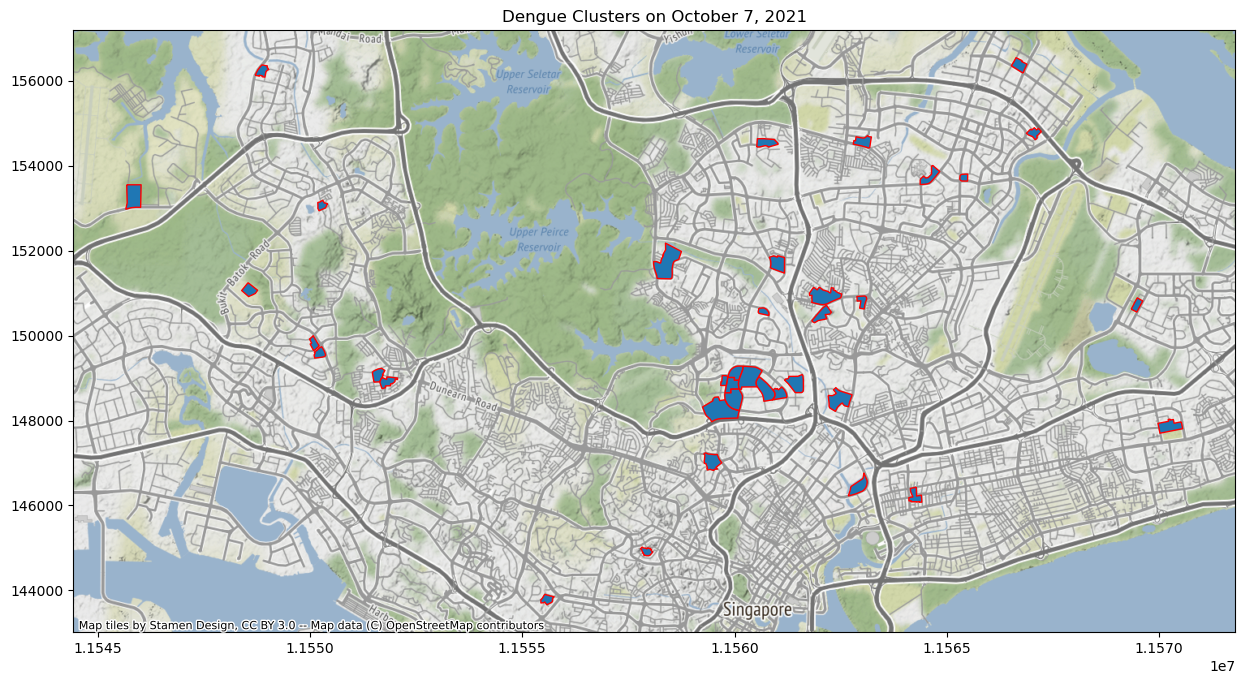

In [214]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Read the GeoJSON file for the first plot
gdf1 = gpd.read_file('../data/October 7, 2021 Clusters.geojson')
gdf1 = gdf1.to_crs(epsg=3857)

# Plot the GeoDataFrame with the outline map of Singapore for the first plot
ax1 = gdf1.plot(figsize=(15, 15), alpha=1, edgecolor='red')
plt.title('Dengue Clusters on October 7, 2021')
ctx.add_basemap(ax1)

# Display the first plot
plt.show()

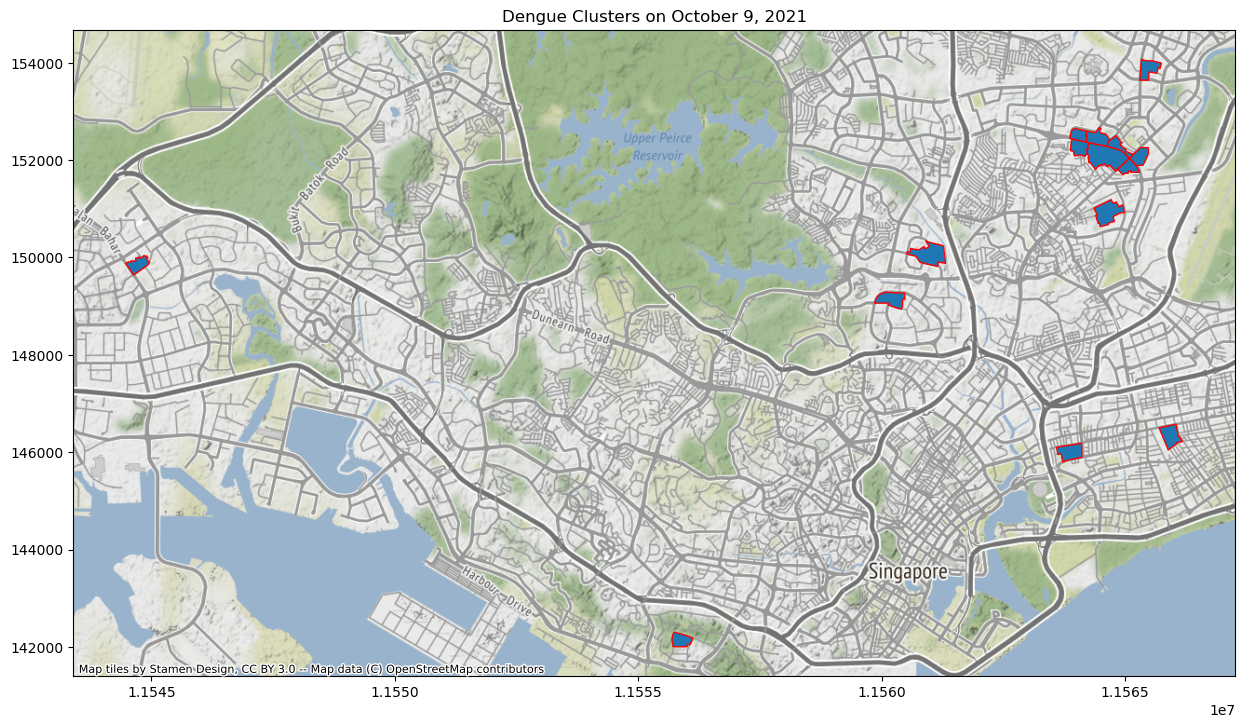

In [215]:
# Read the GeoJSON file for the second plot
gdf2 = gpd.read_file('../data/October 9, 2021 Clusters.geojson')
gdf2 = gdf2.to_crs(epsg=3857)

# Plot the GeoDataFrame with the outline map of Singapore for the second plot
ax2 = gdf2.plot(figsize=(15, 15), alpha=1, edgecolor='red')
plt.title('Dengue Clusters on October 9, 2021')
ctx.add_basemap(ax2)

# Display the second plot
plt.show()

From the maps above, we can see how different the clusters are, with not much overlaps between the two. This shows that in the span of only two days, the dengue clusters in Singapore can change very rapidly.

---
# Visualising the Data

----

In [216]:
disease.head()

end  cholera  paratyphoid   typhoid   acute viral hepatitis a  \
0  2012-01-07      0.0           1.0       6.0                      1.0   
1  2012-01-14      0.0           1.0       3.0                      2.0   
2  2012-01-21      0.0           1.0       5.0                      3.0   
3  2012-01-28      0.0           1.0       1.0                      3.0   
4  2012-02-04      0.0           3.0       5.0                      2.0   

   acute viral hepatitis e  poliomyelitis  plague  yellow fever  dengue fever  \
0                      3.0            0.0     0.0           0.0          74.0   
1                      0.0            0.0     0.0           0.0          64.0   
2                      0.0            0.0     0.0           0.0          60.0   
3                      2.0            0.0     0.0           0.0          50.0   
4                      0.0            0.0     0.0           0.0          84.0   

   ...  chickenpox  zika virus infection  leptospirosis  ebola virus disease  \
0  ...        18.0                   NaN            NaN                  NaN   
1  ...        19.0                   NaN            NaN                  NaN   
2  ...        16.0                   NaN            NaN                  NaN   
3  ...        24.0                   NaN            NaN                  NaN   
4  ...        18.0                   NaN            NaN                  NaN   

   japanese encephalitis  tetanus  botulism  murine typhus  monkeypox  \
0                    NaN      NaN       NaN            NaN        NaN   
1                    NaN      NaN       NaN            NaN        NaN   
2                    NaN      NaN       NaN            NaN        NaN   
3                    NaN      NaN       NaN            NaN        NaN   
4                    NaN      NaN       NaN            NaN        NaN   

   middle east respiratory syndrome  
0                               NaN  
1                               NaN  
2                               NaN  
3                               NaN  
4                               NaN  

[5 rows x 45 columns]

In [217]:
wid_corr = disease.corr(numeric_only = True)

In [218]:
wid_corr.columns

Index(['cholera', 'paratyphoid ', 'typhoid ', 'acute viral hepatitis a',
       'acute viral hepatitis e', 'poliomyelitis', 'plague', 'yellow fever',
       'dengue fever', 'dengue haemorrhagic fever', 'malaria',
       'chikungunya fever', 'hfmd', 'diphtheria', 'measles', 'mumps  ',
       'rubella', 'sars', 'nipah virus infection', 'acute viral hepatitis b',
       'encephalitis', 'legionellosis', 'campylobacteriosis',
       'acute viral hepatitis c', 'melioidosis', 'meningococcal infection',
       'pertussis', 'pneumococcal disease (invasive)',
       'haemophilus influenzae type b', 'salmonellosis(non-enteric fevers)',
       'avian influenza', 'acute upper respiratory tract infections',
       'acute conjunctivitis', 'acute diarrhoea', 'chickenpox',
       'zika virus infection', 'leptospirosis', 'ebola virus disease',
       'japanese encephalitis', 'tetanus', 'botulism', 'murine typhus',
       'monkeypox', 'middle east respiratory syndrome'],
      dtype='object')

In [219]:
wid_corr.loc['paratyphoid ', 'typhoid ']

0.1751260224280661

In [220]:
wid_corr.sort_values(by = 'dengue fever',inplace = True, ascending = False)

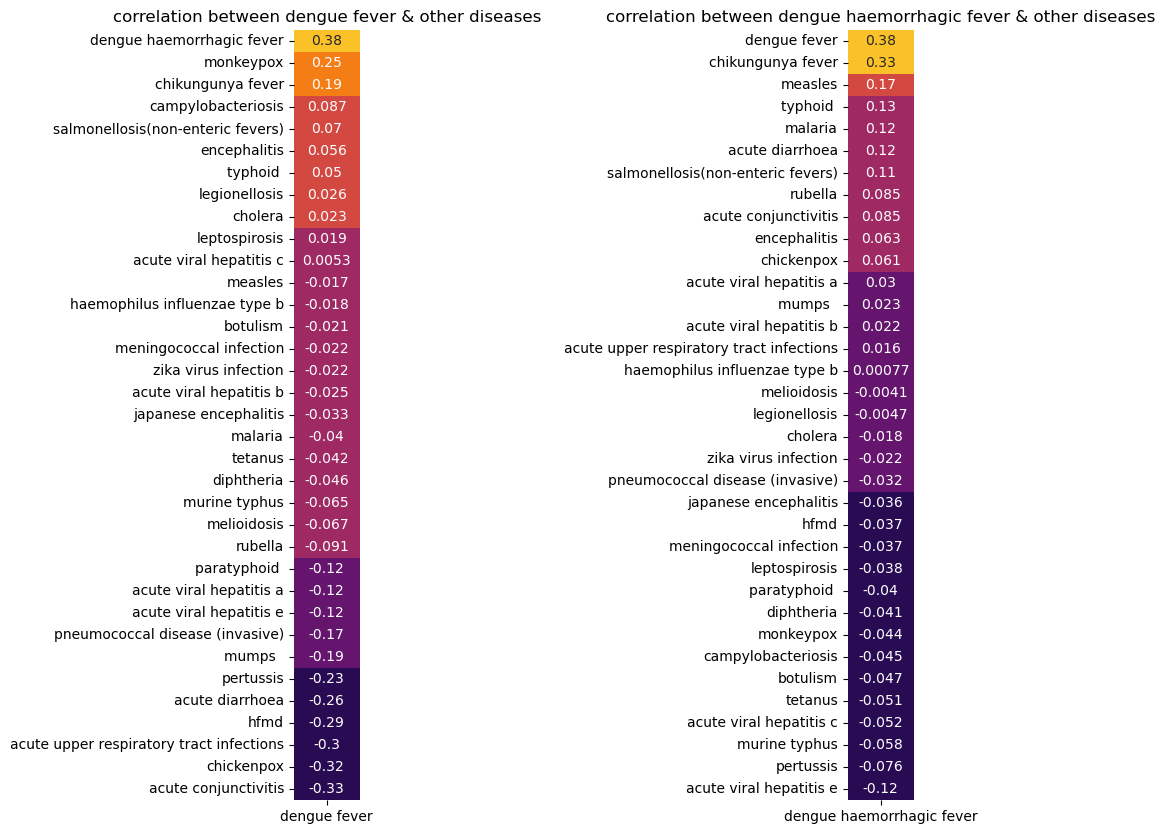

In [221]:
plt.figure(figsize= (8,10))
wid_corr.sort_values(by = 'dengue fever',inplace = True, ascending = False)
plt.subplot(1, 8, 1) 
ax1 = sns.heatmap(wid_corr[['dengue fever']][1:].dropna(), cmap = sns.color_palette("inferno"), annot = True, cbar = False);
ax1.set_title('correlation between dengue fever & other diseases')
wid_corr.sort_values(by = 'dengue haemorrhagic fever',inplace = True, ascending = False)
plt.subplot(1, 8, 8) 
ax2 = sns.heatmap(wid_corr[['dengue haemorrhagic fever']][1:].dropna(), cmap = sns.color_palette("inferno"), annot = True, cbar = False);
ax2.set_title('correlation between dengue haemorrhagic fever & other diseases');

S/N 	Vector 	Diseases
1 	Mosquito 	

    Dengue and Dengue Haemorrhagic Fever
    Chikungunya
    Zika
    Malaria
    Japanese Encephalitis
    Filariasis

For both types of dengue, we see that the number of chikungunya disease is one of the most highly positively correlated disease. This could be because of the fact that the ades mosquito is a vector for both types of disease and is able to carry both diseases simultaneously (as is the case for ability to infect people with both diseases.)

However, zika virus, which is also carried by the ades mosquito, has a mild negative correlation with dengue fever. This could be because

We notice that acute diarrhoea, acute conjunctivitis, acute upper respiratory tract infections were some of the most highly negatively correlated diseases with dengue fever but were mildly positively correlated with dengue haemorrhagic fever.

Possible reasons why:
Dengue and zika are closely related, but chikungunya is not. However, they are all transmitted by the same two species of day-biting mosquitoes, Aedes aegypti and the cold tolerant, Aedes albopictus, which are both exquisitely adapted to the human and urban environment.

### Heatmap Correlation

Working with our data, we want to visualise the correlation of each column and if there is a correlation there so as to know which factors we need to explore deeper.

This can be best done with a heatmap to give a good overview of the data we are working with. 

We are mainly looking at how all these features relate to dengue and dhf numbers.

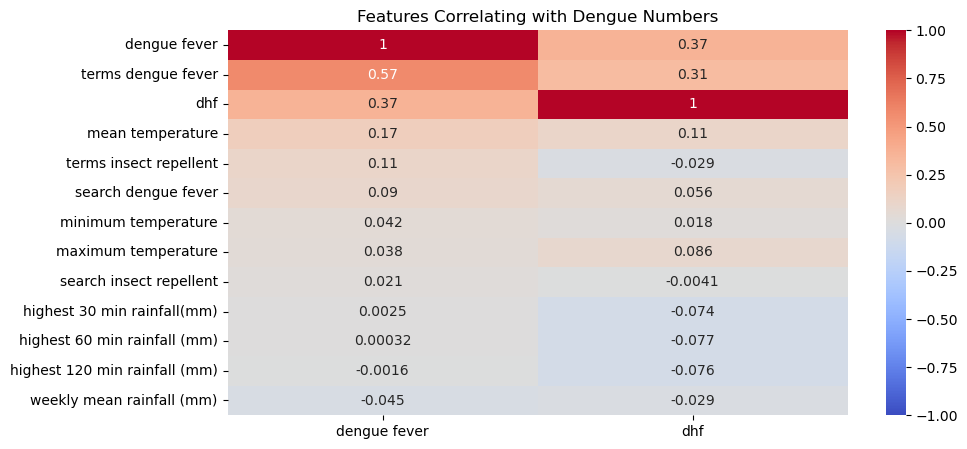

In [222]:
plt.figure(figsize=(10, 5))

heatmap = sns.heatmap(dengue_rain_google.corr(numeric_only = True)[['dengue fever', 'dhf']].sort_values(by='dengue fever', ascending=False), vmin=-1, vmax=1, annot=True, cmap='coolwarm');
heatmap.set_title('Features Correlating with Dengue Numbers');


We can see that there is not a huge correlation between both dengue fever and dhf cases, and the rest of the data. 

Though, notably, we can take note of the monthly mean temperature, as well as the 'search dengue fever' from the Google Trends data.

## Histograms & Outliers

Next, we want to look at the histograms of these features.

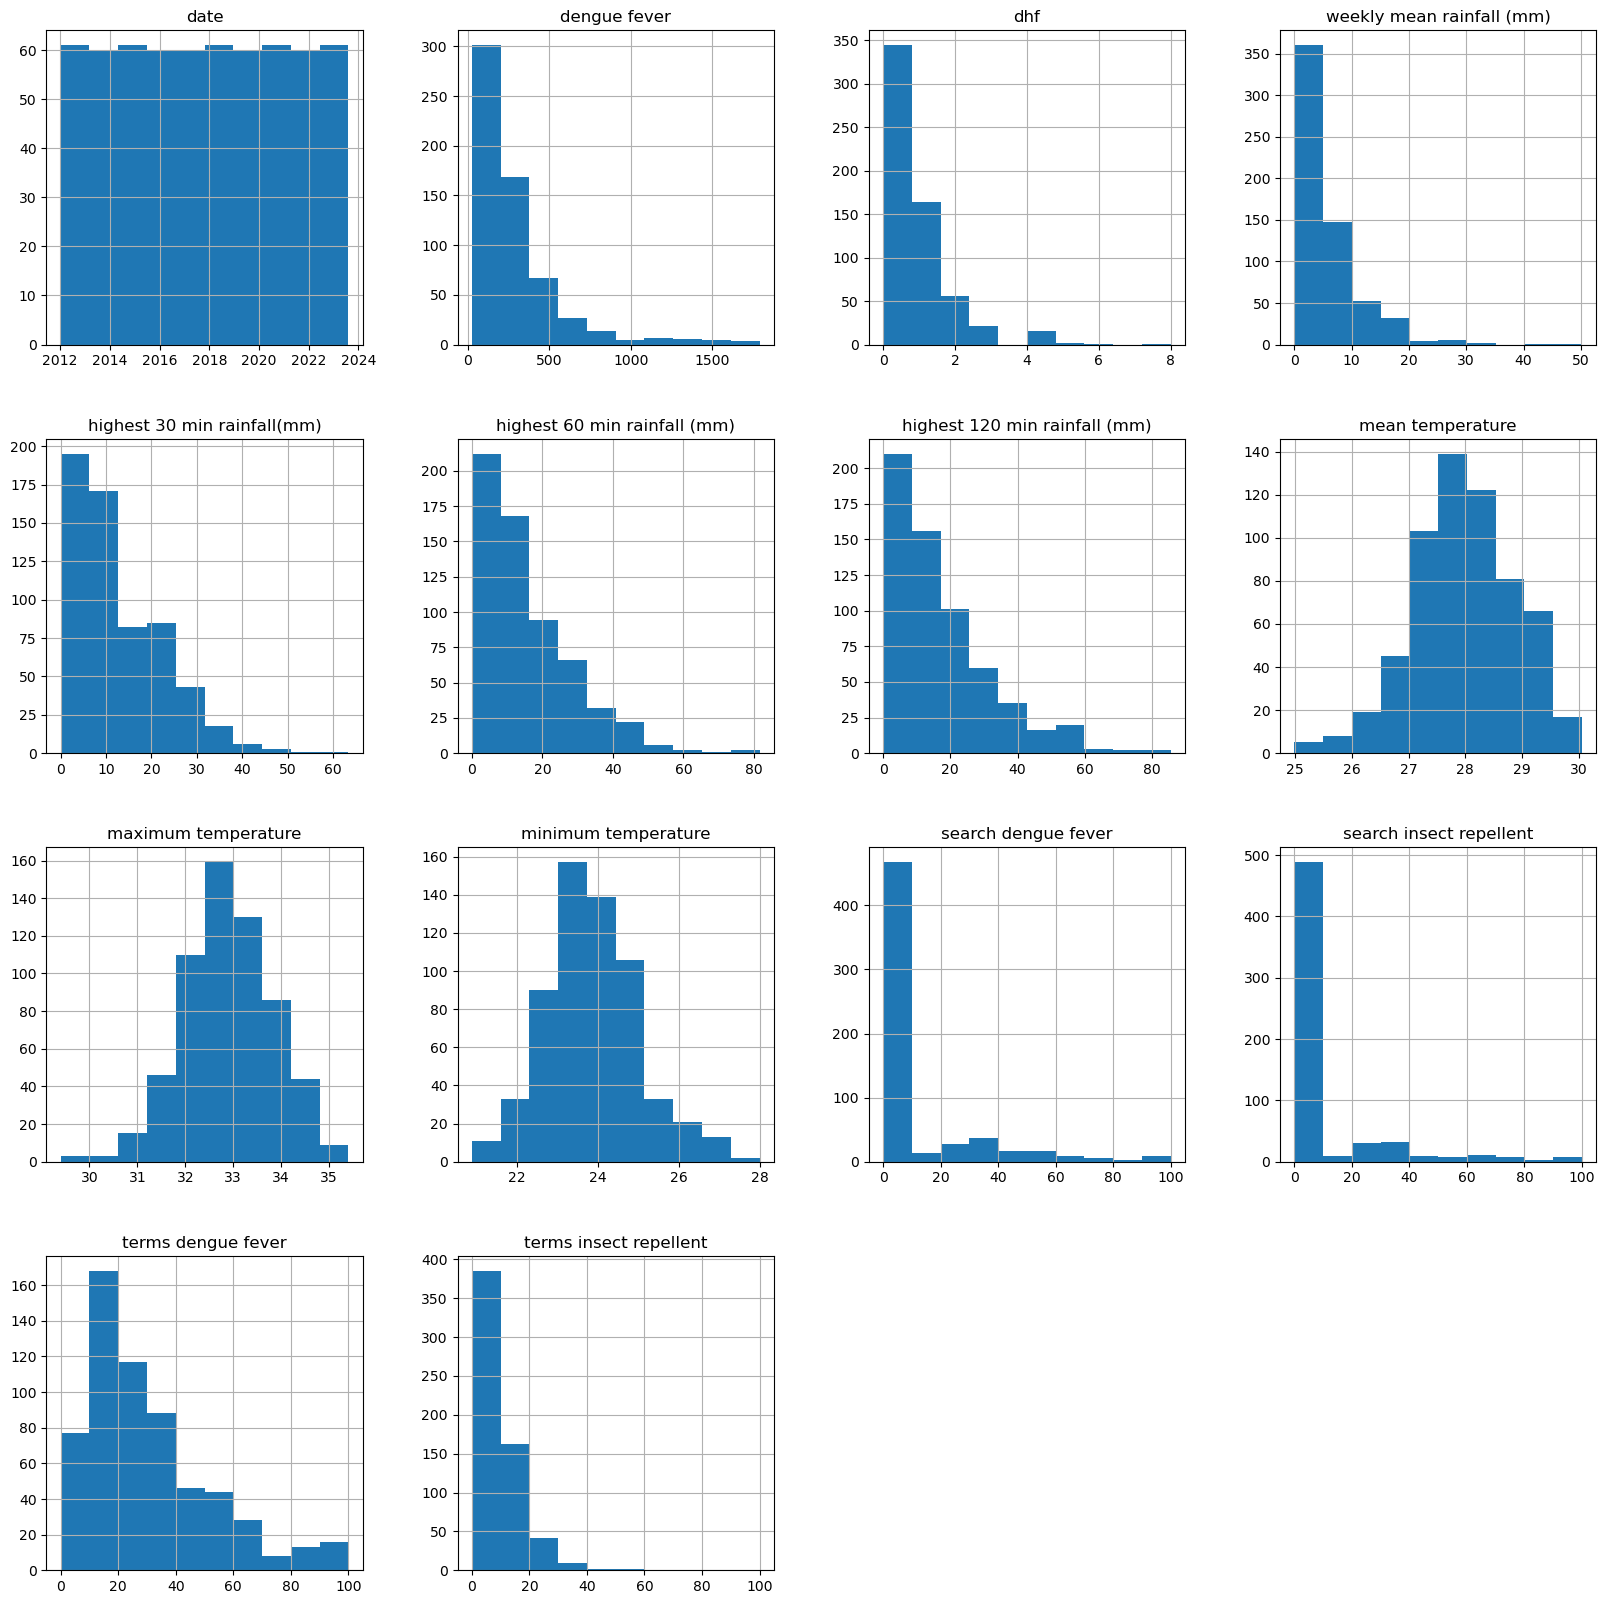

In [223]:
dengue_rain_google.hist(figsize=(20, 20));

From the histograms, we can see that there may be more outliers in the columns other than temperature which have relatively standard values. 
Let's take a look into limitting them to examine the histograms in more detail.

In [224]:
def hist(column, bins, range):
    plt.hist(dengue_rain_google[column], bins=bins, edgecolor='black', range=range)
    plt.xlabel(f'{column.title()}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column.title()}')
    plt.show()

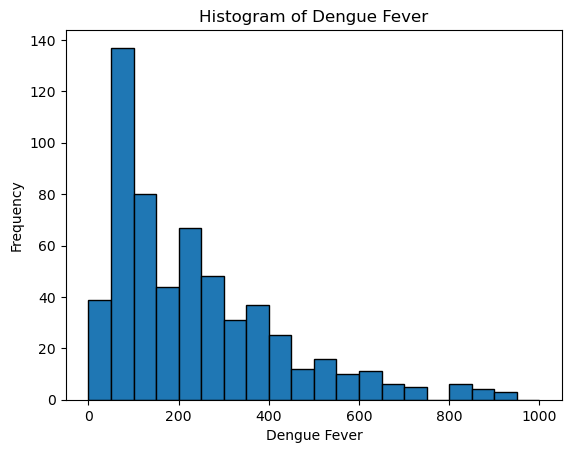

In [225]:
hist('dengue fever', 20, (0, 1000))

We can see the data is heavily skewed to the left even after limiting the outliers. Showing the bulk of dengue fever cases to be just under 100.

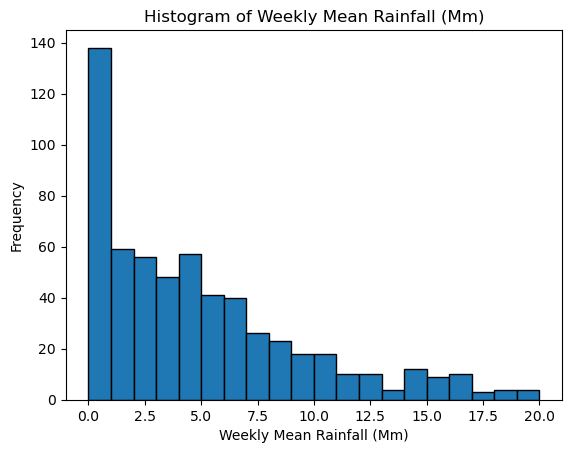

In [226]:
hist('weekly mean rainfall (mm)', 20, (0,20))

Similar to the dengue fever numbers, we can see the weekly mean rainfall is generally quite low throughout the year, apart from the occasional heavier rainfalls.

Seeing a similar trend to the other highest rainfall columns, let's move on to examine the Google Search Data instead.

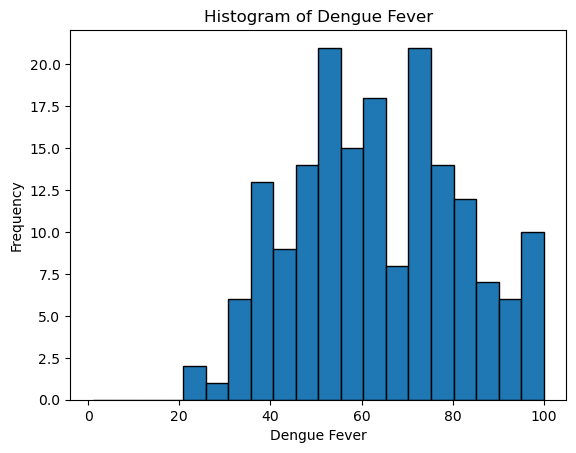

In [227]:
hist('dengue fever', 20, (1, 100))

Looking at the number of people who search for dengue fever on Google in Singapore, we can see it follows a vague normal distribution. It would be interesting to plot this out in relation to the dengue rates cases and see how it would affect each other.

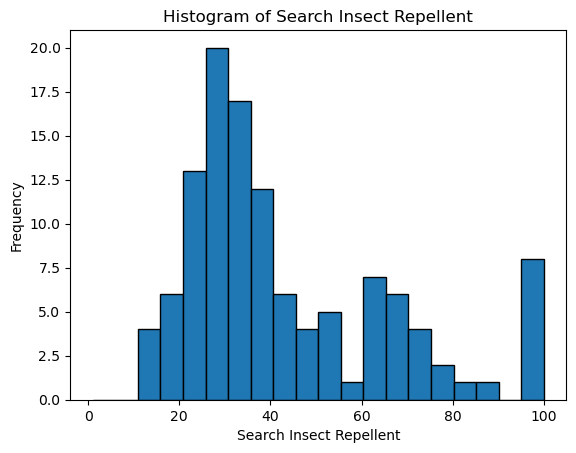

In [228]:
hist('search insect repellent', 20, (1, 100))

Similar to the dengue fever search on Google, people who search for insect repellent also follows a vague normal distribution. Again, it will be interesting to plot this in relation to the actual dengue cases to see if it affects anything.

We can see that there is a small amount of cases in the extremeities in some of the features. These few values are our outliers. However, it is important for us to keep this in as there may be many factors contributing to this.

## Comparing Trends

Next, we want to compare our dengue data to our weather data and google data to see what trends we can find.

Before comparing trends, let's combine the dengue fever and dhf numbers as the number of dhf cases are much fewer, and it might be more worth it to group them together.

In [229]:
dengue_rain_google['dengue fever'] = dengue_rain_google['dengue fever'] + dengue_rain_google['dhf']
dengue_rain_google.drop(columns = 'dhf', inplace = True)
dengue_rain_google.head()

date  dengue fever  weekly mean rainfall (mm)  \
0 2012-01-08          74.0                   0.342857   
1 2012-01-15          66.0                   7.428571   
2 2012-01-22          61.0                   3.485714   
3 2012-01-29          52.0                   1.371429   
4 2012-02-05          85.0                   8.328571   

   highest 30 min rainfall(mm)  highest 60 min rainfall (mm)  \
0                         6.55                          6.55   
1                         6.55                          6.55   
2                         6.55                          6.55   
3                         6.55                          6.55   
4                         6.55                          6.55   

   highest 120 min rainfall (mm)  mean temperature  maximum temperature  \
0                           6.55         27.314286                 31.4   
1                           6.55         25.914286                 30.9   
2                           6.55         26.971429                 32.5   
3                           6.55         26.557143                 31.6   
4                           6.55         26.414286                 31.6   

   minimum temperature  search dengue fever  search insect repellent  \
0                 24.5                   39                        0   
1                 23.8                    0                        0   
2                 22.1                    0                        0   
3                 23.5                    0                        0   
4                 21.5                    0                       79   

   terms dengue fever  terms insect repellent  
0                   8                       4  
1                  10                       0  
2                  11                       2  
3                   8                       0  
4                   9                       0

In [230]:
dengue_rain_google.columns

Index(['date', 'dengue fever', 'weekly mean rainfall (mm)',
       'highest 30 min rainfall(mm)', 'highest 60 min rainfall (mm)',
       'highest 120 min rainfall (mm)', 'mean temperature',
       'maximum temperature', 'minimum temperature', 'search dengue fever',
       'search insect repellent', 'terms dengue fever',
       'terms insect repellent'],
      dtype='object')

Let's look at these in some pairplots to see how each feature affects the dengue fever and dhf.

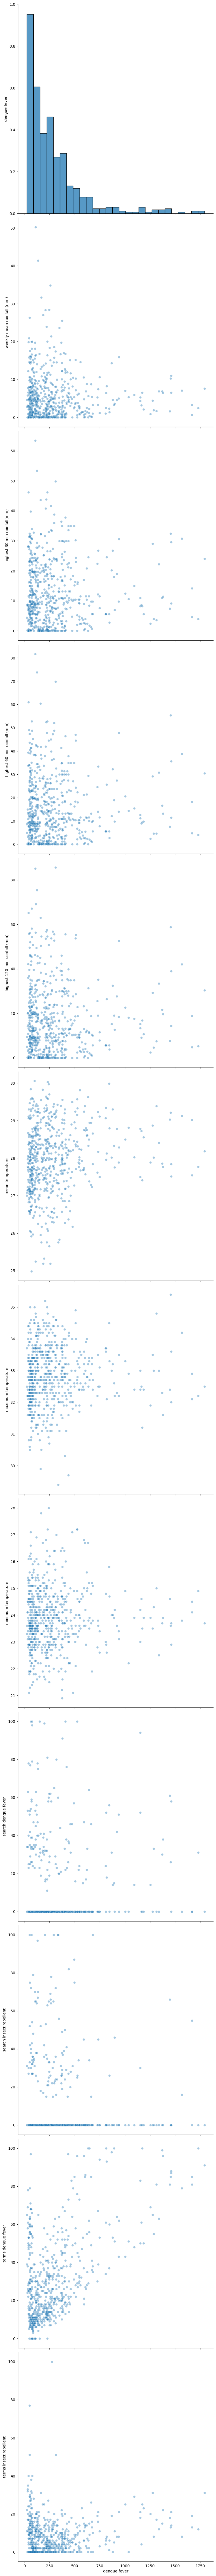

In [231]:
sns.pairplot(dengue_rain_google, x_vars=['dengue fever'], height= 8, plot_kws={'alpha': 0.4});

Here's what we can deduce from the pairplots:

1) Weekly Mean Rainfall
   - The number of dengue cases significantly reduce after a certain value around mid 50s mm
2) Highest Min Rainfall (mm)
   - The number of dengue cases decrease after around the 80mm value.
3) Mean and Maximum Temperature
   - The number of high dengue cases generally increase with temperatures higher than 27 degrees. Below 27 degrees, the number of cases do not reach the same detrimental amount.
4) Minimum Temperature
   - There is a small positive correlation between Minimum Temperature and the number of dengue cases. This would link back to the previous point of mean and max temperature.
5) Google Search
   - The Google search trends do not seem to relate much to the number of dengue cases

### Rainfall x Dengue

Breaking this down, we will first look at **rainfall** and its relationship with dengue. 

In [232]:
# Defining a function to plot a specific column against dengue.
def compare_plot(ax, column, y_label):
    ax.plot(dengue_rain_google['date'], dengue_rain_google['dengue fever'], color='darkblue', alpha=0.9, label = 'Dengue Numbers')
    ax.set_xlabel('Date')
    ax.set_ylabel('Dengue Numbers', color='darkblue')
    ax.tick_params(axis='y', labelcolor='darkblue')

    ax2 = ax.twinx()
    ax2.plot(dengue_rain_google['date'], dengue_rain_google[column], color='orange', alpha=0.6, label = y_label)
    ax2.set_ylabel(y_label, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    handles_ax, labels_ax = ax.get_legend_handles_labels()
    handles_ax2, labels_ax2 = ax2.get_legend_handles_labels()

    # Combine the handles and labels
    handles = handles_ax + handles_ax2
    labels = labels_ax + labels_ax2

    ax.set_title(f'Comparing Dengue numbers to {y_label}')
    ax.legend(handles, labels, loc='upper left')

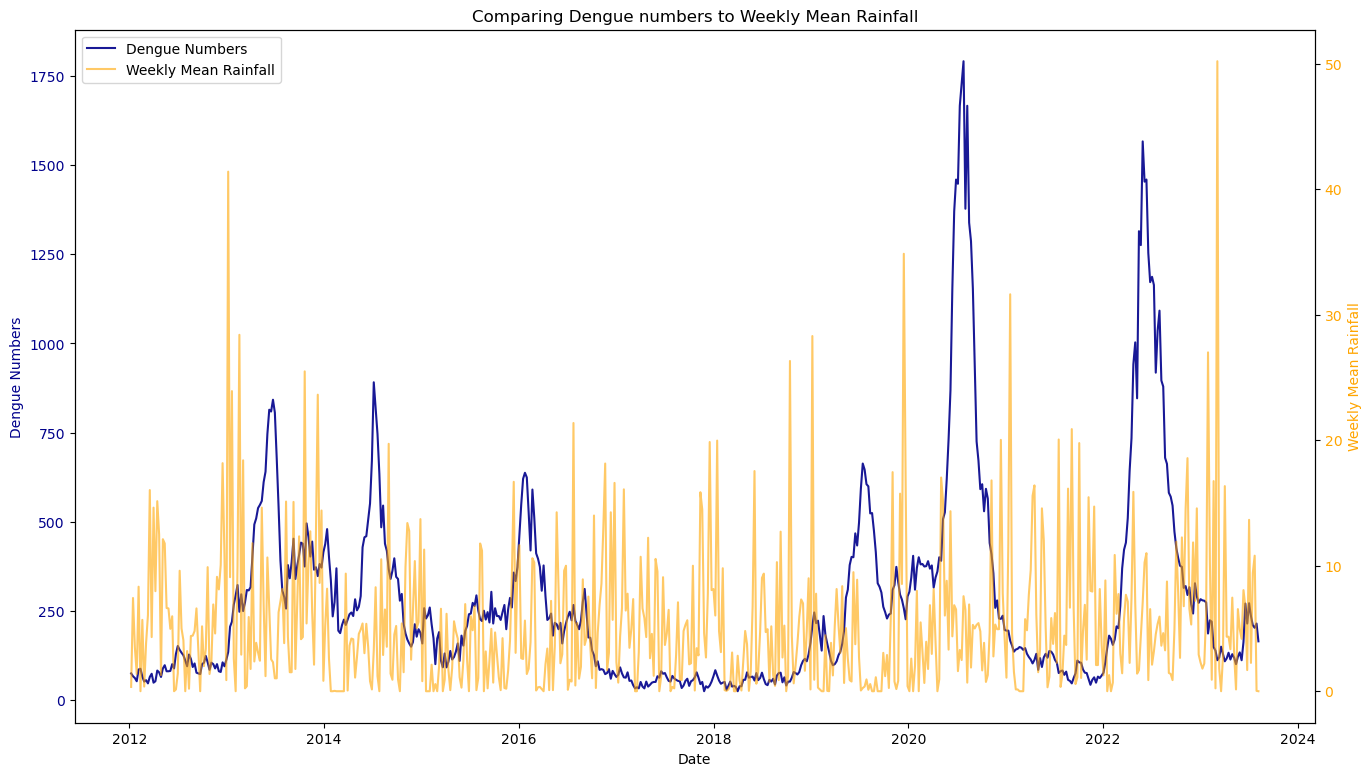

In [233]:
# Rainfall vs Dengue trend
fig, ax = plt.subplots(figsize=(16, 9))
compare_plot(ax,'weekly mean rainfall (mm)', 'Weekly Mean Rainfall')

Comparing the trends, mainly looking at the spikes, we are trying to see if there are any patterns or relationships. We can see that there is no pattern there, at most, there may be a pattern in the distance between some of the spikes. We can look into this further later in the notebook.

#### Highest Rainfall x Dengue

Now let's plot the dengue numbers against the highest 30 min rainfall.

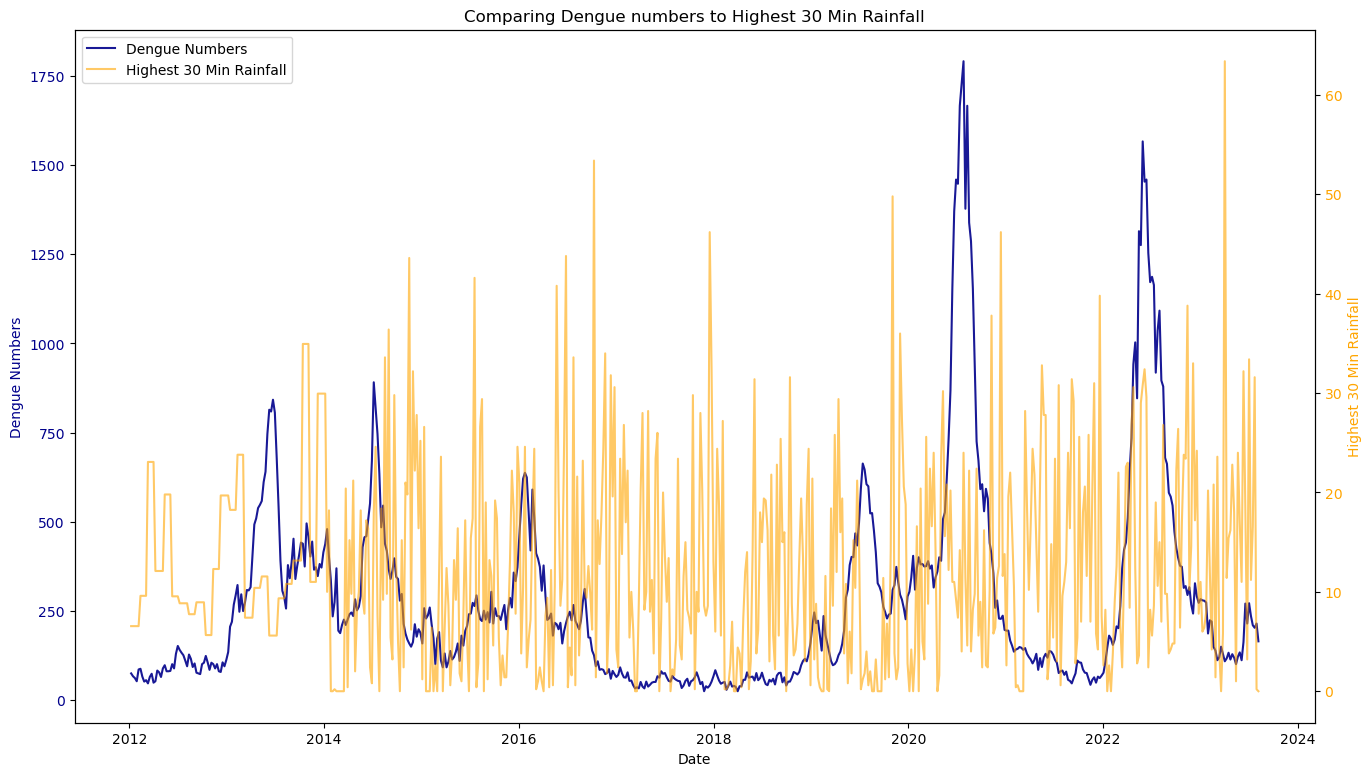

In [234]:
fig, ax = plt.subplots(figsize=(16, 9))
compare_plot(ax,'highest 30 min rainfall(mm)', 'Highest 30 Min Rainfall')

We can see that the rainfall numbers from 2012 to 2014 seems much higher than the other years. This is due to us imputing the values from the monthly rain data as there was no daily data available. Let's average them out and divide them into the number of weeks in the month to get similar ranges.

In [235]:
for year in range(2012, 2014):  # Range includes 2012 but not 2014
    for index, week_row in dengue_rain_google.iterrows():
        if week_row['date'].year == year:
            month = week_row['date'].month

                # Impute values back to weekly_weather
            dengue_rain_google.loc[index, 'highest 30 min rainfall(mm)'] = dengue_rain_google.loc[index, 'highest 30 min rainfall(mm)'] / 4
            dengue_rain_google.loc[index, 'highest 60 min rainfall (mm)'] = dengue_rain_google.loc[index, 'highest 60 min rainfall (mm)'] / 4
            dengue_rain_google.loc[index, 'highest 120 min rainfall (mm)'] = dengue_rain_google.loc[index, 'highest 120 min rainfall (mm)'] /4

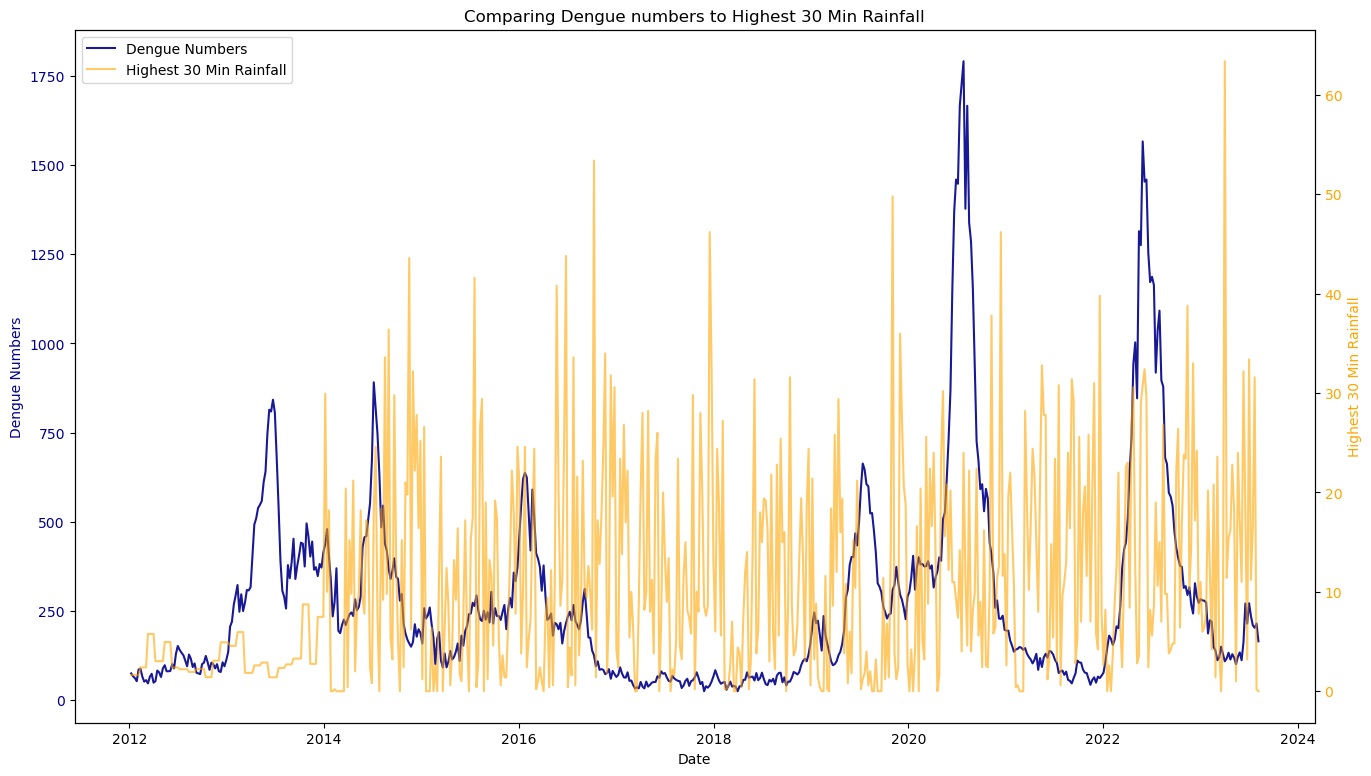

In [236]:
# Plotting the highest 30 min rainfall vs dengue numbers again
fig, ax = plt.subplots(figsize=(16, 9))
compare_plot(ax,'highest 30 min rainfall(mm)', 'Highest 30 Min Rainfall')

We can see one more high spike at the start of 2014. This is likely due to the monthly number from 2013 December. Let's impute the value from the previous row into this row.

In [237]:
# Finding index of the high spike
print(dengue_rain_google[dengue_rain_google['date'].dt.year == 2014].index[0])
dengue_rain_google[dengue_rain_google['date'].dt.year == 2014]

104


date  dengue fever  weekly mean rainfall (mm)  \
104 2014-01-05         437.0                   5.266667   
105 2014-01-12         479.0                   8.171429   
106 2014-01-19         401.0                   2.600000   
107 2014-01-26         336.0                   0.000000   
108 2014-02-02         234.0                   0.000000   
109 2014-02-09         274.0                   0.028571   
110 2014-02-16         369.0                   0.000000   
111 2014-02-23         194.0                   0.000000   
112 2014-03-02         187.0                   0.000000   
113 2014-03-09         210.0                   0.000000   
114 2014-03-16         225.0                   0.000000   
115 2014-03-23         210.0                   9.371429   
116 2014-03-30         225.0                   0.057143   
117 2014-04-06         240.0                   3.628571   
118 2014-04-13         245.0                   4.200000   
119 2014-04-20         235.0                   4.142857   
120 2014-04-27         282.0                   1.085714   
121 2014-05-04         251.0                   2.714286   
122 2014-05-11         261.0                   4.571429   
123 2014-05-18         291.0                   4.914286   
124 2014-05-25         428.0                   5.400000   
125 2014-06-01         456.0                   3.028571   
126 2014-06-08         459.0                   5.371429   
127 2014-06-15         506.0                   3.542857   
128 2014-06-22         551.0                   0.800000   
129 2014-06-29         671.0                   0.142857   
130 2014-07-06         891.0                   3.257143   
131 2014-07-13         819.0                   8.285714   
132 2014-07-20         746.0                   1.200000   
133 2014-07-27         634.0                   0.000000   
134 2014-08-03         484.0                  10.514286   
135 2014-08-10         545.0                   2.885714   
136 2014-08-17         438.0                   6.514286   
137 2014-08-24         418.0                   3.542857   
138 2014-08-31         367.0                  19.714286   
139 2014-09-07         339.0                   1.400000   
140 2014-09-14         362.0                   0.914286   
141 2014-09-21         397.0                   4.514286   
142 2014-09-28         345.0                   5.200000   
143 2014-10-05         339.0                   0.942857   
144 2014-10-12         278.0                   0.000000   
145 2014-10-19         297.0                   5.400000   
146 2014-10-26         213.0                   1.514286   
147 2014-11-02         186.0                   9.914286   
148 2014-11-09         169.0                  13.400000   
149 2014-11-16         158.0                  12.771429   
150 2014-11-23         149.0                   2.514286   
151 2014-11-30         162.0                   6.514286   
152 2014-12-07         212.0                  10.371429   
153 2014-12-14         177.0                   5.028571   
154 2014-12-21         198.0                   5.514286   
155 2014-12-28         188.0                  13.714286   

     highest 30 min rainfall(mm)  highest 60 min rainfall (mm)  \
104                        29.95                         29.95   
105                        10.00                         10.80   
106                        18.20                         18.20   
107                         0.00                          0.00   
108                         0.00                          0.00   
109                         0.20                          0.20   
110                         0.00                          0.00   
111                         0.00                          0.00   
112                         0.00                          0.00   
113                         0.00                          0.00   
114                         0.00                          0.00   
115                        20.40                         26.20   
116                     

In [238]:
# Imputing the values from the previous row.
for column in ['highest 30 min rainfall(mm)', 'highest 60 min rainfall (mm)', 'highest 120 min rainfall (mm)']:
    dengue_rain_google.loc[104, column] = dengue_rain_google.loc[103, column]
dengue_rain_google[dengue_rain_google['date'].dt.year == 2014]

date  dengue fever  weekly mean rainfall (mm)  \
104 2014-01-05         437.0                   5.266667   
105 2014-01-12         479.0                   8.171429   
106 2014-01-19         401.0                   2.600000   
107 2014-01-26         336.0                   0.000000   
108 2014-02-02         234.0                   0.000000   
109 2014-02-09         274.0                   0.028571   
110 2014-02-16         369.0                   0.000000   
111 2014-02-23         194.0                   0.000000   
112 2014-03-02         187.0                   0.000000   
113 2014-03-09         210.0                   0.000000   
114 2014-03-16         225.0                   0.000000   
115 2014-03-23         210.0                   9.371429   
116 2014-03-30         225.0                   0.057143   
117 2014-04-06         240.0                   3.628571   
118 2014-04-13         245.0                   4.200000   
119 2014-04-20         235.0                   4.142857   
120 2014-04-27         282.0                   1.085714   
121 2014-05-04         251.0                   2.714286   
122 2014-05-11         261.0                   4.571429   
123 2014-05-18         291.0                   4.914286   
124 2014-05-25         428.0                   5.400000   
125 2014-06-01         456.0                   3.028571   
126 2014-06-08         459.0                   5.371429   
127 2014-06-15         506.0                   3.542857   
128 2014-06-22         551.0                   0.800000   
129 2014-06-29         671.0                   0.142857   
130 2014-07-06         891.0                   3.257143   
131 2014-07-13         819.0                   8.285714   
132 2014-07-20         746.0                   1.200000   
133 2014-07-27         634.0                   0.000000   
134 2014-08-03         484.0                  10.514286   
135 2014-08-10         545.0                   2.885714   
136 2014-08-17         438.0                   6.514286   
137 2014-08-24         418.0                   3.542857   
138 2014-08-31         367.0                  19.714286   
139 2014-09-07         339.0                   1.400000   
140 2014-09-14         362.0                   0.914286   
141 2014-09-21         397.0                   4.514286   
142 2014-09-28         345.0                   5.200000   
143 2014-10-05         339.0                   0.942857   
144 2014-10-12         278.0                   0.000000   
145 2014-10-19         297.0                   5.400000   
146 2014-10-26         213.0                   1.514286   
147 2014-11-02         186.0                   9.914286   
148 2014-11-09         169.0                  13.400000   
149 2014-11-16         158.0                  12.771429   
150 2014-11-23         149.0                   2.514286   
151 2014-11-30         162.0                   6.514286   
152 2014-12-07         212.0                  10.371429   
153 2014-12-14         177.0                   5.028571   
154 2014-12-21         198.0                   5.514286   
155 2014-12-28         188.0                  13.714286   

     highest 30 min rainfall(mm)  highest 60 min rainfall (mm)  \
104                       7.4875                        7.4875   
105                      10.0000                       10.8000   
106                      18.2000                       18.2000   
107                       0.0000                        0.0000   
108                       0.0000                        0.0000   
109                       0.2000                        0.2000   
110                       0.0000                        0.0000   
111                       0.0000                        0.0000   
112                       0.0000                        0.0000   
113                       0.0000                        0.0000   
114                       0.0000                        0.0000   
115                      20.4000                       26.2000   
116                     

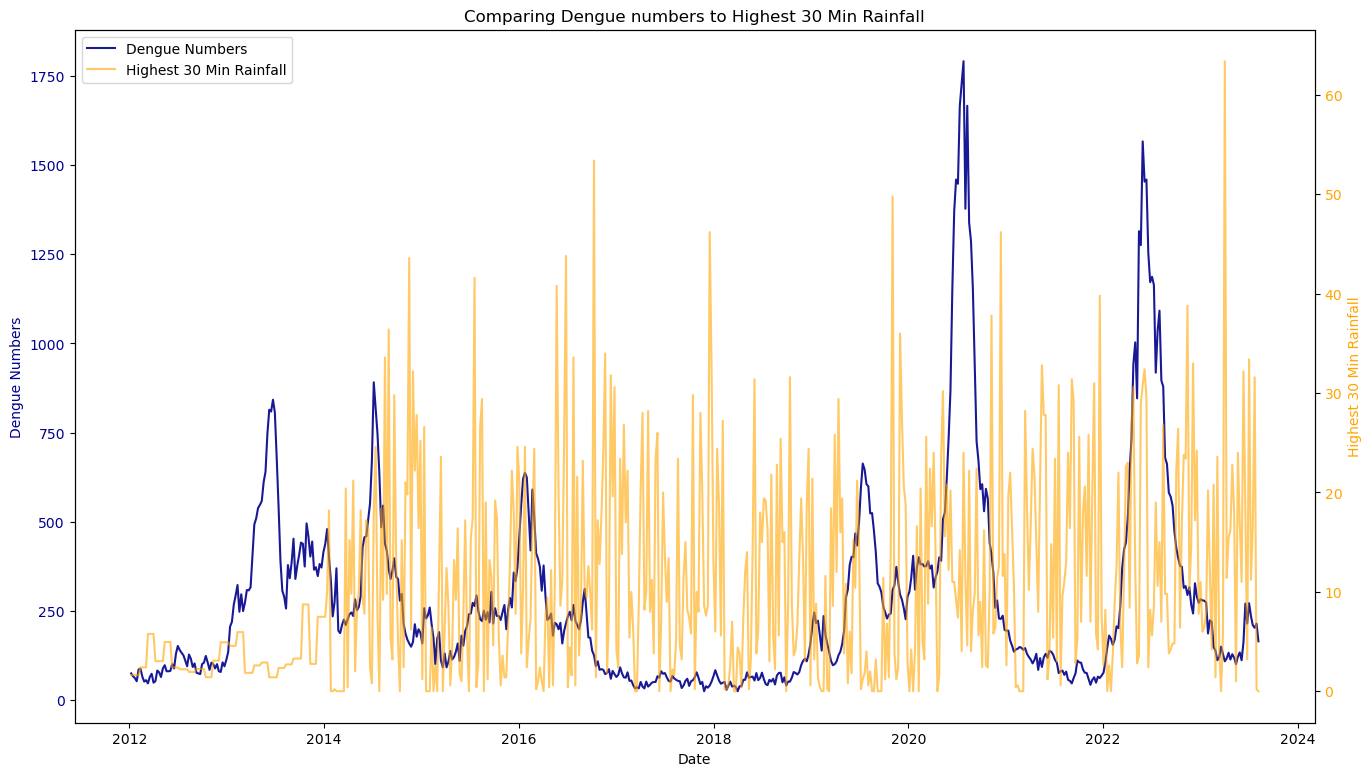

In [239]:
# Plotting the highest 30 min rainfall vs dengue numbers again
fig, ax = plt.subplots(figsize=(16, 9))
compare_plot(ax,'highest 30 min rainfall(mm)', 'Highest 30 Min Rainfall')

If we compare this to the scatter graphs that we saw earlier, the higher rainfalls generally lead to lower dengue cases. In this case, we can see that there are lower numbers of dengue where the spikes in highest rainfall are higher and more frequent. However, the relationship is not that apparent.


### Temperature x Dengue

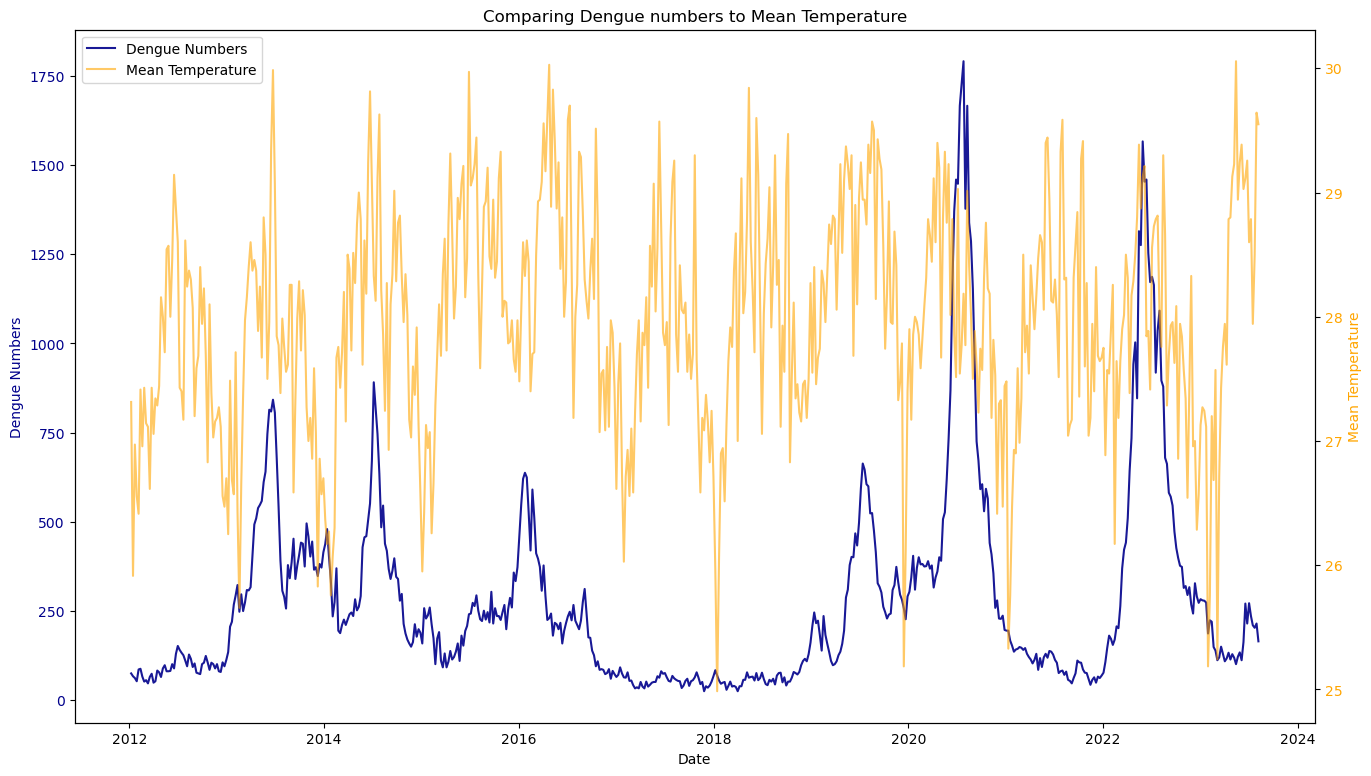

In [240]:
fig, ax = plt.subplots(figsize=(16, 9))
compare_plot(ax,'mean temperature', 'Mean Temperature')

From these, we can see some peaks in the temperature data that corresponds a little to the peaks in the dengue numbers.

Although not all the peaks corrospond with each other, these could be due to multiple reasons, such as heavy measures being put in place by the government to try and mitigate the situation.<sup>[3](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3373041/)</sup>

The peaks may not completely line up, this could be due to the delay in the time it takes for the Aedes aegypti to breed, get infected, and transmit the disease. 

We will be exploring the time lag later on in the notebook, to see if there is a significant difference between them.

#### Google Trends vs Dengue Cases

Moving on, let's plot the Google Trends data vs the dengue cases and see if there is any relationship between them.

In [241]:
dengue_rain_google

date  dengue fever  weekly mean rainfall (mm)  \
0   2012-01-08          74.0                   0.342857   
1   2012-01-15          66.0                   7.428571   
2   2012-01-22          61.0                   3.485714   
3   2012-01-29          52.0                   1.371429   
4   2012-02-05          85.0                   8.328571   
..         ...           ...                        ...   
600 2023-07-09         235.0                   2.257143   
601 2023-07-16         209.0                   9.428571   
602 2023-07-23         202.0                  10.800000   
603 2023-07-30         214.0                   0.028571   
604 2023-08-06         164.0                   0.000000   

     highest 30 min rainfall(mm)  highest 60 min rainfall (mm)  \
0                         1.6375                        1.6375   
1                         1.6375                        1.6375   
2                         1.6375                        1.6375   
3                         1.6375                        1.6375   
4                         1.6375                        1.6375   
..                           ...                           ...   
600                      11.2000                       14.2000   
601                      16.6000                       24.6000   
602                      31.6000                       37.8000   
603                       0.2000                        0.2000   
604                       0.0000                        0.0000   

     highest 120 min rainfall (mm)  mean temperature  maximum temperature  \
0                           1.6375         27.314286                 31.4   
1                           1.6375         25.914286                 30.9   
2                           1.6375         26.971429                 32.5   
3                           1.6375         26.557143                 31.6   
4                           1.6375         26.414286                 31.6   
..                             ...               ...                  ...   
600                        14.2000         28.785714                 33.6   
601                        27.0000         27.942857                 32.9   
602                        42.2000         28.500000                 32.5   
603                         0.2000         29.642857                 33.1   
604                         0.0000         29.550000                 32.8   

     minimum temperature  search dengue fever  search insect repellent  \
0                   24.5                   39                        0   
1                   23.8                    0                        0   
2                   22.1                    0                        0   
3                   23.5                    0                        0   
4                   21.5                    0                       79   
..                   ...                  ...                      ...   
600                 23.9                    0                        0   
601                 22.9                   17                        0   
602                 22.8                    0                      100   
603                 26.8                    0                        0   
604                 27.8                    0                        0   

     terms dengue fever  terms insect repellent  
0                     8                       4  
1                    10                       0  
2                    11                       2  
3                     8                       0  
4                     9                       0  
..                  ...                     ...  
600                  26                      14  
601                  30                       0  
602                  24                      17  
603                  28                       5  
604                  27                      10  

[605 rows x 13 columns]

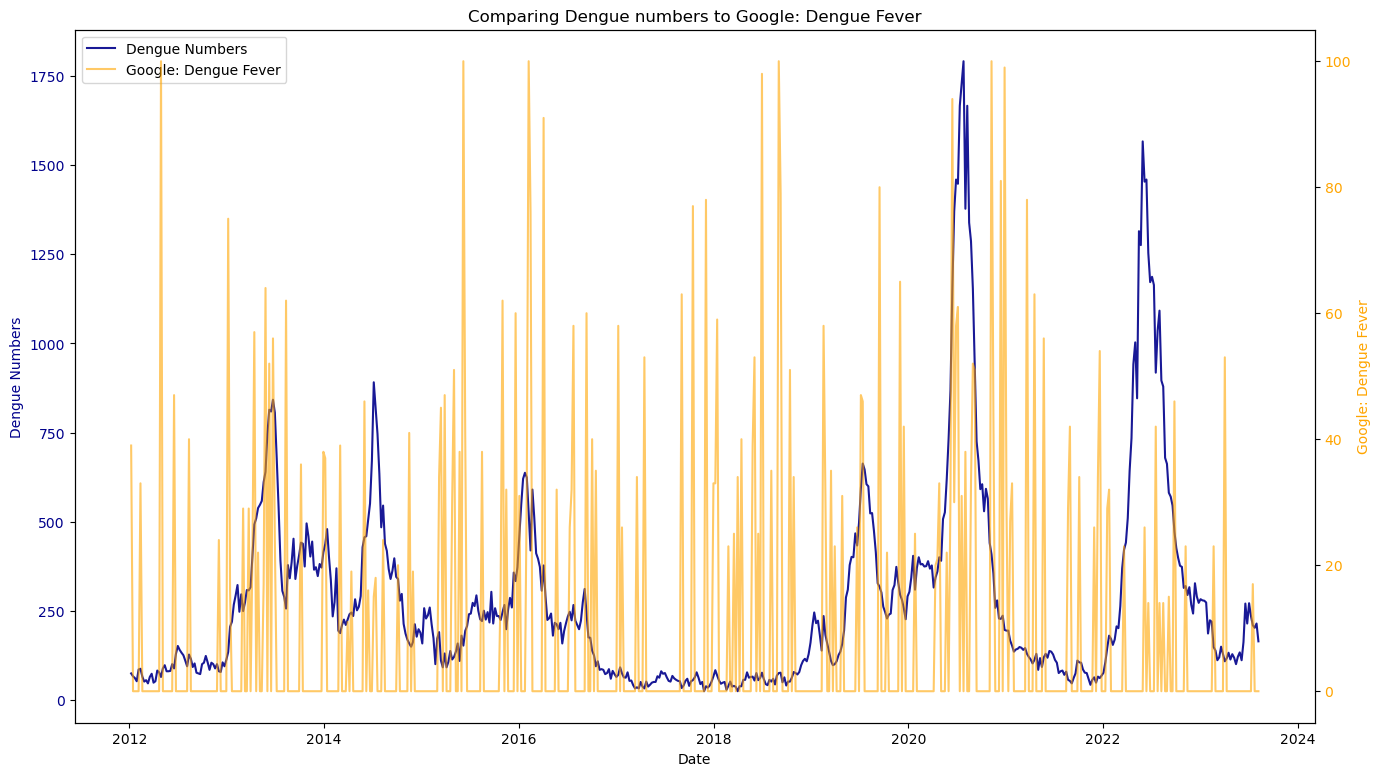

In [242]:
fig, ax = plt.subplots(figsize=(16, 9))
compare_plot(ax,'search dengue fever', 'Google: Dengue Fever')

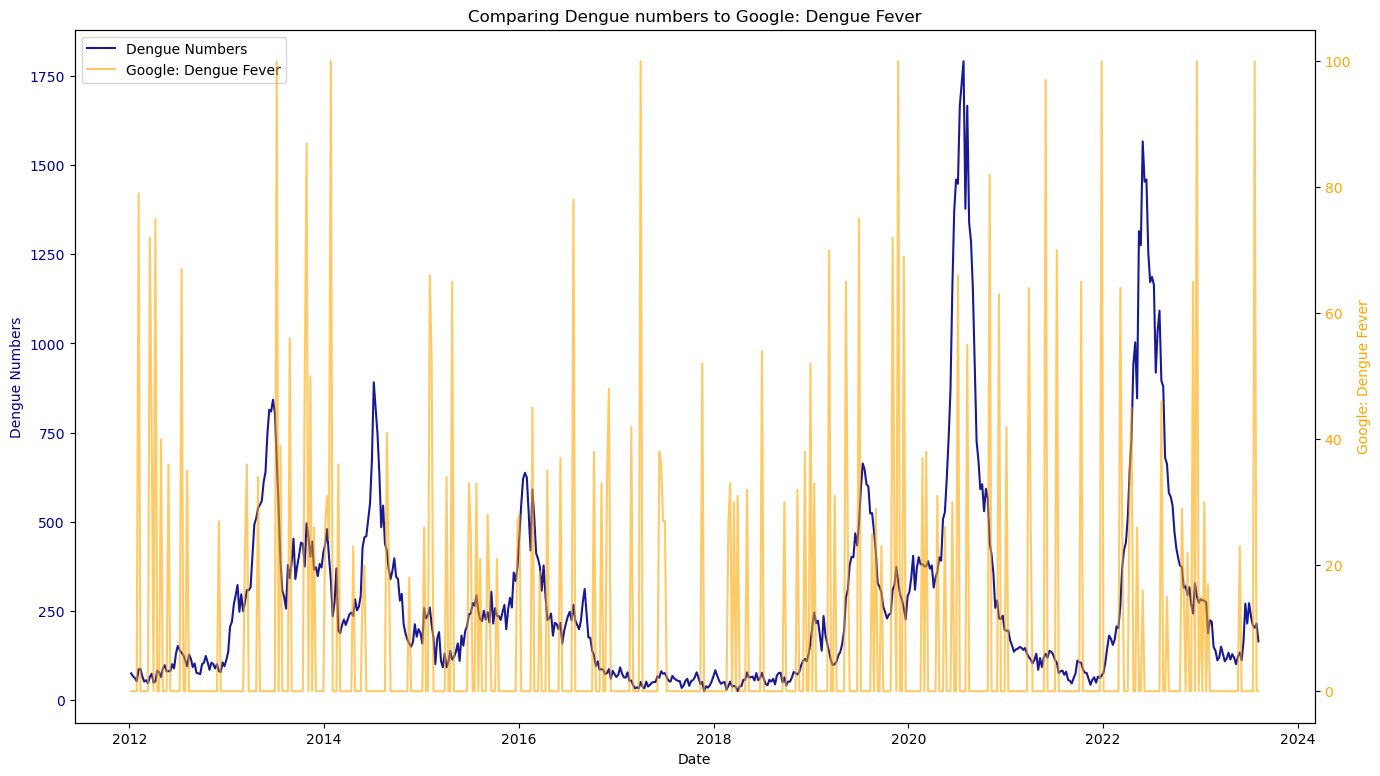

In [243]:
fig, ax = plt.subplots(figsize=(16, 9))
compare_plot(ax,'search insect repellent', 'Google: Dengue Fever')

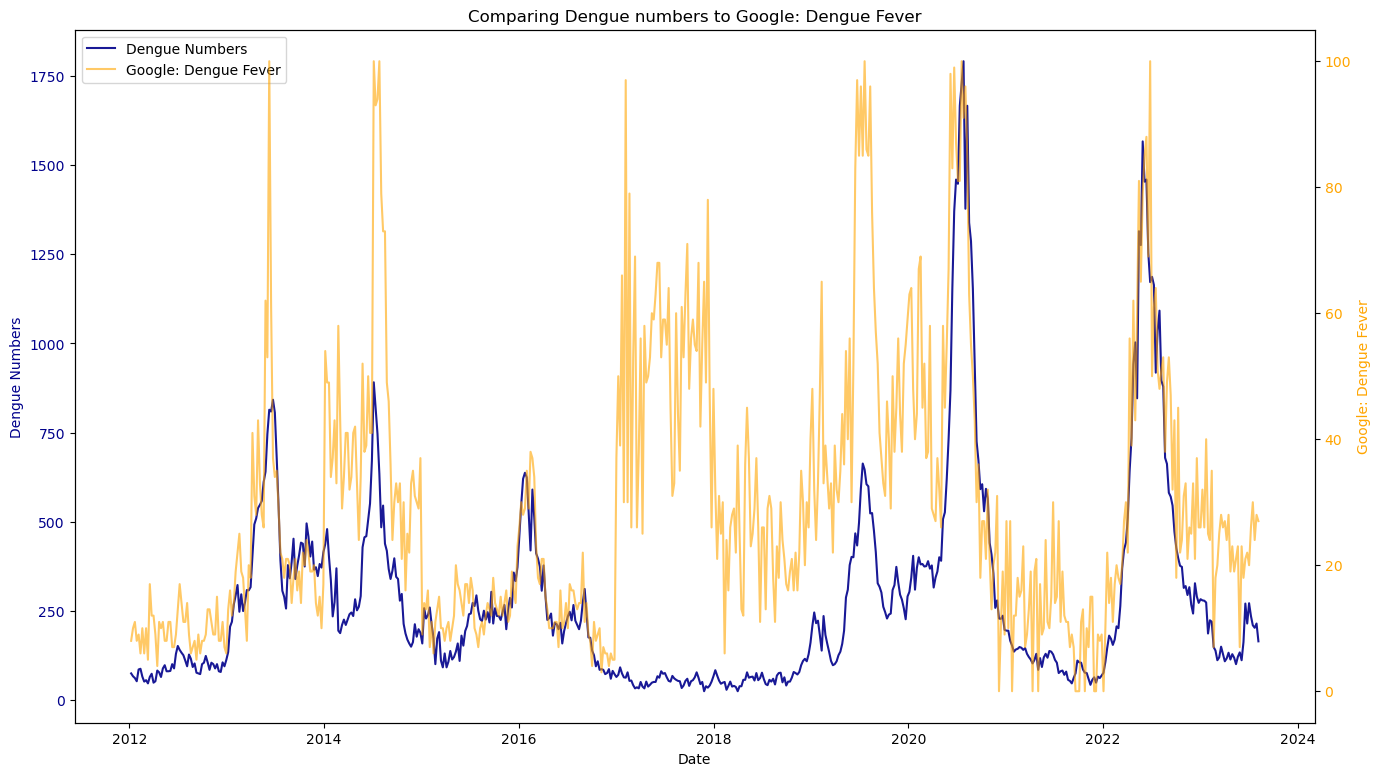

In [244]:
fig, ax = plt.subplots(figsize=(16, 9))
compare_plot(ax,'terms dengue fever', 'Google: Dengue Fever')

For the Google Trends data, unfortunately we can see that there is not much correlation between any of the search data and the number of dengue cases, as the spikes on our google trends data are quite erratic, and do not quite line up with the dengue peaks.

As we are interested in seeing if there is an effect on temperature lag, we will take a look at the monthly lag and see if it makes a difference.

In [245]:
for value in list(range(1,17)):
    dengue_rain_google[f'temperature_lag_{value}'] = dengue_rain_google['mean temperature'].shift(value)

dengue_rain_google.head(15)


date  dengue fever  weekly mean rainfall (mm)  \
0  2012-01-08          74.0                   0.342857   
1  2012-01-15          66.0                   7.428571   
2  2012-01-22          61.0                   3.485714   
3  2012-01-29          52.0                   1.371429   
4  2012-02-05          85.0                   8.328571   
5  2012-02-12          87.0                   0.000000   
6  2012-02-19          65.0                   5.685714   
7  2012-02-26          51.0                   0.371429   
8  2012-03-04          55.0                   3.828571   
9  2012-03-11          46.0                   6.057143   
10 2012-03-18          64.0                  16.028571   
11 2012-03-25          73.0                   4.314286   
12 2012-04-01          48.0                  14.628571   
13 2012-04-08          52.0                   7.971429   
14 2012-04-15          82.0                  15.142857   

    highest 30 min rainfall(mm)  highest 60 min rainfall (mm)  \
0                       1.63750                       1.63750   
1                       1.63750                       1.63750   
2                       1.63750                       1.63750   
3                       1.63750                       1.63750   
4                       1.63750                       1.63750   
5                       2.40000                       2.40000   
6                       2.40000                       2.40000   
7                       2.40000                       2.40000   
8                       2.40000                       2.40000   
9                       5.76875                       5.76875   
10                      5.76875                       5.76875   
11                      5.76875                       5.76875   
12                      5.76875                       5.76875   
13                      3.02500                       3.02500   
14                      3.02500                       3.02500   

    highest 120 min rainfall (mm)  mean temperature  maximum temperature  \
0                         1.63750         27.314286                 31.4   
1                         1.63750         25.914286                 30.9   
2                         1.63750         26.971429                 32.5   
3                         1.63750         26.557143                 31.6   
4                         1.63750         26.414286                 31.6   
5                         2.40000         27.414286                 32.3   
6                         2.40000         26.957143                 31.9   
7                         2.40000         27.428571                 32.6   
8                         2.40000         27.142857                 33.2   
9                         5.76875         27.114286                 32.4   
10                        5.76875         26.614286                 32.1   
11                        5.76875         27.428571                 32.4   
12                        5.76875         27.057143                 32.8   
13                        3.02500         27.342857                 32.3   
14                        3.02500         27.285714                 31.9   

    minimum temperature  search dengue fever  ...  temperature_lag_7  \
0                  24.5                   39  ...                NaN   
1                  23.8                    0  ...                NaN   
2                  22.1                    0  ...                NaN   
3                  23.5                    0  ...                NaN   
4                  21.5                    0  ...                NaN   
5                  24.4                   33  ...                NaN   
6                  23.0                    0  ...                NaN   
7                  22.7                    0  ...          27.314286   
8                  23.8                    0  ...          25.914286   
9                  21.1                    0  ...          26.971429   
10                 22.7       

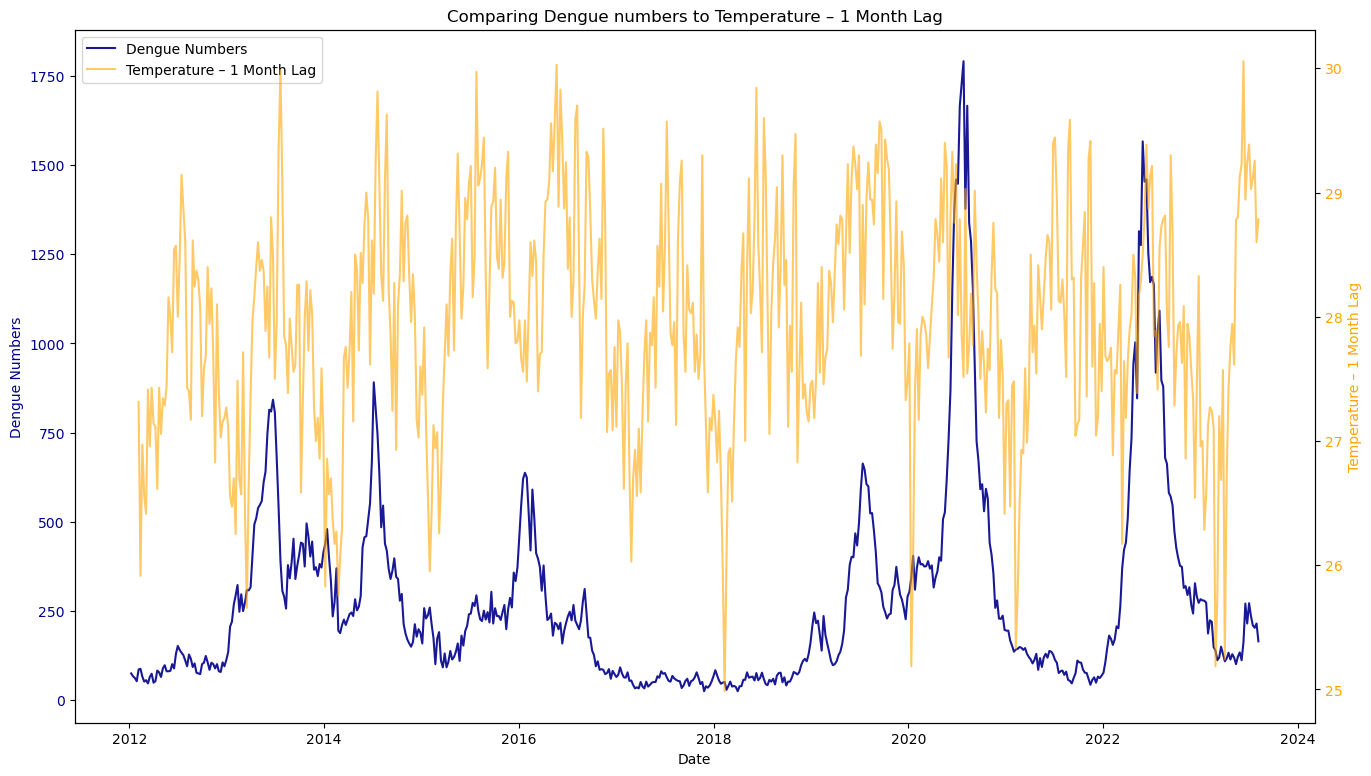

In [246]:
fig, ax = plt.subplots(figsize=(16, 9))
compare_plot(ax,'temperature_lag_4', 'Temperature – 1 Month Lag')

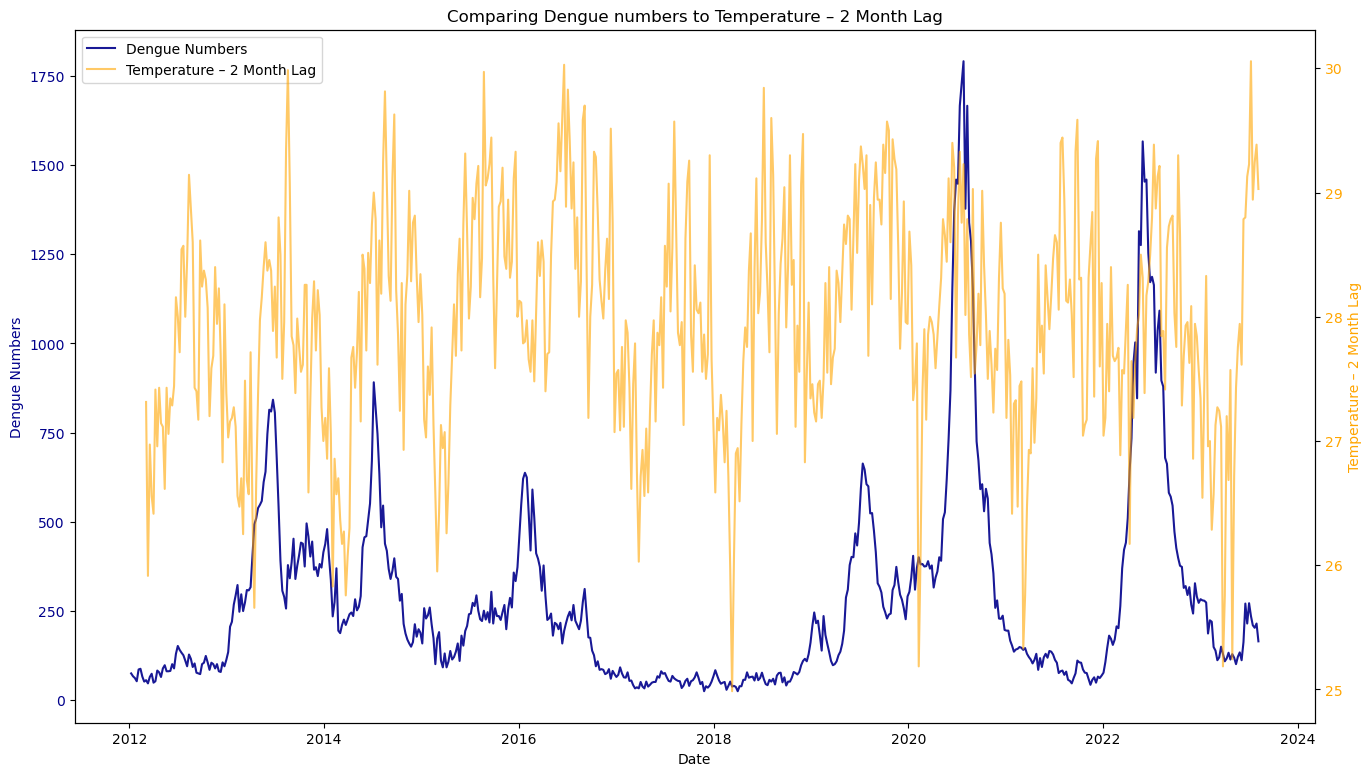

In [247]:
fig, ax = plt.subplots(figsize=(16, 9))
compare_plot(ax,'temperature_lag_8', 'Temperature – 2 Month Lag')

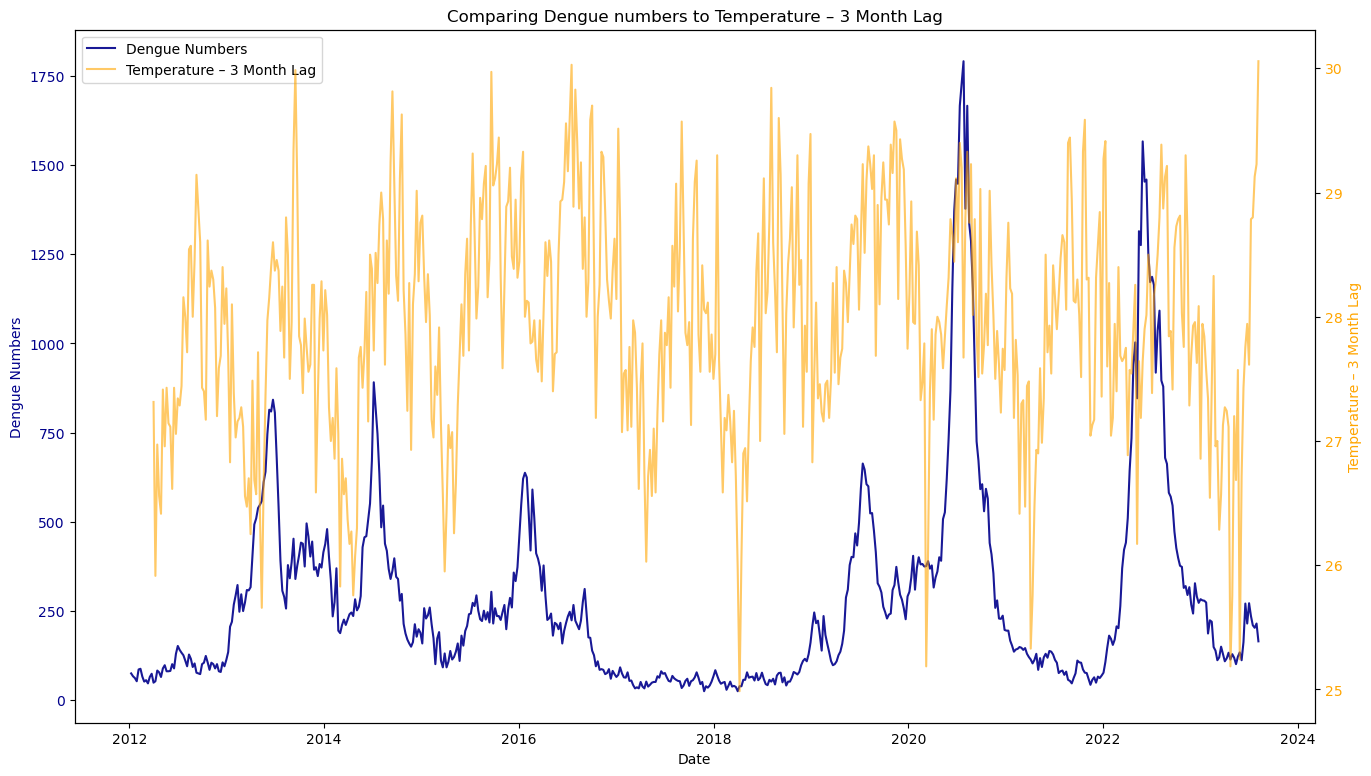

In [248]:
fig, ax = plt.subplots(figsize=(16, 9))
compare_plot(ax,'temperature_lag_12', 'Temperature – 3 Month Lag')

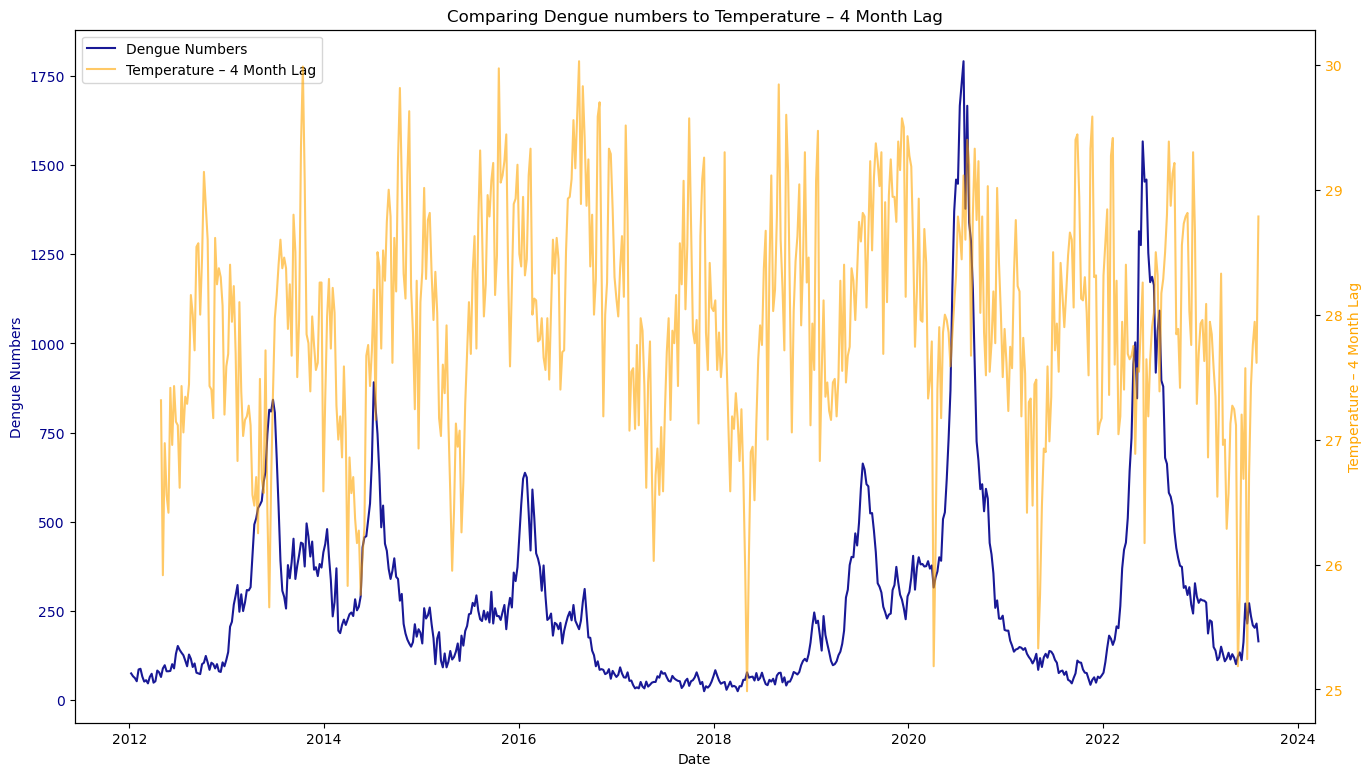

In [249]:
fig, ax = plt.subplots(figsize=(16, 9))
compare_plot(ax,'temperature_lag_16', 'Temperature – 4 Month Lag')

From the above graphs, we can see the peaks may line up best around the 12 week / 3 month lag. This may be good to note for our future modelling, as an additional feature that could be used.